In [ ]:
"""
Process FEVER train.jsonl file - SIMPLE VERSION
Just edit the INPUT_FILE path below and run!
"""

import json
import pandas as pd
import random
from pathlib import Path


INPUT_FILE = r"C:\Users\pooji\Downloads\train.jsonl"  # ← CHANGE THIS TO YOUR PATH


N_SAMPLES = 15000  # Number of claims to extract (500 each label)
OUTPUT_DIR = r"C:\Users\pooji\Desktop"

def process_fever_data():
    """Process FEVER data and extract subset"""
    
    print("="*60)
    print("FEVER Dataset Processing")
    print("="*60)
    
    # Check if file exists
    if not Path(INPUT_FILE).exists():
        print(f"\n ERROR: File not found!")
        print(f"Looking for: {INPUT_FILE}")
        print(f"\n Please edit INPUT_FILE at the top of this script")
        print(f"   and provide the correct path to train.jsonl")
        return
    
    print(f"\n✓ Found file: {INPUT_FILE}")
    file_size_mb = Path(INPUT_FILE).stat().st_size / (1024 * 1024)
    print(f"  File size: {file_size_mb:.1f} MB")
    
    # Read claims
    print(f"\nReading claims (this may take a minute)...")
    claims = []
    
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i % 10000 == 0 and i > 0:
                print(f"  Processed {i:,} lines...")
            
            try:
                data = json.loads(line.strip())
                # Include all claims (both VERIFIABLE and NOT VERIFIABLE)
                # NOT VERIFIABLE claims have "NOT ENOUGH INFO" label
                claims.append(data)
            except:
                continue
    
    print(f"\n✓ Loaded {len(claims):,} total claims (VERIFIABLE + NOT VERIFIABLE)")
    
    # Separate by label
    supports = [c for c in claims if c['label'] == 'SUPPORTS']
    refutes = [c for c in claims if c['label'] == 'REFUTES']
    not_enough = [c for c in claims if c['label'] == 'NOT ENOUGH INFO']
    
    print(f"\nLabel distribution in source data:")
    print(f"  SUPPORTS: {len(supports):,}")
    print(f"  REFUTES: {len(refutes):,}")
    print(f"  NOT ENOUGH INFO: {len(not_enough):,}")
    
    # Sample balanced subset (equal amounts of each label)
    n_each = N_SAMPLES // 3
    sampled = (
        random.sample(supports, min(n_each, len(supports))) +
        random.sample(refutes, min(n_each, len(refutes))) +
        random.sample(not_enough, min(n_each, len(not_enough)))
    )
    random.shuffle(sampled)
    
    print(f"\n✓ Sampled {len(sampled)} balanced claims")
    
    # Convert to simple format
    processed = []
    for claim in sampled:
        processed.append({
            'id': claim['id'],
            'claim': claim['claim'],
            'label': claim['label'],
            'evidence': claim.get('evidence', [])
        })
    
    # Save data
    Path(OUTPUT_DIR).mkdir(exist_ok=True)
    
    # Save CSV
    df = pd.DataFrame(processed)
    csv_path = f"{OUTPUT_DIR}/fever_claims_subset.csv"
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Saved: {csv_path}")
    
    # Save JSON
    json_path = f"{OUTPUT_DIR}/fever_claims_full.json"
    with open(json_path, 'w') as f:
        json.dump(processed, f, indent=2)
    print(f"✓ Saved: {json_path}")
    
    # Save sample
    sample_path = f"{OUTPUT_DIR}/sample_claims.json"
    with open(sample_path, 'w') as f:
        json.dump(processed[:5], f, indent=2)
    print(f"✓ Saved: {sample_path}")
    
    # Show statistics
    print(f"\n{'='*60}")
    print("Dataset Statistics")
    print(f"{'='*60}")
    print(f"\nTotal claims: {len(df)}")
    print(f"\nLabel distribution:")
    print(df['label'].value_counts())
    
    # Show samples
    print(f"\n{'='*60}")
    print("Sample Claims:")
    print(f"{'='*60}")
    for i in range(min(3, len(processed))):
        print(f"\n{i+1}. {processed[i]['claim']}")
        print(f"   Label: {processed[i]['label']}")
    
    print(f"\n{'='*60}")
    print("✓ Processing Complete!")
    print(f"{'='*60}")
    

if __name__ == "__main__":
    process_fever_data()

FEVER Dataset Processing

✓ Found file: C:\Users\pooji\Downloads\train.jsonl
  File size: 31.5 MB

Reading claims (this may take a minute)...
  Processed 10,000 lines...
  Processed 20,000 lines...
  Processed 30,000 lines...
  Processed 40,000 lines...
  Processed 50,000 lines...
  Processed 60,000 lines...
  Processed 70,000 lines...
  Processed 80,000 lines...
  Processed 90,000 lines...
  Processed 100,000 lines...
  Processed 110,000 lines...
  Processed 120,000 lines...
  Processed 130,000 lines...
  Processed 140,000 lines...

✓ Loaded 145,449 total claims (VERIFIABLE + NOT VERIFIABLE)

Label distribution in source data:
  SUPPORTS: 80,035
  REFUTES: 29,775
  NOT ENOUGH INFO: 35,639

✓ Sampled 15000 balanced claims

✓ Saved: C:\Users\pooji\Desktop/fever_claims_subset.csv
✓ Saved: C:\Users\pooji\Desktop/fever_claims_full.json
✓ Saved: C:\Users\pooji\Desktop/sample_claims.json

Dataset Statistics

Total claims: 15000

Label distribution:
label
REFUTES            5000
NOT ENOUGH IN

In [ ]:
"""
Exploratory Data Analysis (EDA) for FEVER Dataset
Analyzes claims, labels, and evidence patterns

"""

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
import re
import os

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# OUTPUT DIRECTORY - Change this to where you want files saved
OUTPUT_DIR = r"C:\Users\pooji\Desktop"

def load_data(claims_file: str = "fever_claims_full.json"):
    """Load FEVER claims data"""
    
    print("Loading data...")
    with open(claims_file, 'r', encoding='utf-8') as f:
        claims = json.load(f)
    
    df = pd.DataFrame(claims)
    print(f"✓ Loaded {len(df)} claims\n")
    
    return df

def basic_statistics(df: pd.DataFrame):
    """Display basic dataset statistics"""
    
    print("="*60)
    print("1. BASIC STATISTICS")
    print("="*60)
    
    print(f"\nDataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\n--- Label Distribution ---")
    print(df['label'].value_counts())
    print(f"\nLabel Percentages:")
    print(df['label'].value_counts(normalize=True) * 100)
    
    print("\n--- Missing Values ---")
    print(df.isnull().sum())
    
    print("\n--- Sample Claims ---")
    for label in df['label'].unique():
        sample = df[df['label'] == label].iloc[0]
        print(f"\n{label}:")
        print(f"  Claim: {sample['claim'][:100]}...")

def claim_length_analysis(df: pd.DataFrame):
    """Analyze claim lengths"""
    
    print("\n" + "="*60)
    print("2. CLAIM LENGTH ANALYSIS")
    print("="*60)
    
    # Calculate lengths
    df['claim_length'] = df['claim'].apply(len)
    df['claim_words'] = df['claim'].apply(lambda x: len(x.split()))
    
    print("\n--- Character Length Statistics ---")
    print(df.groupby('label')['claim_length'].describe())
    
    print("\n--- Word Count Statistics ---")
    print(df.groupby('label')['claim_words'].describe())
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Character length distribution
    for label in df['label'].unique():
        data = df[df['label'] == label]['claim_length']
        axes[0].hist(data, alpha=0.6, label=label, bins=30)
    axes[0].set_xlabel('Claim Length (characters)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Claim Lengths by Label')
    axes[0].legend()
    
    # Word count distribution
    for label in df['label'].unique():
        data = df[df['label'] == label]['claim_words']
        axes[1].hist(data, alpha=0.6, label=label, bins=20)
    axes[1].set_xlabel('Word Count')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Word Counts by Label')
    axes[1].legend()
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, 'eda_claim_lengths.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
    plt.close()
    
    return df

def word_frequency_analysis(df: pd.DataFrame):
    """Analyze most common words in claims"""
    
    print("\n" + "="*60)
    print("3. WORD FREQUENCY ANALYSIS")
    print("="*60)
    
    # Common stop words to exclude
    stop_words = {'the', 'is', 'in', 'a', 'an', 'and', 'or', 'of', 'to', 'was', 'were', 
                  'be', 'been', 'has', 'have', 'had', 'at', 'by', 'for', 'on', 'with'}
    
    for label in df['label'].unique():
        print(f"\n--- Top 20 Words in {label} Claims ---")
        
        claims_text = ' '.join(df[df['label'] == label]['claim'].values)
        words = re.findall(r'\b\w+\b', claims_text.lower())
        words_filtered = [w for w in words if w not in stop_words and len(w) > 2]
        
        word_counts = Counter(words_filtered).most_common(20)
        
        for word, count in word_counts[:10]:
            print(f"  {word}: {count}")
        
        # Visualization for SUPPORTS and REFUTES
        if label in ['SUPPORTS', 'REFUTES']:
            words_list, counts_list = zip(*word_counts)
            
            plt.figure(figsize=(12, 6))
            plt.barh(words_list, counts_list)
            plt.xlabel('Frequency')
            plt.title(f'Top 20 Words in {label} Claims')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            save_path = os.path.join(OUTPUT_DIR, f'eda_words_{label.lower()}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"  ✓ Saved: {save_path}")
            plt.close()
    
    return df

def entity_analysis(df: pd.DataFrame):
    """Analyze named entities (simple version)"""
    
    print("\n" + "="*60)
    print("4. NAMED ENTITY PATTERNS")
    print("="*60)
    
    # Simple pattern matching for common entities
    patterns = {
        'Person Names': r'\b[A-Z][a-z]+ [A-Z][a-z]+\b',
        'Years': r'\b(19|20)\d{2}\b',
        'Numbers': r'\b\d+\b',
        'Locations': r'\b(United States|America|Europe|Asia|Africa|Australia)\b',
    }
    
    for pattern_name, pattern in patterns.items():
        print(f"\n--- {pattern_name} ---")
        
        for label in df['label'].unique():
            claims_text = ' '.join(df[df['label'] == label]['claim'].values)
            matches = re.findall(pattern, claims_text)
            
            if matches:
                unique_matches = len(set(matches))
                total_matches = len(matches)
                print(f"  {label}: {total_matches} occurrences ({unique_matches} unique)")
    
    return df

def evidence_analysis(df: pd.DataFrame):
    """Analyze evidence patterns"""
    
    print("\n" + "="*60)
    print("5. EVIDENCE ANALYSIS")
    print("="*60)
    
    # Count evidence entries
    df['evidence_count'] = df['evidence'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )
    
    print("\n--- Evidence Statistics by Label ---")
    print(df.groupby('label')['evidence_count'].describe())
    
    # Visualize
    plt.figure(figsize=(10, 6))
    df.boxplot(column='evidence_count', by='label', ax=plt.gca())
    plt.xlabel('Label')
    plt.ylabel('Number of Evidence Sets')
    plt.title('Evidence Count Distribution by Label')
    plt.suptitle('')  # Remove default title
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, 'eda_evidence_counts.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
    plt.close()
    
    # Claims with no evidence
    no_evidence = (df['evidence_count'] == 0).sum()
    print(f"\n--- Claims with No Evidence ---")
    print(f"Total: {no_evidence} ({no_evidence/len(df)*100:.1f}%)")
    print("Distribution by label:")
    print(df[df['evidence_count'] == 0]['label'].value_counts())
    
    return df

def label_balance_visualization(df: pd.DataFrame):
    """Visualize label distribution"""
    
    print("\n" + "="*60)
    print("6. LABEL DISTRIBUTION VISUALIZATION")
    print("="*60)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    label_counts = df['label'].value_counts()
    axes[0].bar(label_counts.index, label_counts.values, color=['#2ecc71', '#e74c3c', '#f39c12'])
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Label Distribution (Count)')
    axes[0].tick_params(axis='x', rotation=15)
    
    # Add count labels on bars
    for i, (label, count) in enumerate(label_counts.items()):
        axes[0].text(i, count + 20, str(count), ha='center', fontweight='bold')
    
    # Pie chart
    colors = ['#2ecc71', '#e74c3c', '#f39c12']
    axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes[1].set_title('Label Distribution (Percentage)')
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, 'eda_label_distribution.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
    plt.close()
    
    return df

def claim_complexity_analysis(df: pd.DataFrame):
    """Analyze claim complexity"""
    
    print("\n" + "="*60)
    print("7. CLAIM COMPLEXITY ANALYSIS")
    print("="*60)
    
    # Various complexity metrics
    df['num_punctuation'] = df['claim'].apply(lambda x: sum(1 for c in x if c in '.,!?;:'))
    df['num_numbers'] = df['claim'].apply(lambda x: len(re.findall(r'\d+', x)))
    df['avg_word_length'] = df['claim'].apply(
        lambda x: np.mean([len(w) for w in x.split()]) if x else 0
    )
    
    print("\n--- Complexity Metrics by Label ---")
    complexity_cols = ['claim_words', 'num_punctuation', 'num_numbers', 'avg_word_length']
    
    for col in complexity_cols:
        print(f"\n{col.replace('_', ' ').title()}:")
        print(df.groupby('label')[col].mean())
    
    # Correlation heatmap
    correlation_data = df[['claim_words', 'num_punctuation', 'num_numbers', 'avg_word_length']]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1)
    plt.title('Correlation Between Complexity Metrics')
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, 'eda_complexity_correlation.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
    plt.close()
    
    return df

def create_summary_report(df: pd.DataFrame):
    """Create a summary report"""
    
    print("\n" + "="*60)
    print("8. SUMMARY REPORT")
    print("="*60)
    
    # Ensure required columns exist
    if 'claim_words' not in df.columns:
        df['claim_words'] = df['claim'].apply(lambda x: len(str(x).split()))
    if 'evidence_count' not in df.columns:
        df['evidence_count'] = df['evidence'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
    
    # Calculate statistics
    min_words = int(df['claim_words'].min())
    max_words = int(df['claim_words'].max())
    mean_words = df['claim_words'].mean()
    median_words = df['claim_words'].median()
    
    short_claims = (df['claim_words'] <= 10).sum()
    short_pct = short_claims / len(df) * 100
    
    medium_claims = ((df['claim_words'] > 10) & (df['claim_words'] <= 20)).sum()
    medium_pct = medium_claims / len(df) * 100
    
    long_claims = (df['claim_words'] > 20).sum()
    long_pct = long_claims / len(df) * 100
    
    with_evidence = (df['evidence_count'] > 0).sum()
    with_evidence_pct = with_evidence / len(df) * 100
    
    without_evidence = (df['evidence_count'] == 0).sum()
    without_evidence_pct = without_evidence / len(df) * 100
    
    avg_evidence = df['evidence_count'].mean()
    
    report = f"""
FEVER DATASET - EXPLORATORY DATA ANALYSIS SUMMARY
{'='*60}

Dataset Overview:
  • Total Claims: {len(df):,}
  • Features: {len(df.columns)}
  • Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}

Label Distribution:
{df['label'].value_counts().to_string()}

Claim Length Statistics:
  • Min Words: {min_words}
  • Max Words: {max_words}
  • Mean Words: {mean_words:.1f}
  • Median Words: {median_words:.1f}

Claims by Length Category:
  • Short (≤10 words): {short_claims:,} ({short_pct:.1f}%)
  • Medium (11-20 words): {medium_claims:,} ({medium_pct:.1f}%)
  • Long (>20 words): {long_claims:,} ({long_pct:.1f}%)

Evidence Statistics:
  • Claims with Evidence: {with_evidence:,} ({with_evidence_pct:.1f}%)
  • Claims without Evidence: {without_evidence:,} ({without_evidence_pct:.1f}%)
  • Avg Evidence per Claim: {avg_evidence:.2f}

{'='*60}

Key Insights:
1. Dataset is balanced across labels (equal SUPPORTS, REFUTES, NOT ENOUGH INFO)
2. Most claims are medium length (10-20 words)
3. All labels show similar complexity patterns
4. Evidence availability varies by claim type

Files Generated:
  • eda_claim_lengths.png
  • eda_words_supports.png
  • eda_words_refutes.png
  • eda_evidence_counts.png
  • eda_label_distribution.png
  • eda_complexity_correlation.png
  • eda_summary_report.txt

All files saved to: {OUTPUT_DIR}

{'='*60}
"""
    
    print(report)
    
    # Save report
    save_path = os.path.join(OUTPUT_DIR, 'eda_summary_report.txt')
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(report)
    
    print(f"\n✓ Saved: {save_path}")

def main():
    """
    Main EDA execution
    """
    
    print("="*60)
    print("FEVER Dataset - Exploratory Data Analysis")
    print("="*60)
    print(f"\nOutput Directory: {OUTPUT_DIR}\n")
    
    # Check if data exists
    claims_file = r"C:\Users\pooji\Desktop\fever_claims_full.json"
    if not Path(claims_file).exists():
        print(f"❌ Data file not found: {claims_file}")
        print("\nPlease ensure fever_claims_full.json is in the correct location")
        return
    
    # Load data
    df = load_data(claims_file)
    
    # Run analyses
    basic_statistics(df)
    df = claim_length_analysis(df)
    df = word_frequency_analysis(df)
    df = entity_analysis(df)
    df = evidence_analysis(df)
    df = label_balance_visualization(df)
    df = claim_complexity_analysis(df)
    create_summary_report(df)
    
    print("\n" + "="*60)
    print("✓ EDA Complete!")
    print("="*60)
    print(f"\nAll files saved to: {OUTPUT_DIR}")
    print("\nGenerated files:")
    print("  • 6 visualization images (.png)")
    print("  • 1 summary report (.txt)")
    print("\nYou can now:")
    

if __name__ == "__main__":
    main()

FEVER Dataset - Exploratory Data Analysis

Output Directory: C:\Users\pooji\Desktop

Loading data...
✓ Loaded 15000 claims

1. BASIC STATISTICS

Dataset Shape: (15000, 4)
Columns: ['id', 'claim', 'label', 'evidence']

--- Label Distribution ---
label
REFUTES            5000
NOT ENOUGH INFO    5000
SUPPORTS           5000
Name: count, dtype: int64

Label Percentages:
label
REFUTES            33.333333
NOT ENOUGH INFO    33.333333
SUPPORTS           33.333333
Name: proportion, dtype: float64

--- Missing Values ---
id          0
claim       0
label       0
evidence    0
dtype: int64

--- Sample Claims ---

REFUTES:
  Claim: The Wolf of Wall Street was a film of 1999....

NOT ENOUGH INFO:
  Claim: Jared Leto has a former name called Toast....

SUPPORTS:
  Claim: Estella Warren is an actress....

2. CLAIM LENGTH ANALYSIS

--- Character Length Statistics ---
                  count     mean        std   min   25%   50%   75%    max
label                                                      

In [ ]:
"""
Build Wikipedia Knowledge Base from FEVER Evidence
Extracts unique Wikipedia articles referenced in FEVER claims
"""

import json
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import time

# Wikipedia API (optional - only if fetching real content)
try:
    import wikipediaapi
    WIKIPEDIA_AVAILABLE = True
except ImportError:
    WIKIPEDIA_AVAILABLE = False
    print("⚠ wikipediaapi not installed. Install with: pip install wikipedia-api")

# SET YOUR PATHS HERE
INPUT_FILE = r"C:\Users\pooji\Desktop\fever_claims_full.json"
OUTPUT_DIR = r"C:\Users\pooji\Desktop"

# Wikipedia API settings
FETCH_REAL_CONTENT = True  # Set to True to fetch real Wikipedia content
DELAY_BETWEEN_REQUESTS = 0.1  # seconds (10 requests/second)
CHECKPOINT_INTERVAL = 100  # Save progress every 100 articles

def extract_wiki_articles_from_evidence(claims_data):
    """
    Extract unique Wikipedia article titles from FEVER evidence
    
    FEVER evidence format: [[[doc_id, sent_id, article_title, line_num], ...]]
    """
    
    print("Extracting Wikipedia article titles from evidence...")
    article_titles = set()
    
    for claim in tqdm(claims_data, desc="Processing claims"):
        evidence_list = claim.get('evidence', [])
        
        # Navigate FEVER's nested evidence structure
        if evidence_list:
            for evidence_set in evidence_list:
                if evidence_set:  # Check if not empty
                    for evidence_item in evidence_set:
                        if len(evidence_item) >= 3:
                            # Extract article title (3rd element, index 2)
                            article_title = evidence_item[2]
                            if article_title and article_title != "" and article_title is not None:
                                article_titles.add(article_title)
    
    return sorted(list(article_titles))

def clean_article_title(title: str) -> str:
    """
    Clean FEVER article title for Wikipedia API
    
    FEVER format examples:
    - "Barack_Obama" -> "Barack Obama"
    - "2001-COLON-_A_Space_Odyssey_-LRB-film-RRB-" -> "2001: A Space Odyssey (film)"
    """
    
    # Replace underscores with spaces
    title = title.replace('_', ' ')
    
    # Replace FEVER special tokens
    replacements = {
        '-LRB-': '(',
        '-RRB-': ')',
        '-LSB-': '[',
        '-RSB-': ']',
        '-COLON-': ':',
        '-COMMA-': ',',
    }
    
    for old, new in replacements.items():
        title = title.replace(old, new)
    
    return title.strip()

def fetch_wikipedia_article(wiki, article_id: str) -> dict:
    """Fetch real Wikipedia content for an article"""
    
    clean_title = clean_article_title(article_id)
    
    try:
        page = wiki.page(clean_title)
        
        if page.exists():
            return {
                'id': article_id,
                'title': clean_title,
                'text': page.text,
                'url': page.fullurl,
                'exists': True,
                'length': len(page.text)
            }
        else:
            # Article not found
            return {
                'id': article_id,
                'title': clean_title,
                'text': f"Wikipedia article not found: {clean_title}. This may be a redirect or deleted article.",
                'url': '',
                'exists': False,
                'length': 0
            }
    except Exception as e:
        return {
            'id': article_id,
            'title': clean_title,
            'text': f"Error fetching article: {str(e)}",
            'url': '',
            'exists': False,
            'length': 0
        }

def create_wikipedia_corpus(article_titles, output_path):
    """
    Create Wikipedia corpus - with REAL content if enabled
    """
    
    print(f"\nCreating corpus with {len(article_titles)} articles...")
    
    corpus = []
    successful = 0
    failed = 0
    
    # Check if we should fetch real content
    if FETCH_REAL_CONTENT and WIKIPEDIA_AVAILABLE:
        print("✓ Fetching REAL Wikipedia content")
        print(f"  Rate limit: {1/DELAY_BETWEEN_REQUESTS:.0f} requests/second")
        print(f"  Estimated time: {len(article_titles) * DELAY_BETWEEN_REQUESTS / 60:.1f} minutes")
        print(f"  Checkpoints every {CHECKPOINT_INTERVAL} articles\n")
        
        # Initialize Wikipedia API
        wiki = wikipediaapi.Wikipedia(
            language='en',
            user_agent='FEVERFactChecker/1.0 (Educational Project)'
        )
        
        # Load checkpoint if exists
        checkpoint_file = Path(output_path).parent / 'wikipedia_checkpoint.json'
        if checkpoint_file.exists():
            print(f"Found checkpoint, loading...")
            with open(checkpoint_file, 'r', encoding='utf-8') as f:
                checkpoint_data = json.load(f)
                corpus = checkpoint_data['corpus']
                processed = set(checkpoint_data['processed'])
                successful = len([c for c in corpus if c['exists']])
                failed = len(corpus) - successful
                article_titles = [a for a in article_titles if a not in processed]
                print(f"✓ Resuming from {len(corpus)} articles\n")
        
        # Fetch articles
        for i, article_id in enumerate(tqdm(article_titles, desc="Fetching articles")):
            # Fetch content
            article_data = fetch_wikipedia_article(wiki, article_id)
            corpus.append(article_data)
            
            if article_data['exists']:
                successful += 1
            else:
                failed += 1
            
            # Save checkpoint periodically
            if (i + 1) % CHECKPOINT_INTERVAL == 0:
                checkpoint_data = {
                    'corpus': corpus,
                    'processed': [c['id'] for c in corpus]
                }
                with open(checkpoint_file, 'w', encoding='utf-8') as f:
                    json.dump(checkpoint_data, f)
                tqdm.write(f"  Checkpoint saved | Success: {successful} | Failed: {failed}")
            
            # Rate limiting
            time.sleep(DELAY_BETWEEN_REQUESTS)
        
        # Remove checkpoint after completion
        if checkpoint_file.exists():
            checkpoint_file.unlink()
        
    else:
        # Create placeholder corpus
        if not WIKIPEDIA_AVAILABLE:
            print("⚠ Creating PLACEHOLDER corpus (install wikipedia-api for real content)")
        else:
            print("Creating PLACEHOLDER corpus (set FETCH_REAL_CONTENT=True for real content)")
        
        for title in tqdm(article_titles, desc="Building corpus"):
            clean_title = title.replace('_', ' ')
            doc = {
                'id': title,
                'title': clean_title,
                'text': f"{clean_title}. " * 10 + 
                        f"This is a Wikipedia article about {clean_title}. " * 5 +
                        "In a production system, this would contain actual Wikipedia content.",
                'url': '',
                'exists': False,
                'length': 0
            }
            corpus.append(doc)
    
    # Save corpus
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(corpus, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Saved corpus to: {output_path}")
    
    if FETCH_REAL_CONTENT and WIKIPEDIA_AVAILABLE:
        print(f"\nStatistics:")
        print(f"  Total: {len(corpus)}")
        print(f"  Success: {successful} ({successful/len(corpus)*100:.1f}%)")
        print(f"  Failed: {failed} ({failed/len(corpus)*100:.1f}%)")
        
        total_chars = sum(c['length'] for c in corpus if c['exists'])
        avg_length = total_chars / successful if successful > 0 else 0
        print(f"  Total chars: {total_chars:,}")
        print(f"  Avg length: {avg_length:,.0f} chars/article")
    
    return corpus

def create_sample_corpus_with_real_content(output_path):
    """
    Create a small sample with real Wikipedia-style content for testing
    """
    
    sample_articles = [
        {
            'id': 'Barack_Obama',
            'title': 'Barack Obama',
            'text': 'Barack Hussein Obama II (born August 4, 1961) is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017. A member of the Democratic Party, Obama was the first African-American president of the United States. He previously served as a U.S. senator representing Illinois from 2005 to 2008, and as an Illinois state senator from 1997 to 2004. Obama was born in Honolulu, Hawaii.'
        },
        {
            'id': 'United_States',
            'title': 'United States',
            'text': 'The United States of America (USA), commonly known as the United States (U.S.) or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major unincorporated territories, nine Minor Outlying Islands, and 326 Indian reservations. The United States is the world\'s third-largest country by both land and total area.'
        },
        {
            'id': 'Donald_Trump',
            'title': 'Donald Trump',
            'text': 'Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who served as the 45th president of the United States from 2017 to 2021. Trump received a Bachelor of Science in economics from the University of Pennsylvania in 1968. He became president of his father Fred Trump\'s real estate business in 1971, renamed it The Trump Organization.'
        },
        {
            'id': 'Fox_Broadcasting_Company',
            'title': 'Fox Broadcasting Company',
            'text': 'The Fox Broadcasting Company (FOX) is an American commercial broadcast television network owned by Fox Corporation. Headquartered in New York City, the network\'s programming is distributed via broadcast television stations. Fox is a major television network in the United States.'
        },
        {
            'id': 'Beauty_and_the_Beast',
            'title': 'Beauty and the Beast',
            'text': 'Beauty and the Beast is a musical with music by Alan Menken, lyrics by Howard Ashman and Tim Rice, and a book by Linda Woolverton. Adapted from Walt Disney Pictures\' Academy Award-winning 1991 animated musical film of the same name. The stage musical premiered on Broadway in 1994.'
        }
    ]
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(sample_articles, f, indent=2, ensure_ascii=False)
    
    print(f"✓ Saved sample corpus to: {output_path}")
    
    return sample_articles

def analyze_evidence_structure(claims_data):
    """
    Analyze the evidence structure to help understand the data
    """
    
    print("\n" + "="*60)
    print("EVIDENCE STRUCTURE ANALYSIS")
    print("="*60)
    
    # Sample evidence examples
    print("\n--- Sample Evidence Entries ---")
    for i, claim in enumerate(claims_data[:5]):
        print(f"\nClaim {i+1}: {claim['claim'][:60]}...")
        print(f"Label: {claim['label']}")
        print(f"Evidence: {claim['evidence'][:2]}")  # Show first 2 evidence sets
    
    # Count statistics
    total_evidence_sets = 0
    total_articles = set()
    
    for claim in claims_data:
        evidence_list = claim.get('evidence', [])
        total_evidence_sets += len(evidence_list)
        
        for evidence_set in evidence_list:
            if evidence_set:
                for evidence_item in evidence_set:
                    if len(evidence_item) >= 3:
                        total_articles.add(evidence_item[2])
    
    print(f"\n--- Statistics ---")
    print(f"Total claims: {len(claims_data)}")
    print(f"Total evidence sets: {total_evidence_sets}")
    print(f"Unique Wikipedia articles: {len(total_articles)}")
    print(f"Avg evidence sets per claim: {total_evidence_sets/len(claims_data):.2f}")

def main():
    """
    Main execution
    """
    
    print("="*60)
    print("Wikipedia Knowledge Base Builder for FEVER")
    print("="*60)
    print()
    
    # Check if input file exists
    if not Path(INPUT_FILE).exists():
        print(f"Input file not found: {INPUT_FILE}")
        print("\nPlease update INPUT_FILE path at the top of this script.")
        return
    
    # Load FEVER claims
    print(f"Loading FEVER claims from: {INPUT_FILE}")
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        claims_data = json.load(f)
    print(f"✓ Loaded {len(claims_data)} claims\n")
    
    # Analyze evidence structure
    analyze_evidence_structure(claims_data)
    
    # Extract Wikipedia article titles
    print("\n" + "="*60)
    print("EXTRACTING WIKIPEDIA ARTICLES")
    print("="*60)
    
    article_titles = extract_wiki_articles_from_evidence(claims_data)
    print(f"\n✓ Found {len(article_titles)} unique Wikipedia articles")
    
    # Save article titles list
    titles_file = Path(OUTPUT_DIR) / "wikipedia_article_titles.txt"
    with open(titles_file, 'w', encoding='utf-8') as f:
        for title in article_titles:
            f.write(f"{title}\n")
    print(f"✓ Saved article titles to: {titles_file}")
    
    # Show sample titles
    print("\n--- Sample Article Titles ---")
    for i, title in enumerate(article_titles[:20]):
        print(f"  {i+1}. {title}")
    if len(article_titles) > 20:
        print(f"  ... and {len(article_titles) - 20} more")
    
    # Create corpus files
    print("\n" + "="*60)
    print("CREATING CORPUS FILES")
    print("="*60)
    
    # Full corpus with placeholders
    corpus_file = Path(OUTPUT_DIR) / "wikipedia_corpus_full.json"
    corpus = create_wikipedia_corpus(article_titles, corpus_file)
    
    # Sample corpus with real content
    sample_file = Path(OUTPUT_DIR) / "wikipedia_corpus_sample.json"
    sample_corpus = create_sample_corpus_with_real_content(sample_file)
    
    # Summary
    print("\n" + "="*60)
    print("✓ KNOWLEDGE BASE BUILT SUCCESSFULLY!")
    print("="*60)
    
    print(f"\nFiles created in: {OUTPUT_DIR}")
    print(f"  1. wikipedia_article_titles.txt ({len(article_titles)} titles)")
    print(f"  2. wikipedia_corpus_full.json ({len(corpus)} articles with placeholder text)")
    print(f"  3. wikipedia_corpus_sample.json ({len(sample_corpus)} articles with real content)")
    
    print("\n" + "="*60)
    print("IMPORTANT NOTES:")
    print("="*60)
    
    if FETCH_REAL_CONTENT and WIKIPEDIA_AVAILABLE:
        print("""
✓ REAL Wikipedia content has been fetched!
  

        """)
    else:
        print("""
1. The full corpus contains PLACEHOLDER text
   - To get REAL content, install: pip install wikipedia-api
   - Then set FETCH_REAL_CONTENT = True at the top of this script
   - Run again to fetch actual Wikipedia content

2. The sample corpus has REAL content for 5 articles
   - Use this to test your RAG system first

3. Next steps:
   - Install wikipedia-api and re-run to get real content
   - Or continue with sample corpus for testing
        """)
    
    
if __name__ == "__main__":
    main()

Wikipedia Knowledge Base Builder for FEVER

Loading FEVER claims from: C:\Users\pooji\Desktop\fever_claims_full.json
✓ Loaded 15000 claims


EVIDENCE STRUCTURE ANALYSIS

--- Sample Evidence Entries ---

Claim 1: The Wolf of Wall Street was a film of 1999....
Label: REFUTES
Evidence: [[[121034, 135322, 'The_Wolf_of_Wall_Street_-LRB-2013_film-RRB-', 0]], [[121034, 135323, 'The_Wolf_of_Wall_Street_-LRB-2013_film-RRB-', 1], [121034, 135323, 'The_Wolf_of_Wall_Street_-LRB-book-RRB-', 1]]]

Claim 2: Rope starred Bill Clinton....
Label: REFUTES
Evidence: [[[41643, 50076, 'Rope_-LRB-film-RRB-', 4]]]

Claim 3: Jared Leto has a former name called Toast....
Label: NOT ENOUGH INFO
Evidence: [[[262465, None, None, None]]]

Claim 4: Linkin Park is a British rock band....
Label: REFUTES
Evidence: [[[150689, 165539, 'Linkin_Park', 0]], [[150696, 165546, 'Linkin_Park', 0]]]

Claim 5: Celine Dion sings in Arabic....
Label: REFUTES
Evidence: [[[51364, 61088, 'Celine_Dion', 0]], [[51364, 61089, 'Celine_Dio

Processing claims: 100%|██████████| 15000/15000 [00:00<00:00, 1045526.55it/s]



✓ Found 4654 unique Wikipedia articles
✓ Saved article titles to: C:\Users\pooji\Desktop\wikipedia_article_titles.txt

--- Sample Article Titles ---
  1. "Heroes"_-LRB-David_Bowie_album-RRB-
  2. 100_Greatest_of_All_Time
  3. 10_-LRB-film-RRB-
  4. 10_Cloverfield_Lane
  5. 12-hour_clock
  6. 12_Monkeys
  7. 12_Play
  8. 12_Years_a_Slave_-LRB-film-RRB-
  9. 1956_Summer_Olympics
  10. 1964_Football_League_Cup_Final
  11. 1964_Summer_Olympics
  12. 1971_FA_Charity_Shield
  13. 1972_Cannes_Film_Festival
  14. 1983–84_NBA_season
  15. 1984_French_Open_–_Men's_Singles
  16. 1991_NBA_Finals
  17. 1992_Los_Angeles_riots
  18. 1997_Masters_Tournament
  19. 1998_Major_League_Baseball_All-Star_Game
  20. 19_-LRB-Adele_album-RRB-
  ... and 4634 more

CREATING CORPUS FILES

Creating corpus with 4654 articles...
✓ Fetching REAL Wikipedia content
  Rate limit: 10 requests/second
  Estimated time: 7.8 minutes
  Checkpoints every 100 articles



Fetching articles:   2%|▏         | 100/4654 [00:48<43:21,  1.75it/s]

  Checkpoint saved | Success: 100 | Failed: 0


Fetching articles:   4%|▍         | 200/4654 [01:37<1:03:55,  1.16it/s]

  Checkpoint saved | Success: 200 | Failed: 0


Fetching articles:   6%|▋         | 300/4654 [02:25<37:49,  1.92it/s]  

  Checkpoint saved | Success: 300 | Failed: 0


Fetching articles:   9%|▊         | 400/4654 [03:09<32:59,  2.15it/s]

  Checkpoint saved | Success: 400 | Failed: 0


Fetching articles:  11%|█         | 500/4654 [04:01<29:13,  2.37it/s]  

  Checkpoint saved | Success: 499 | Failed: 1


Fetching articles:  13%|█▎        | 600/4654 [04:46<35:33,  1.90it/s]

  Checkpoint saved | Success: 599 | Failed: 1


Fetching articles:  15%|█▌        | 700/4654 [05:30<30:24,  2.17it/s]

  Checkpoint saved | Success: 699 | Failed: 1


Fetching articles:  17%|█▋        | 800/4654 [06:18<57:56,  1.11it/s]  

  Checkpoint saved | Success: 799 | Failed: 1


Fetching articles:  19%|█▉        | 900/4654 [07:03<33:24,  1.87it/s]  

  Checkpoint saved | Success: 899 | Failed: 1


Fetching articles:  21%|██▏       | 1000/4654 [07:46<36:34,  1.66it/s]

  Checkpoint saved | Success: 997 | Failed: 3


Fetching articles:  24%|██▎       | 1100/4654 [08:28<26:36,  2.23it/s]

  Checkpoint saved | Success: 1096 | Failed: 4


Fetching articles:  26%|██▌       | 1200/4654 [09:08<21:06,  2.73it/s]  

  Checkpoint saved | Success: 1196 | Failed: 4


Fetching articles:  28%|██▊       | 1300/4654 [09:50<25:59,  2.15it/s]

  Checkpoint saved | Success: 1296 | Failed: 4


Fetching articles:  30%|███       | 1400/4654 [10:30<32:40,  1.66it/s]

  Checkpoint saved | Success: 1396 | Failed: 4


Fetching articles:  32%|███▏      | 1500/4654 [11:11<21:40,  2.43it/s]

  Checkpoint saved | Success: 1496 | Failed: 4


Fetching articles:  34%|███▍      | 1600/4654 [11:52<30:40,  1.66it/s]

  Checkpoint saved | Success: 1596 | Failed: 4


Fetching articles:  37%|███▋      | 1700/4654 [12:33<26:21,  1.87it/s]

  Checkpoint saved | Success: 1696 | Failed: 4


Fetching articles:  39%|███▊      | 1800/4654 [13:09<30:22,  1.57it/s]

  Checkpoint saved | Success: 1796 | Failed: 4


Fetching articles:  41%|████      | 1900/4654 [13:45<32:12,  1.43it/s]

  Checkpoint saved | Success: 1896 | Failed: 4


Fetching articles:  43%|████▎     | 2000/4654 [14:28<30:53,  1.43it/s]

  Checkpoint saved | Success: 1996 | Failed: 4


Fetching articles:  45%|████▌     | 2100/4654 [15:05<23:36,  1.80it/s]

  Checkpoint saved | Success: 2096 | Failed: 4


Fetching articles:  47%|████▋     | 2200/4654 [15:51<26:22,  1.55it/s]  

  Checkpoint saved | Success: 2196 | Failed: 4


Fetching articles:  49%|████▉     | 2300/4654 [16:30<26:34,  1.48it/s]

  Checkpoint saved | Success: 2296 | Failed: 4


Fetching articles:  52%|█████▏    | 2400/4654 [17:11<18:01,  2.08it/s]

  Checkpoint saved | Success: 2396 | Failed: 4


Fetching articles:  54%|█████▎    | 2500/4654 [17:50<19:47,  1.81it/s]

  Checkpoint saved | Success: 2495 | Failed: 5


Fetching articles:  56%|█████▌    | 2600/4654 [18:28<14:27,  2.37it/s]

  Checkpoint saved | Success: 2595 | Failed: 5


Fetching articles:  58%|█████▊    | 2700/4654 [19:06<15:43,  2.07it/s]

  Checkpoint saved | Success: 2695 | Failed: 5


Fetching articles:  60%|██████    | 2800/4654 [19:47<19:25,  1.59it/s]

  Checkpoint saved | Success: 2795 | Failed: 5


Fetching articles:  62%|██████▏   | 2900/4654 [20:31<15:29,  1.89it/s]

  Checkpoint saved | Success: 2895 | Failed: 5


Fetching articles:  64%|██████▍   | 3000/4654 [21:13<12:23,  2.22it/s]

  Checkpoint saved | Success: 2995 | Failed: 5


Fetching articles:  67%|██████▋   | 3100/4654 [21:53<10:48,  2.40it/s]

  Checkpoint saved | Success: 3095 | Failed: 5


Fetching articles:  69%|██████▉   | 3200/4654 [22:36<12:57,  1.87it/s]

  Checkpoint saved | Success: 3195 | Failed: 5


Fetching articles:  71%|███████   | 3300/4654 [23:18<13:07,  1.72it/s]

  Checkpoint saved | Success: 3295 | Failed: 5


Fetching articles:  73%|███████▎  | 3400/4654 [24:00<14:12,  1.47it/s]

  Checkpoint saved | Success: 3395 | Failed: 5


Fetching articles:  75%|███████▌  | 3500/4654 [24:41<09:37,  2.00it/s]

  Checkpoint saved | Success: 3495 | Failed: 5


Fetching articles:  77%|███████▋  | 3600/4654 [25:21<10:38,  1.65it/s]

  Checkpoint saved | Success: 3595 | Failed: 5


Fetching articles:  80%|███████▉  | 3700/4654 [26:04<08:27,  1.88it/s]

  Checkpoint saved | Success: 3695 | Failed: 5


Fetching articles:  82%|████████▏ | 3800/4654 [26:44<06:23,  2.23it/s]

  Checkpoint saved | Success: 3795 | Failed: 5


Fetching articles:  84%|████████▍ | 3900/4654 [27:26<06:20,  1.98it/s]

  Checkpoint saved | Success: 3895 | Failed: 5


Fetching articles:  86%|████████▌ | 4000/4654 [28:11<05:35,  1.95it/s]

  Checkpoint saved | Success: 3995 | Failed: 5


Fetching articles:  88%|████████▊ | 4100/4654 [28:52<05:26,  1.70it/s]

  Checkpoint saved | Success: 4095 | Failed: 5


Fetching articles:  90%|█████████ | 4200/4654 [29:29<03:25,  2.21it/s]

  Checkpoint saved | Success: 4195 | Failed: 5


Fetching articles:  92%|█████████▏| 4300/4654 [30:09<03:41,  1.59it/s]

  Checkpoint saved | Success: 4295 | Failed: 5


Fetching articles:  95%|█████████▍| 4400/4654 [30:51<02:56,  1.44it/s]

  Checkpoint saved | Success: 4395 | Failed: 5


Fetching articles:  97%|█████████▋| 4500/4654 [31:36<01:14,  2.06it/s]

  Checkpoint saved | Success: 4495 | Failed: 5


Fetching articles:  99%|█████████▉| 4600/4654 [32:17<00:32,  1.68it/s]

  Checkpoint saved | Success: 4595 | Failed: 5


Fetching articles: 100%|██████████| 4654/4654 [32:39<00:00,  2.37it/s]



✓ Saved corpus to: C:\Users\pooji\Desktop\wikipedia_corpus_full.json

Statistics:
  Total: 4654
  Success: 4649 (99.9%)
  Failed: 5 (0.1%)
  Total chars: 135,045,689
  Avg length: 29,048 chars/article
✓ Saved sample corpus to: C:\Users\pooji\Desktop\wikipedia_corpus_sample.json

✓ KNOWLEDGE BASE BUILT SUCCESSFULLY!

Files created in: C:\Users\pooji\Desktop
  1. wikipedia_article_titles.txt (4654 titles)
  2. wikipedia_corpus_full.json (4654 articles with placeholder text)
  3. wikipedia_corpus_sample.json (5 articles with real content)

IMPORTANT NOTES:

✓ REAL Wikipedia content has been fetched!
  
Your corpus now contains actual Wikipedia article text.

Next steps:
- Build FAISS + BM25 indexes with real content
- Run predictions on your 3000 claims
- Measure accuracy improvement with RAG
        

🚀 Next: Build RAG system with FAISS + BM25!


In [17]:
import os

# Delete old index
os.remove(r"C:\Users\pooji\Desktop\bm25_index.pkl")
print("✓ Deleted old BM25 index")

# Now re-run your main() function
# It will rebuild in the correct format

✓ Deleted old BM25 index


In [ ]:
"""
RAG System with Hybrid Retrieval (FAISS + BM25)
Complete implementation for FEVER fact-checking with GPT-4o Mini
"""

import json
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from typing import List, Dict, Tuple
import os
from tqdm import tqdm
import time

# Vector search and embeddings
import faiss
from sentence_transformers import SentenceTransformer

# BM25 for sparse retrieval
from rank_bm25 import BM25Okapi

# OpenAI for GPT-4o Mini
from openai import OpenAI

# ============================================
# CONFIGURATION
# ============================================

# Paths
CORPUS_FILE = r"C:\Users\pooji\Desktop\wikipedia_corpus_full.json"
CLAIMS_FILE = r"C:\Users\pooji\Desktop\fever_claims_full.json"
OUTPUT_DIR = r"C:\Users\pooji\Desktop"

# Index files (will be created)
FAISS_INDEX_FILE = os.path.join(OUTPUT_DIR, "faiss_index.bin")
BM25_INDEX_FILE = os.path.join(OUTPUT_DIR, "bm25_index.pkl")
EMBEDDINGS_FILE = os.path.join(OUTPUT_DIR, "doc_embeddings.npy")

# Retrieval parameters
TOP_K = 5  # Number of documents to retrieve
ALPHA = 0.5  # Hybrid weight (0.5 = equal weight for dense and sparse)

# Model names
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # Fast, good quality
GPT_MODEL = "gpt-4o-mini"  # GPT-4o Mini for generation

# OpenAI API key - SET THIS!
OPENAI_API_KEY = ""  # Set via: set OPENAI_API_KEY=sk-...

# Testing parameters
NUM_TEST_CLAIMS = 15000  

# ============================================
# CORPUS LOADING
# ============================================

def load_corpus(corpus_file: str) -> List[Dict]:
    """Load Wikipedia corpus"""
    
    print(f"Loading corpus from: {corpus_file}")
    with open(corpus_file, 'r', encoding='utf-8') as f:
        corpus = json.load(f)
    
    # Filter only successful articles
    corpus = [doc for doc in corpus if doc.get('exists', False)]
    
    print(f"✓ Loaded {len(corpus)} articles with real content\n")
    return corpus

def load_claims(claims_file: str, num_claims: int = None) -> List[Dict]:
    """Load FEVER claims"""
    
    print(f"Loading claims from: {claims_file}")
    with open(claims_file, 'r', encoding='utf-8') as f:
        claims = json.load(f)
    
    if num_claims:
        claims = claims[:num_claims]
    
    print(f"✓ Loaded {len(claims)} claims\n")
    return claims

# ============================================
# DENSE RETRIEVAL (FAISS)
# ============================================

class DenseRetriever:
    """Dense retrieval using sentence embeddings and FAISS"""
    
    def __init__(self, model_name: str = EMBEDDING_MODEL):
        print(f"Initializing Dense Retriever...")
        print(f"  Model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.index = None
        self.corpus = None
        print("✓ Dense retriever initialized\n")
    
    def build_index(self, corpus: List[Dict], save_path: str = None):
        """Build FAISS index from corpus"""
        
        print("Building FAISS index...")
        self.corpus = corpus
        
        # Check if index already exists
        if save_path and Path(save_path).exists() and Path(save_path.replace('.bin', '_embeddings.npy')).exists():
            print("  Found existing index, loading...")
            self.load_index(save_path)
            return
        
        # Extract texts
        texts = [doc['text'] for doc in corpus]
        
        # Generate embeddings
        print(f"  Generating embeddings for {len(texts)} documents...")
        embeddings = self.model.encode(
            texts,
            show_progress_bar=True,
            batch_size=32,
            convert_to_numpy=True
        )
        
        # Normalize embeddings for cosine similarity
        faiss.normalize_L2(embeddings)
        
        # Build FAISS index
        dimension = embeddings.shape[1]
        print(f"  Building FAISS index (dimension: {dimension})...")
        self.index = faiss.IndexFlatIP(dimension)  # Inner product = cosine similarity after normalization
        self.index.add(embeddings.astype('float32'))
        
        print(f"✓ FAISS index built ({self.index.ntotal} vectors)\n")
        
        # Save index
        if save_path:
            print(f"  Saving index to: {save_path}")
            faiss.write_index(self.index, save_path)
            np.save(save_path.replace('.bin', '_embeddings.npy'), embeddings)
            print("✓ Index saved\n")
    
    def load_index(self, index_path: str):
        """Load pre-built FAISS index"""
        
        self.index = faiss.read_index(index_path)
        print(f"✓ Loaded FAISS index ({self.index.ntotal} vectors)\n")
    
    def search(self, query: str, top_k: int = TOP_K) -> Tuple[List[int], List[float]]:
        """Search for similar documents"""
        
        # Encode query
        query_embedding = self.model.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(query_embedding)
        
        # Search
        scores, indices = self.index.search(query_embedding.astype('float32'), top_k)
        
        return indices[0].tolist(), scores[0].tolist()

# ============================================
# SPARSE RETRIEVAL (BM25)
# ============================================

class SparseRetriever:
    """Sparse retrieval using BM25"""
    
    def __init__(self):
        print("Initializing Sparse Retriever (BM25)...")
        self.bm25 = None
        self.corpus = None
        self.tokenized_corpus = None
        print("✓ Sparse retriever initialized\n")
    
    def tokenize(self, text: str) -> List[str]:
        """Simple tokenization"""
        return text.lower().split()
    
    def build_index(self, corpus: List[Dict], save_path: str = None):
        """Build BM25 index"""
        
        print("Building BM25 index...")
        self.corpus = corpus
        
        # Check if index already exists
        if save_path and Path(save_path).exists():
            print("  Found existing index, loading...")
            self.load_index(save_path)
            return
        
        # Tokenize corpus
        texts = [doc['text'] for doc in corpus]
        print(f"  Tokenizing {len(texts)} documents...")
        self.tokenized_corpus = [self.tokenize(text) for text in tqdm(texts, desc="Tokenizing")]
        
        # Build BM25 index
        print("  Building BM25 index...")
        self.bm25 = BM25Okapi(self.tokenized_corpus)
        
        print(f"✓ BM25 index built\n")
        
        # Save index
        if save_path:
            print(f"  Saving index to: {save_path}")
            with open(save_path, 'wb') as f:
                pickle.dump({
                    'bm25': self.bm25,
                    'tokenized_corpus': self.tokenized_corpus
                }, f)
            print("✓ Index saved\n")
    
    def load_index(self, index_path: str):
        """Load pre-built BM25 index"""
        
        with open(index_path, 'rb') as f:
            data = pickle.load(f)
            self.bm25 = data['bm25']
            self.tokenized_corpus = data['tokenized_corpus']
        
        print(f"✓ Loaded BM25 index\n")
    
    def search(self, query: str, top_k: int = TOP_K) -> Tuple[List[int], List[float]]:
        """Search for relevant documents"""
        
        # Tokenize query
        tokenized_query = self.tokenize(query)
        
        # Get scores for all documents
        scores = self.bm25.get_scores(tokenized_query)
        
        # Get top-k indices
        top_indices = np.argsort(scores)[::-1][:top_k]
        top_scores = scores[top_indices]
        
        return top_indices.tolist(), top_scores.tolist()

# ============================================
# HYBRID RETRIEVAL
# ============================================

class HybridRetriever:
    """Hybrid retrieval combining dense (FAISS) and sparse (BM25)"""
    
    def __init__(self, dense_retriever: DenseRetriever, sparse_retriever: SparseRetriever, alpha: float = ALPHA):
        self.dense = dense_retriever
        self.sparse = sparse_retriever
        self.alpha = alpha
        print(f"Hybrid Retriever initialized (α={alpha})")
        print(f"  α={alpha}: Dense weight")
        print(f"  1-α={1-alpha}: Sparse weight\n")
    
    def normalize_scores(self, scores: List[float]) -> List[float]:
        """Normalize scores to [0, 1]"""
        scores = np.array(scores)
        if len(scores) == 0 or scores.max() == scores.min():
            return scores.tolist()
        return ((scores - scores.min()) / (scores.max() - scores.min())).tolist()
    
    def search(self, query: str, top_k: int = TOP_K) -> List[Dict]:
        """Hybrid search combining dense and sparse retrieval"""
        
        # Dense search
        dense_indices, dense_scores = self.dense.search(query, top_k=top_k*2)
        dense_scores = self.normalize_scores(dense_scores)
        
        # Sparse search
        sparse_indices, sparse_scores = self.sparse.search(query, top_k=top_k*2)
        sparse_scores = self.normalize_scores(sparse_scores)
        
        # Combine scores
        combined_scores = {}
        
        for idx, score in zip(dense_indices, dense_scores):
            combined_scores[idx] = self.alpha * score
        
        for idx, score in zip(sparse_indices, sparse_scores):
            if idx in combined_scores:
                combined_scores[idx] += (1 - self.alpha) * score
            else:
                combined_scores[idx] = (1 - self.alpha) * score
        
        # Sort by combined score
        sorted_items = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        
        # Get documents
        results = []
        for idx, score in sorted_items:
            doc = self.dense.corpus[idx]  # Both retrievers share same corpus
            results.append({
                'doc_id': idx,
                'article_id': doc['id'],
                'title': doc['title'],
                'text': doc['text'][:500],  # First 500 chars for display
                'full_text': doc['text'],
                'score': score
            })
        
        return results

# ============================================
# GPT-4o MINI GENERATION
# ============================================

class RAGGenerator:
    """Generate answers using GPT-4o Mini with retrieved context"""
    
    def __init__(self, api_key: str, model: str = GPT_MODEL):
        if not api_key:
            raise ValueError("OpenAI API key not set! Set via: set OPENAI_API_KEY=sk-...")
        
        self.client = OpenAI(api_key=api_key)
        self.model = model
        print(f"RAG Generator initialized")
        print(f"  Model: {model}\n")
    
    def create_prompt(self, claim: str, retrieved_docs: List[Dict]) -> str:
        """Create prompt with claim and retrieved evidence"""
        
        evidence_text = "\n\n".join([
            f"Article {i+1}: {doc['title']}\n{doc['full_text'][:1000]}"
            for i, doc in enumerate(retrieved_docs)
        ])
        
        prompt = f"""You are a fact-checking system. Based on the Wikipedia articles provided, determine if the claim is SUPPORTED, REFUTED, or if there is NOT ENOUGH INFO.

Claim: {claim}

Wikipedia Evidence:
{evidence_text}

Instructions:
1. Carefully read the claim and the evidence
2. Determine if the evidence SUPPORTS, REFUTES, or provides NOT ENOUGH INFO for the claim
3. Respond with ONLY ONE of these three labels: SUPPORTS, REFUTES, or NOT ENOUGH INFO
4. Do not provide explanation, just the label

Answer:"""
        
        return prompt
    
    def generate(self, claim: str, retrieved_docs: List[Dict]) -> str:
        """Generate prediction using GPT-4o Mini"""
        
        prompt = self.create_prompt(claim, retrieved_docs)
        
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a precise fact-checking assistant that only responds with one of: SUPPORTS, REFUTES, or NOT ENOUGH INFO."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,  # Deterministic
                max_tokens=10  # Short response
            )
            
            prediction = response.choices[0].message.content.strip().upper()
            
            # Normalize response
            if "SUPPORT" in prediction:
                return "SUPPORTS"
            elif "REFUTE" in prediction:
                return "REFUTES"
            elif "NOT ENOUGH" in prediction or "NEI" in prediction:
                return "NOT ENOUGH INFO"
            else:
                return prediction  # Return as-is if unclear
        
        except Exception as e:
            print(f"Error generating prediction: {e}")
            return "ERROR"

# ============================================
# EVALUATION
# ============================================

def evaluate_predictions(claims: List[Dict], predictions: List[str]) -> Dict:
    """Calculate accuracy and metrics"""
    
    correct = 0
    total = len(claims)
    
    confusion = {
        'SUPPORTS': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0},
        'REFUTES': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0},
        'NOT ENOUGH INFO': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0}
    }
    
    for claim, pred in zip(claims, predictions):
        actual = claim['label']
        if pred == actual:
            correct += 1
        
        if actual in confusion and pred in confusion[actual]:
            confusion[actual][pred] += 1
    
    accuracy = correct / total if total > 0 else 0
    
    return {
        'accuracy': accuracy,
        'correct': correct,
        'total': total,
        'confusion_matrix': confusion
    }

# ============================================
# MAIN PIPELINE
# ============================================

def main():
    """
    Main RAG pipeline execution
    """
    
    print("="*60)
    print("RAG SYSTEM WITH HYBRID RETRIEVAL (FAISS + BM25)")
    print("="*60)
    print()
    
    # Check OpenAI API key
    if not OPENAI_API_KEY:
        print("OpenAI API key not set!")
        print("\nPlease set your API key:")
        print("  Windows: set OPENAI_API_KEY=sk-your-key-here")
        print("  Mac/Linux: export OPENAI_API_KEY=sk-your-key-here")
        print("\nOr edit the OPENAI_API_KEY variable in this script.")
        return
    
    # Load corpus and claims
    corpus = load_corpus(CORPUS_FILE)
    claims = load_claims(CLAIMS_FILE, NUM_TEST_CLAIMS)
    
    # Build/load retrievers
    print("="*60)
    print("BUILDING INDEXES")
    print("="*60)
    print()
    
    # Dense retriever (FAISS)
    dense_retriever = DenseRetriever()
    dense_retriever.build_index(corpus, FAISS_INDEX_FILE)
    
    # Sparse retriever (BM25)
    sparse_retriever = SparseRetriever()
    sparse_retriever.build_index(corpus, BM25_INDEX_FILE)
    
    # Hybrid retriever
    hybrid_retriever = HybridRetriever(dense_retriever, sparse_retriever, alpha=ALPHA)
    
    # Initialize generator
    generator = RAGGenerator(OPENAI_API_KEY)
    
    # Run predictions
    print("="*60)
    print("RUNNING PREDICTIONS")
    print("="*60)
    print(f"\nTesting on {len(claims)} claims...")
    print(f"Using top-{TOP_K} retrieved documents per claim\n")
    
    predictions = []
    results = []
    
    for i, claim_data in enumerate(tqdm(claims, desc="Processing claims")):
        claim = claim_data['claim']
        actual_label = claim_data['label']
        
        # Retrieve documents
        retrieved_docs = hybrid_retriever.search(claim, top_k=TOP_K)
        
        # Generate prediction
        prediction = generator.generate(claim, retrieved_docs)
        predictions.append(prediction)
        
        results.append({
            'claim_id': claim_data['id'],
            'claim': claim,
            'actual': actual_label,
            'predicted': prediction,
            'correct': prediction == actual_label,
            'retrieved_articles': [doc['title'] for doc in retrieved_docs]
        })
        
        # Rate limiting
        time.sleep(0.1)  # Small delay to avoid rate limits
    
    # Evaluate
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print()
    
    metrics = evaluate_predictions(claims, predictions)
    
    print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Correct: {metrics['correct']}/{metrics['total']}")
    
    print("\n--- Confusion Matrix ---")
    print(f"{'Actual':<20} {'SUPPORTS':<15} {'REFUTES':<15} {'NOT ENOUGH INFO':<15}")
    print("-" * 65)
    for actual, preds in metrics['confusion_matrix'].items():
        print(f"{actual:<20} {preds['SUPPORTS']:<15} {preds['REFUTES']:<15} {preds['NOT ENOUGH INFO']:<15}")
    
    # Save results
    output_file = os.path.join(OUTPUT_DIR, f"rag_results_{NUM_TEST_CLAIMS}_claims.json")
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump({
            'metrics': metrics,
            'results': results,
            'config': {
                'top_k': TOP_K,
                'alpha': ALPHA,
                'model': GPT_MODEL,
                'num_claims': NUM_TEST_CLAIMS
            }
        }, f, indent=2)
    
    print(f"\n✓ Results saved to: {output_file}")
    
    # Sample results
    print("\n--- Sample Results ---")
    for i, result in enumerate(results[:5]):
        status = "✓" if result['correct'] else "✗"
        print(f"\n{i+1}. {status} Claim: {result['claim'][:80]}...")
        print(f"   Actual: {result['actual']} | Predicted: {result['predicted']}")
        print(f"   Retrieved: {', '.join(result['retrieved_articles'][:3])}")
    
    print("\n" + "="*60)
    print("✓ RAG SYSTEM EVALUATION COMPLETE!")
    print("="*60)
    print(f"\nNext steps:")
    print(f"1. Review results in: {output_file}")
    

if __name__ == "__main__":
    main()

RAG SYSTEM WITH HYBRID RETRIEVAL (FAISS + BM25)

Loading corpus from: C:\Users\pooji\Desktop\wikipedia_corpus_full.json
✓ Loaded 4649 articles with real content

Loading claims from: C:\Users\pooji\Desktop\fever_claims_full.json
✓ Loaded 15000 claims

BUILDING INDEXES

Initializing Dense Retriever...
  Model: sentence-transformers/all-MiniLM-L6-v2
✓ Dense retriever initialized

Building FAISS index...
  Found existing index, loading...
✓ Loaded FAISS index (1811 vectors)

Initializing Sparse Retriever (BM25)...
✓ Sparse retriever initialized

Building BM25 index...
  Tokenizing 4649 documents...


Tokenizing: 100%|██████████| 4649/4649 [00:02<00:00, 1715.54it/s]


  Building BM25 index...
✓ BM25 index built

  Saving index to: C:\Users\pooji\Desktop\bm25_index.pkl
✓ Index saved

Hybrid Retriever initialized (α=0.5)
  α=0.5: Dense weight
  1-α=0.5: Sparse weight

RAG Generator initialized
  Model: gpt-4o-mini

RUNNING PREDICTIONS

Testing on 15000 claims...
Using top-5 retrieved documents per claim



Processing claims: 100%|██████████| 15000/15000 [3:11:16<00:00,  1.31it/s]     



EVALUATION RESULTS

Accuracy: 62.75%
Correct: 9413/15000

--- Confusion Matrix ---
Actual               SUPPORTS        REFUTES         NOT ENOUGH INFO
-----------------------------------------------------------------
SUPPORTS             3564            232             1204           
REFUTES              349             3628            1023           
NOT ENOUGH INFO      1011            1768            2221           

✓ Results saved to: C:\Users\pooji\Desktop\rag_results_15000_claims.json

--- Sample Results ---

1. ✓ Claim: The Wolf of Wall Street was a film of 1999....
   Actual: REFUTES | Predicted: REFUTES
   Retrieved: Grand Palais, The Wolf of Wall Street (2013 film), Leonardo DiCaprio

2. ✓ Claim: Rope starred Bill Clinton....
   Actual: REFUTES | Predicted: REFUTES
   Retrieved: Eragon (film), Cape Fear (1991 film), Rope (film)

3. ✗ Claim: Jared Leto has a former name called Toast....
   Actual: NOT ENOUGH INFO | Predicted: REFUTES
   Retrieved: Carmarthenshire, 30 Secon

In [ ]:
"""
Baseline System - GPT-4o Mini WITHOUT RAG
For comparison with RAG system
"""

import json
import os
from tqdm import tqdm
import time
from openai import OpenAI

# ============================================
# CONFIGURATION
# ============================================

CLAIMS_FILE = r"C:\Users\pooji\Desktop\fever_claims_full.json"
OUTPUT_DIR = r"C:\Users\pooji\Desktop"

GPT_MODEL = "gpt-4o-mini"
OPENAI_API_KEY = ""

NUM_TEST_CLAIMS = 15000  # Same as RAG system for fair comparison

# ============================================
# BASELINE GENERATOR
# ============================================

class BaselineGenerator:
    """Generate predictions using GPT-4o Mini WITHOUT any retrieval"""
    
    def __init__(self, api_key: str, model: str = GPT_MODEL):
        if not api_key:
            raise ValueError("OpenAI API key not set!")
        
        self.client = OpenAI(api_key=api_key)
        self.model = model
        print(f"Baseline Generator initialized")
        print(f"  Model: {model}")
        print(f"  Mode: NO RETRIEVAL (pure GPT-4o Mini)\n")
    
    def create_prompt(self, claim: str) -> str:
        """Create prompt WITHOUT any Wikipedia evidence"""
        
        prompt = f"""You are a fact-checking system. Determine if the following claim is true, false, or if you don't have enough information.

Claim: {claim}

Instructions:
1. Based on your knowledge, determine if the claim is:
   - SUPPORTS: The claim is true
   - REFUTES: The claim is false
   - NOT ENOUGH INFO: You cannot determine from your knowledge
2. Respond with ONLY ONE of these three labels
3. Do not provide explanation, just the label

Answer:"""
        
        return prompt
    
    def generate(self, claim: str) -> str:
        """Generate prediction using GPT-4o Mini alone"""
        
        prompt = self.create_prompt(claim)
        
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a precise fact-checking assistant that only responds with one of: SUPPORTS, REFUTES, or NOT ENOUGH INFO."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,
                max_tokens=10
            )
            
            prediction = response.choices[0].message.content.strip().upper()
            
            # Normalize response
            if "SUPPORT" in prediction:
                return "SUPPORTS"
            elif "REFUTE" in prediction:
                return "REFUTES"
            elif "NOT ENOUGH" in prediction or "NEI" in prediction:
                return "NOT ENOUGH INFO"
            else:
                return prediction
        
        except Exception as e:
            print(f"Error: {e}")
            return "ERROR"

# ============================================
# EVALUATION
# ============================================

def evaluate_predictions(claims, predictions):
    """Calculate accuracy and metrics"""
    
    correct = 0
    total = len(claims)
    
    confusion = {
        'SUPPORTS': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0},
        'REFUTES': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0},
        'NOT ENOUGH INFO': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0}
    }
    
    for claim, pred in zip(claims, predictions):
        actual = claim['label']
        if pred == actual:
            correct += 1
        
        if actual in confusion and pred in confusion[actual]:
            confusion[actual][pred] += 1
    
    accuracy = correct / total if total > 0 else 0
    
    return {
        'accuracy': accuracy,
        'correct': correct,
        'total': total,
        'confusion_matrix': confusion
    }

# ============================================
# MAIN
# ============================================

def main():
    """
    Run baseline evaluation
    """
    
    print("="*60)
    print("BASELINE SYSTEM (GPT-4o Mini WITHOUT RAG)")
    print("="*60)
    print()
    
    # Check API key
    if not OPENAI_API_KEY:
        print("OpenAI API key not set!")
        print("\nSet via: set OPENAI_API_KEY=sk-your-key")
        return
    
    # Load claims
    print(f"Loading claims from: {CLAIMS_FILE}")
    with open(CLAIMS_FILE, 'r', encoding='utf-8') as f:
        claims = json.load(f)
    
    claims = claims[:NUM_TEST_CLAIMS]
    print(f"✓ Loaded {len(claims)} claims\n")
    
    # Initialize generator
    generator = BaselineGenerator(OPENAI_API_KEY)
    
    # Run predictions
    print("="*60)
    print("RUNNING BASELINE PREDICTIONS")
    print("="*60)
    print(f"\nTesting on {len(claims)} claims...")
    print("Using GPT-4o Mini ONLY (no Wikipedia retrieval)\n")
    
    predictions = []
    results = []
    
    for claim_data in tqdm(claims, desc="Processing claims"):
        claim = claim_data['claim']
        actual_label = claim_data['label']
        
        # Generate prediction WITHOUT retrieval
        prediction = generator.generate(claim)
        predictions.append(prediction)
        
        results.append({
            'claim_id': claim_data['id'],
            'claim': claim,
            'actual': actual_label,
            'predicted': prediction,
            'correct': prediction == actual_label
        })
        
        # Rate limiting
        time.sleep(0.1)
    
    # Evaluate
    print("\n" + "="*60)
    print("BASELINE EVALUATION RESULTS")
    print("="*60)
    print()
    
    metrics = evaluate_predictions(claims, predictions)
    
    print(f"Baseline Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Correct: {metrics['correct']}/{metrics['total']}")
    
    print("\n--- Confusion Matrix ---")
    print(f"{'Actual':<20} {'SUPPORTS':<15} {'REFUTES':<15} {'NOT ENOUGH INFO':<15}")
    print("-" * 65)
    for actual, preds in metrics['confusion_matrix'].items():
        print(f"{actual:<20} {preds['SUPPORTS']:<15} {preds['REFUTES']:<15} {preds['NOT ENOUGH INFO']:<15}")
    
    # Save results
    output_file = os.path.join(OUTPUT_DIR, f"baseline_results_{NUM_TEST_CLAIMS}_claims.json")
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump({
            'system': 'baseline',
            'description': 'GPT-4o Mini without RAG (no retrieval)',
            'metrics': metrics,
            'results': results,
            'config': {
                'model': GPT_MODEL,
                'num_claims': NUM_TEST_CLAIMS,
                'retrieval': False
            }
        }, f, indent=2)
    
    print(f"\n✓ Results saved to: {output_file}")
    
    # Sample results
    print("\n--- Sample Results ---")
    for i, result in enumerate(results[:5]):
        status = "✓" if result['correct'] else "✗"
        print(f"\n{i+1}. {status} Claim: {result['claim'][:80]}...")
        print(f"   Actual: {result['actual']} | Predicted: {result['predicted']}")
    
    print("\n" + "="*60)
    print("✓ BASELINE EVALUATION COMPLETE!")
    print("="*60)
    
if __name__ == "__main__":
    main()

BASELINE SYSTEM (GPT-4o Mini WITHOUT RAG)

Loading claims from: C:\Users\pooji\Desktop\fever_claims_full.json
✓ Loaded 15000 claims

Baseline Generator initialized
  Model: gpt-4o-mini
  Mode: NO RETRIEVAL (pure GPT-4o Mini)

RUNNING BASELINE PREDICTIONS

Testing on 15000 claims...
Using GPT-4o Mini ONLY (no Wikipedia retrieval)



Processing claims:  91%|█████████ | 13659/15000 [2:52:51<5:34:14, 14.95s/it] 

Error: Connection error.


Processing claims:  91%|█████████ | 13682/15000 [2:54:00<6:07:59, 16.75s/it]

Error: Connection error.


Processing claims:  91%|█████████ | 13683/15000 [2:54:13<5:45:31, 15.74s/it]

Error: Connection error.


Processing claims:  91%|█████████ | 13684/15000 [2:54:15<4:10:59, 11.44s/it]

Error: Connection error.


Processing claims:  91%|█████████ | 13685/15000 [2:54:16<3:05:39,  8.47s/it]

Error: Connection error.


Processing claims: 100%|██████████| 15000/15000 [3:13:16<00:00,  1.29it/s]  


BASELINE EVALUATION RESULTS

Baseline Accuracy: 59.05%
Correct: 8857/15000

--- Confusion Matrix ---
Actual               SUPPORTS        REFUTES         NOT ENOUGH INFO
-----------------------------------------------------------------
SUPPORTS             3867            820             311            
REFUTES              527             4109            362            
NOT ENOUGH INFO      1405            2713            881            

✓ Results saved to: C:\Users\pooji\Desktop\baseline_results_15000_claims.json

--- Sample Results ---

1. ✓ Claim: The Wolf of Wall Street was a film of 1999....
   Actual: REFUTES | Predicted: REFUTES

2. ✓ Claim: Rope starred Bill Clinton....
   Actual: REFUTES | Predicted: REFUTES

3. ✗ Claim: Jared Leto has a former name called Toast....
   Actual: NOT ENOUGH INFO | Predicted: REFUTES

4. ✓ Claim: Linkin Park is a British rock band....
   Actual: REFUTES | Predicted: REFUTES

5. ✓ Claim: Celine Dion sings in Arabic....
   Actual: REFUTES | Predi

In [ ]:
"""
Test Script: Using Pre-trained NLI Model
Best for fact-checking and hallucination detection
"""

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

print("=" * 70)
print("🧪 TESTING NLI MODEL (Specialized for Fact-Checking)")
print("=" * 70)

# This model is specifically trained for NLI tasks
model_name = "cross-encoder/nli-deberta-v3-base"

# Load model
print(f"\n📥 Loading model: {model_name}")
print("   This model is trained specifically for Natural Language Inference")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print("✓ Model loaded successfully\n")

def get_entailment_score(premise, hypothesis):
    """
    Calculate entailment score between premise and hypothesis
    
    Returns:
        - entailment_score (0-1): probability of entailment
        - label: CONTRADICTION, NEUTRAL, or ENTAILMENT
        - all_probs: [contradiction, neutral, entailment]
    """
    # Tokenize
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", 
                      truncation=True, max_length=512)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
    
    # This model outputs: [contradiction, entailment, neutral]
    # Re-order to standard: [contradiction, neutral, entailment]
    reordered_probs = torch.tensor([probs[0][0], probs[0][2], probs[0][1]])
    
    labels = ["CONTRADICTION", "NEUTRAL", "ENTAILMENT"]
    pred_idx = torch.argmax(reordered_probs).item()
    pred_label = labels[pred_idx]
    entailment_score = reordered_probs[2].item()
    
    return entailment_score, pred_label, reordered_probs.tolist()

# Test cases
print("🧪 Test Cases:")
print("=" * 70)

test_cases = [
    {
        "premise": "Barack Obama was the 44th president of the United States from 2009 to 2017.",
        "hypothesis": "Barack Obama served as president.",
        "expected": "ENTAILMENT"
    },
    {
        "premise": "The Eiffel Tower is located in Paris, France.",
        "hypothesis": "The Eiffel Tower is in London.",
        "expected": "CONTRADICTION"
    },
    {
        "premise": "Python is a high-level programming language.",
        "hypothesis": "The weather is sunny today.",
        "expected": "NEUTRAL"
    },
    {
        "premise": "UMBC is located in Baltimore County, Maryland.",
        "hypothesis": "UMBC is a university in Maryland.",
        "expected": "ENTAILMENT"
    },
    {
        "premise": "The Pacific Ocean is the largest ocean on Earth.",
        "hypothesis": "The Atlantic Ocean is the largest ocean.",
        "expected": "CONTRADICTION"
    }
]

for i, test in enumerate(test_cases, 1):
    print(f"\n📝 Test {i}:")
    print(f"   Premise: {test['premise']}")
    print(f"   Hypothesis: {test['hypothesis']}")
    
    score, label, probs = get_entailment_score(test['premise'], test['hypothesis'])
    
    print(f"\n   Result:")
    print(f"   • Predicted Label: {label}")
    print(f"   • Entailment Score: {score:.2%}")
    print(f"   • All Probabilities:")
    print(f"     - Contradiction: {probs[0]:.2%}")
    print(f"     - Neutral: {probs[1]:.2%}")
    print(f"     - Entailment: {probs[2]:.2%}")
    print(f"   • Expected: {test['expected']}")
    print(f"   • Status: {'✓ CORRECT' if label == test['expected'] else '⚠ MISMATCH'}")
    print("   " + "-" * 66)

print("\n" + "=" * 70)
print("✅ NLI MODEL TEST COMPLETE")
print("=" * 70)
print("\n📊 Summary:")
print("   • Model is specifically trained for NLI")
print("   • Outputs: CONTRADICTION, NEUTRAL, ENTAILMENT")


🧪 TESTING NLI MODEL (Specialized for Fact-Checking)

📥 Loading model: cross-encoder/nli-deberta-v3-base
   This model is trained specifically for Natural Language Inference


tokenizer_config.json: 0.00B [00:00, ?B/s]

c:\Users\pooji\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pooji\.cache\huggingface\hub\models--cross-encoder--nli-deberta-v3-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP 

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

✓ Model loaded successfully

🧪 Test Cases:

📝 Test 1:
   Premise: Barack Obama was the 44th president of the United States from 2009 to 2017.
   Hypothesis: Barack Obama served as president.

   Result:
   • Predicted Label: ENTAILMENT
   • Entailment Score: 99.82%
   • All Probabilities:
     - Contradiction: 0.01%
     - Neutral: 0.17%
     - Entailment: 99.82%
   • Expected: ENTAILMENT
   • Status: ✓ CORRECT
   ------------------------------------------------------------------

📝 Test 2:
   Premise: The Eiffel Tower is located in Paris, France.
   Hypothesis: The Eiffel Tower is in London.

   Result:
   • Predicted Label: CONTRADICTION
   • Entailment Score: 0.01%
   • All Probabilities:
     - Contradiction: 99.98%
     - Neutral: 0.01%
     - Entailment: 0.01%
   • Expected: CONTRADICTION
   • Status: ✓ CORRECT
   ------------------------------------------------------------------

📝 Test 3:
   Premise: Python is a high-level programming language.
   Hypothesis: The weather is sun

In [6]:
"""
Entropy-Based Uncertainty Quantification
Measures confidence in answer distributions
"""

import numpy as np
from scipy.stats import entropy
from collections import Counter
import json

class EntropyCalculator:
    """Calculate entropy and uncertainty metrics for answer distributions"""
    
    def __init__(self):
        print("🧮 Entropy Calculator initialized")
    
    def calculate_shannon_entropy(self, probabilities):
        """
        Calculate Shannon entropy from probability distribution
        
        Args:
            probabilities: List of probabilities (should sum to 1.0)
        
        Returns:
            entropy_score: 0 (certain) to log2(n) (maximum uncertainty)
            normalized_entropy: 0 (certain) to 1.0 (maximum uncertainty)
        """
        probs = np.array(probabilities)
        
        # Remove zeros to avoid log(0)
        probs = probs[probs > 0]
        
        if len(probs) == 0:
            return 0.0, 0.0
        
        # Calculate Shannon entropy
        h = -np.sum(probs * np.log2(probs))
        
        # Normalize by max possible entropy (uniform distribution)
        max_entropy = np.log2(len(probabilities))
        normalized_h = h / max_entropy if max_entropy > 0 else 0.0
        
        return h, normalized_h
    
    def calculate_answer_distribution_entropy(self, answers):
        """
        Calculate entropy from a list of answers
        
        Args:
            answers: List of answer strings
        
        Returns:
            dict with entropy metrics and distribution
        """
        if not answers:
            return {
                'entropy': 0.0,
                'normalized_entropy': 0.0,
                'num_unique': 0,
                'distribution': {}
            }
        
        # Count answer frequencies
        answer_counts = Counter(answers)
        total = len(answers)
        
        # Calculate probabilities
        probabilities = [count / total for count in answer_counts.values()]
        
        # Calculate entropy
        h, normalized_h = self.calculate_shannon_entropy(probabilities)
        
        return {
            'entropy': h,
            'normalized_entropy': normalized_h,
            'num_unique': len(answer_counts),
            'distribution': dict(answer_counts),
            'probabilities': {ans: count/total for ans, count in answer_counts.items()}
        }
    
    def calculate_semantic_entropy(self, answer_groups):
        """
        Calculate entropy from semantically grouped answers
        
        Args:
            answer_groups: List of lists, where each inner list contains similar answers
        
        Returns:
            dict with entropy metrics
        """
        if not answer_groups:
            return {
                'entropy': 0.0,
                'normalized_entropy': 0.0,
                'num_groups': 0
            }
        
        total_answers = sum(len(group) for group in answer_groups)
        
        # Calculate probability of each group
        group_probs = [len(group) / total_answers for group in answer_groups]
        
        # Calculate entropy
        h, normalized_h = self.calculate_shannon_entropy(group_probs)
        
        return {
            'entropy': h,
            'normalized_entropy': normalized_h,
            'num_groups': len(answer_groups),
            'group_sizes': [len(g) for g in answer_groups],
            'group_probabilities': group_probs
        }
    
    def calculate_nli_entropy(self, nli_scores):
        """
        Calculate entropy from NLI probability distributions
        
        Args:
            nli_scores: List of [contradiction, neutral, entailment] probabilities
        
        Returns:
            dict with entropy metrics
        """
        if not nli_scores:
            return {'entropy': 0.0, 'normalized_entropy': 0.0}
        
        # Average probabilities across multiple predictions
        avg_probs = np.mean(nli_scores, axis=0)
        
        # Calculate entropy
        h, normalized_h = self.calculate_shannon_entropy(avg_probs)
        
        return {
            'entropy': h,
            'normalized_entropy': normalized_h,
            'avg_probabilities': avg_probs.tolist(),
            'interpretation': self._interpret_entropy(normalized_h)
        }
    
    def calculate_combined_confidence(self, semantic_entropy, nli_entropy, 
                                     consistency_score):
        """
        Combine multiple entropy measures into overall confidence
        
        Args:
            semantic_entropy: Normalized entropy from answer clustering (0-1)
            nli_entropy: Normalized entropy from NLI predictions (0-1)
            consistency_score: Percentage of consistent answers (0-100)
        
        Returns:
            dict with combined confidence score and risk level
        """
        # Convert consistency to 0-1 scale
        consistency_normalized = consistency_score / 100.0
        
        # Calculate certainty (inverse of entropy)
        semantic_certainty = 1.0 - semantic_entropy
        nli_certainty = 1.0 - nli_entropy
        
        # Weighted combination
        # Higher weight on semantic certainty (self-consistency most important)
        combined_certainty = (
            0.50 * consistency_normalized +  # Self-consistency
            0.30 * semantic_certainty +       # Semantic clustering
            0.20 * nli_certainty              # NLI confidence
        )
        
        # Convert to confidence percentage
        confidence = combined_certainty * 100
        
        # Determine risk level
        if confidence >= 85:
            risk_level = "VERY LOW"
            risk_color = "✅✅"
        elif confidence >= 70:
            risk_level = "LOW"
            risk_color = "✅"
        elif confidence >= 50:
            risk_level = "MEDIUM"
            risk_color = "⚠️"
        else:
            risk_level = "HIGH"
            risk_color = "⚠️⚠️"
        
        return {
            'confidence_score': confidence,
            'risk_level': risk_level,
            'risk_color': risk_color,
            'components': {
                'self_consistency': consistency_score,
                'semantic_certainty': semantic_certainty * 100,
                'nli_certainty': nli_certainty * 100
            }
        }
    
    def _interpret_entropy(self, normalized_entropy):
        """Interpret normalized entropy value"""
        if normalized_entropy < 0.3:
            return "Very certain (low entropy)"
        elif normalized_entropy < 0.6:
            return "Moderately certain"
        else:
            return "Uncertain (high entropy)"

# ============================================
# TEST THE ENTROPY CALCULATOR
# ============================================

def test_entropy_calculator():
    """Test entropy calculations with examples"""
    
    print("=" * 70)
    print("🧪 TESTING ENTROPY CALCULATOR")
    print("=" * 70)
    
    calc = EntropyCalculator()
    
    # Test 1: Perfect consistency (5 identical answers)
    print("\n📝 Test 1: Perfect Consistency")
    answers1 = ["Paris"] * 5
    result1 = calc.calculate_answer_distribution_entropy(answers1)
    print(f"   Answers: {answers1}")
    print(f"   Entropy: {result1['entropy']:.3f}")
    print(f"   Normalized Entropy: {result1['normalized_entropy']:.3f}")
    print(f"   Interpretation: Should be 0 (perfect certainty)")
    print(f"   Status: {'✓ CORRECT' if result1['normalized_entropy'] < 0.1 else '✗ WRONG'}")
    
    # Test 2: Maximum uncertainty (5 different answers)
    print("\n📝 Test 2: Maximum Uncertainty")
    answers2 = ["Paris", "London", "Berlin", "Madrid", "Rome"]
    result2 = calc.calculate_answer_distribution_entropy(answers2)
    print(f"   Answers: {answers2}")
    print(f"   Entropy: {result2['entropy']:.3f}")
    print(f"   Normalized Entropy: {result2['normalized_entropy']:.3f}")
    print(f"   Interpretation: Should be ~1.0 (maximum uncertainty)")
    print(f"   Status: {'✓ CORRECT' if result2['normalized_entropy'] > 0.9 else '✗ WRONG'}")
    
    # Test 3: Moderate uncertainty (3 Paris, 2 London)
    print("\n📝 Test 3: Moderate Uncertainty")
    answers3 = ["Paris", "Paris", "Paris", "London", "London"]
    result3 = calc.calculate_answer_distribution_entropy(answers3)
    print(f"   Answers: {answers3}")
    print(f"   Entropy: {result3['entropy']:.3f}")
    print(f"   Normalized Entropy: {result3['normalized_entropy']:.3f}")
    print(f"   Distribution: {result3['distribution']}")
    print(f"   Interpretation: Should be moderate (~0.5-0.7)")
    
    # Test 4: Semantic grouping
    print("\n📝 Test 4: Semantic Entropy (Answer Groups)")
    groups = [
        ["Paris", "Paris, France", "Paris in France"],  # 3 similar
        ["London", "London, UK"]  # 2 similar
    ]
    result4 = calc.calculate_semantic_entropy(groups)
    print(f"   Group 1 (size {len(groups[0])}): {groups[0]}")
    print(f"   Group 2 (size {len(groups[1])}): {groups[1]}")
    print(f"   Semantic Entropy: {result4['entropy']:.3f}")
    print(f"   Normalized: {result4['normalized_entropy']:.3f}")
    print(f"   Group Probabilities: {result4['group_probabilities']}")
    
    # Test 5: NLI entropy
    print("\n📝 Test 5: NLI Entropy")
    # NLI scores: [contradiction, neutral, entailment]
    nli_scores = [
        [0.01, 0.02, 0.97],  # Very confident entailment
        [0.02, 0.01, 0.97],  # Very confident entailment
        [0.01, 0.03, 0.96]   # Very confident entailment
    ]
    result5 = calc.calculate_nli_entropy(nli_scores)
    print(f"   NLI Scores: {nli_scores}")
    print(f"   Avg Probabilities: {result5['avg_probabilities']}")
    print(f"   NLI Entropy: {result5['entropy']:.3f}")
    print(f"   Normalized: {result5['normalized_entropy']:.3f}")
    print(f"   Interpretation: {result5['interpretation']}")
    
    # Test 6: Combined confidence
    print("\n📝 Test 6: Combined Confidence Score")
    combined = calc.calculate_combined_confidence(
        semantic_entropy=0.2,      # Low entropy (good)
        nli_entropy=0.15,          # Low entropy (good)
        consistency_score=80       # 80% consistency
    )
    print(f"   Inputs:")
    print(f"     - Semantic Entropy: 0.2 (low)")
    print(f"     - NLI Entropy: 0.15 (low)")
    print(f"     - Consistency: 80%")
    print(f"   Output:")
    print(f"     - Combined Confidence: {combined['confidence_score']:.1f}%")
    print(f"     - Risk Level: {combined['risk_level']} {combined['risk_color']}")
    print(f"     - Components: {combined['components']}")
    
    print("\n" + "=" * 70)
    print("✅ ENTROPY CALCULATOR TEST COMPLETE")
    print("=" * 70)
    print("\n🚀 Ready to integrate into hallucination detection system!")
    print("=" * 70 + "\n")

if __name__ == "__main__":
    test_entropy_calculator()


🧪 TESTING ENTROPY CALCULATOR
🧮 Entropy Calculator initialized

📝 Test 1: Perfect Consistency
   Answers: ['Paris', 'Paris', 'Paris', 'Paris', 'Paris']
   Entropy: -0.000
   Normalized Entropy: 0.000
   Interpretation: Should be 0 (perfect certainty)
   Status: ✓ CORRECT

📝 Test 2: Maximum Uncertainty
   Answers: ['Paris', 'London', 'Berlin', 'Madrid', 'Rome']
   Entropy: 2.322
   Normalized Entropy: 1.000
   Interpretation: Should be ~1.0 (maximum uncertainty)
   Status: ✓ CORRECT

📝 Test 3: Moderate Uncertainty
   Answers: ['Paris', 'Paris', 'Paris', 'London', 'London']
   Entropy: 0.971
   Normalized Entropy: 0.971
   Distribution: {'Paris': 3, 'London': 2}
   Interpretation: Should be moderate (~0.5-0.7)

📝 Test 4: Semantic Entropy (Answer Groups)
   Group 1 (size 3): ['Paris', 'Paris, France', 'Paris in France']
   Group 2 (size 2): ['London', 'London, UK']
   Semantic Entropy: 0.971
   Normalized: 0.971
   Group Probabilities: [0.6, 0.4]

📝 Test 5: NLI Entropy
   NLI Scores: [[0.0

In [10]:
# EntropyCalculator class (inline version for Jupyter)
import numpy as np
from collections import Counter

class EntropyCalculator:
    """Calculate entropy and uncertainty metrics for answer distributions"""
    
    def __init__(self):
        pass
    
    def calculate_shannon_entropy(self, probabilities):
        """Calculate Shannon entropy from probability distribution"""
        probs = np.array(probabilities)
        probs = probs[probs > 0]
        
        if len(probs) == 0:
            return 0.0, 0.0
        
        h = -np.sum(probs * np.log2(probs))
        max_entropy = np.log2(len(probabilities))
        normalized_h = h / max_entropy if max_entropy > 0 else 0.0
        
        return h, normalized_h
    
    def calculate_semantic_entropy(self, answer_groups):
        """Calculate entropy from semantically grouped answers"""
        if not answer_groups:
            return {
                'entropy': 0.0,
                'normalized_entropy': 0.0,
                'num_groups': 0
            }
        
        total_answers = sum(len(group) for group in answer_groups)
        group_probs = [len(group) / total_answers for group in answer_groups]
        h, normalized_h = self.calculate_shannon_entropy(group_probs)
        
        return {
            'entropy': h,
            'normalized_entropy': normalized_h,
            'num_groups': len(answer_groups),
            'group_sizes': [len(g) for g in answer_groups],
            'group_probabilities': group_probs
        }
    
    def calculate_nli_entropy(self, nli_scores):
        """Calculate entropy from NLI probability distributions"""
        if not nli_scores:
            return {'entropy': 0.0, 'normalized_entropy': 0.0}
        
        avg_probs = np.mean(nli_scores, axis=0)
        h, normalized_h = self.calculate_shannon_entropy(avg_probs)
        
        return {
            'entropy': h,
            'normalized_entropy': normalized_h,
            'avg_probabilities': avg_probs.tolist(),
            'interpretation': self._interpret_entropy(normalized_h)
        }
    
    def calculate_combined_confidence(self, semantic_entropy, nli_entropy, consistency_score):
        """Combine multiple entropy measures into overall confidence"""
        consistency_normalized = consistency_score / 100.0
        semantic_certainty = 1.0 - semantic_entropy
        nli_certainty = 1.0 - nli_entropy
        
        combined_certainty = (
            0.50 * consistency_normalized +
            0.30 * semantic_certainty +
            0.20 * nli_certainty
        )
        
        confidence = combined_certainty * 100
        
        if confidence >= 85:
            risk_level, risk_color = "VERY LOW", "✅✅"
        elif confidence >= 70:
            risk_level, risk_color = "LOW", "✅"
        elif confidence >= 50:
            risk_level, risk_color = "MEDIUM", "⚠️"
        else:
            risk_level, risk_color = "HIGH", "⚠️⚠️"
        
        return {
            'confidence_score': confidence,
            'risk_level': risk_level,
            'risk_color': risk_color,
            'components': {
                'self_consistency': consistency_score,
                'semantic_certainty': semantic_certainty * 100,
                'nli_certainty': nli_certainty * 100
            }
        }
    
    def _interpret_entropy(self, normalized_entropy):
        """Interpret normalized entropy value"""
        if normalized_entropy < 0.3:
            return "Very certain (low entropy)"
        elif normalized_entropy < 0.6:
            return "Moderately certain"
        else:
            return "Uncertain (high entropy)"

print("✓ EntropyCalculator class defined!")

✓ EntropyCalculator class defined!


In [ ]:
"""
Enhanced Hallucination Detection System v3.2
Complete 8-Layer System with Claim Verification for FEVER
"""

import gradio as gr
import json
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer, CrossEncoder
from rank_bm25 import BM25Okapi
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from ddgs import DDGS
import pickle
import os
import re
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from collections import Counter
import plotly.graph_objects as go

# ============================================
# CONFIGURATION
# ============================================

OPENAI_API_KEY = ""  # SET YOUR KEY HERE
client = OpenAI(api_key=OPENAI_API_KEY)

CORPUS_FILE = r"C:\Users\pooji\Desktop\wikipedia_corpus_full.json"
FAISS_INDEX_FILE = r"C:\Users\pooji\Desktop\faiss_index.bin"
BM25_INDEX_FILE = r"C:\Users\pooji\Desktop\bm25_index.pkl"

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
GPT_MODEL = "gpt-4o-mini"
NLI_MODEL = "cross-encoder/nli-deberta-v3-base"
RERANK_MODEL = "cross-encoder/ms-marco-MiniLM-L-6-v2"
NUM_CONSISTENCY_CHECKS = 5
TEMPERATURE = 0.3
SIMILARITY_THRESHOLD = 0.85
WEB_SEARCH_RESULTS = 5

# ============================================
# ENTROPY CALCULATOR
# ============================================

class EntropyCalculator:
    def __init__(self):
        pass
    
    def calculate_shannon_entropy(self, probabilities):
        probs = np.array(probabilities)
        probs = probs[probs > 0]
        if len(probs) == 0:
            return 0.0, 0.0
        h = -np.sum(probs * np.log2(probs))
        max_entropy = np.log2(len(probabilities))
        normalized_h = h / max_entropy if max_entropy > 0 else 0.0
        return h, normalized_h
    
    def calculate_semantic_entropy(self, answer_groups):
        if not answer_groups:
            return {'entropy': 0.0, 'normalized_entropy': 0.0, 'num_groups': 0}
        total_answers = sum(len(group) for group in answer_groups)
        group_probs = [len(group) / total_answers for group in answer_groups]
        h, normalized_h = self.calculate_shannon_entropy(group_probs)
        return {
            'entropy': h,
            'normalized_entropy': normalized_h,
            'num_groups': len(answer_groups),
            'group_sizes': [len(g) for g in answer_groups],
            'group_probabilities': group_probs
        }
    
    def calculate_nli_entropy(self, nli_scores):
        if not nli_scores:
            return {'entropy': 0.0, 'normalized_entropy': 0.0}
        avg_probs = np.mean(nli_scores, axis=0)
        h, normalized_h = self.calculate_shannon_entropy(avg_probs)
        return {
            'entropy': h,
            'normalized_entropy': normalized_h,
            'avg_probabilities': avg_probs.tolist()
        }
    
    def calculate_combined_confidence(self, semantic_entropy, nli_entropy, consistency_score, web_match=None):
        consistency_normalized = consistency_score / 100.0
        semantic_certainty = 1.0 - semantic_entropy
        nli_certainty = 1.0 - nli_entropy
        
        if web_match is not None:
            web_normalized = web_match / 100.0
            combined_certainty = (
                0.35 * consistency_normalized +
                0.25 * semantic_certainty +
                0.15 * nli_certainty +
                0.25 * web_normalized
            )
        else:
            combined_certainty = (
                0.50 * consistency_normalized +
                0.30 * semantic_certainty +
                0.20 * nli_certainty
            )
        
        confidence = combined_certainty * 100
        
        has_web_contradiction = False
        if web_match is not None and web_match < 30 and consistency_score > 80:
            confidence = max(confidence, 55)
            confidence = min(confidence, 65)
            has_web_contradiction = True
        
        if confidence >= 85:
            risk_level, risk_color = "VERY LOW", "#10b981"
        elif confidence >= 70:
            risk_level, risk_color = "LOW", "#3b82f6"
        elif confidence >= 50:
            risk_level, risk_color = "MEDIUM", "#f59e0b"
        else:
            risk_level, risk_color = "HIGH", "#ef4444"
        
        return {
            'confidence_score': confidence,
            'risk_level': risk_level,
            'risk_color': risk_color,
            'has_web_contradiction': has_web_contradiction,
            'components': {
                'self_consistency': consistency_score,
                'semantic_certainty': semantic_certainty * 100,
                'nli_certainty': nli_certainty * 100,
                'web_match': web_match if web_match is not None else 0
            }
        }

# ============================================
# 🆕 CLAIM VERIFIER (Layer 8)
# ============================================

class ClaimVerifier:
    """
    Layer 8: Verify if a claim is supported by the generated answer
    Uses NLI to classify: SUPPORTS, REFUTES, or NOT ENOUGH INFO
    """
    
    def __init__(self, nli_model, nli_tokenizer):
        """Initialize with existing NLI model"""
        self.nli_model = nli_model
        self.nli_tokenizer = nli_tokenizer
    
    def verify_claim(self, claim: str, answer: str) -> dict:
        """
        Check if the answer supports, refutes, or is neutral to the claim
        
        Args:
            claim: The claim to verify
            answer: The generated answer from the system
        
        Returns:
            dict with label, scores, and confidence
        """
        
        # Tokenize: answer is premise, claim is hypothesis
        inputs = self.nli_tokenizer(
            answer,  # premise
            claim,   # hypothesis
            return_tensors="pt",
            truncation=True,
            max_length=512
        )
        
        # Get NLI predictions
        with torch.no_grad():
            outputs = self.nli_model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)
        
        # Reorder: [contradiction, entailment, neutral] → [contradiction, neutral, entailment]
        reordered_probs = torch.tensor([probs[0][0], probs[0][2], probs[0][1]])
        
        contradiction_score = reordered_probs[0].item()
        neutral_score = reordered_probs[1].item()
        entailment_score = reordered_probs[2].item()
        
        # Decision logic
        if entailment_score > 0.7:
            label = 'SUPPORTS'
        elif contradiction_score > 0.6:
            label = 'REFUTES'
        else:
            label = 'NOT ENOUGH INFO'
        
        return {
            'label': label,
            'entailment_score': entailment_score,
            'contradiction_score': contradiction_score,
            'neutral_score': neutral_score,
            'confidence': max(entailment_score, contradiction_score, neutral_score),
            'all_scores': {
                'SUPPORTS': entailment_score,
                'REFUTES': contradiction_score,
                'NOT ENOUGH INFO': neutral_score
            }
        }

# ============================================
# HALLUCINATION DETECTOR
# ============================================

class HallucinationDetector:
    def __init__(self, progress=None):
        self.progress = progress
        self.update_progress("Loading Wikipedia corpus...", 0.05)
        self.articles = self.load_wikipedia()
        
        self.update_progress("Loading FAISS index...", 0.15)
        self.faiss_index = faiss.read_index(FAISS_INDEX_FILE) if os.path.exists(FAISS_INDEX_FILE) else None
        
        self.update_progress("Loading BM25 index...", 0.25)
        self.bm25 = self.load_bm25()
        
        self.update_progress("Loading embedding model...", 0.35)
        self.embedding_model = SentenceTransformer(EMBEDDING_MODEL)
        
        self.update_progress("Loading cross-encoder re-ranker...", 0.50)
        self.cross_encoder = CrossEncoder(RERANK_MODEL)
        
        self.update_progress("Loading NLI model...", 0.65)
        self.nli_tokenizer = AutoTokenizer.from_pretrained(NLI_MODEL)
        self.nli_model = AutoModelForSequenceClassification.from_pretrained(NLI_MODEL)
        
        self.update_progress("Initializing entropy calculator...", 0.85)
        self.entropy_calc = EntropyCalculator()
        
        # 🆕 NEW: Initialize claim verifier
        self.update_progress("Initializing claim verifier...", 0.92)
        self.claim_verifier = ClaimVerifier(self.nli_model, self.nli_tokenizer)
        
        self.update_progress("System ready!", 1.0)
    
    def update_progress(self, message, progress):
        if self.progress:
            self.progress(progress, desc=message)
    
    def load_wikipedia(self):
        articles = []
        try:
            with open(CORPUS_FILE, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    for item in data:
                        if isinstance(item, dict):
                            text = item.get('text', item.get('content', ''))
                        else:
                            text = str(item)
                        if text and len(str(text).strip()) > 50:
                            articles.append(str(text))
        except:
            pass
        return articles
    
    def load_bm25(self):
        if os.path.exists(BM25_INDEX_FILE):
            try:
                with open(BM25_INDEX_FILE, 'rb') as f:
                    data = pickle.load(f)
                    if isinstance(data, dict):
                        return data['bm25']
                    elif isinstance(data, BM25Okapi):
                        return data
            except:
                pass
        return self.create_bm25()
    
    def create_bm25(self):
        tokenized_corpus = [doc.lower().split() for doc in self.articles]
        bm25 = BM25Okapi(tokenized_corpus)
        with open(BM25_INDEX_FILE, 'wb') as f:
            pickle.dump({'bm25': bm25, 'tokenized_corpus': tokenized_corpus}, f)
        return bm25
    
    def search_wikipedia(self, query, top_k=5):
        if not self.faiss_index or not self.articles:
            return []
        
        query_embedding = self.embedding_model.encode([query])
        faiss_distances, faiss_indices = self.faiss_index.search(query_embedding.astype('float32'), top_k)
        faiss_scores = 1 / (1 + faiss_distances[0])
        
        tokenized_query = query.lower().split()
        bm25_scores = self.bm25.get_scores(tokenized_query)
        bm25_indices = np.argsort(bm25_scores)[-top_k:][::-1]
        
        combined_indices = list(set(list(faiss_indices[0]) + list(bm25_indices)))
        
        results = []
        for idx in combined_indices[:top_k*2]:
            if idx < len(self.articles):
                faiss_score = faiss_scores[list(faiss_indices[0]).index(idx)] if idx in faiss_indices[0] else 0
                bm25_score = bm25_scores[idx] if idx < len(bm25_scores) else 0
                normalized_faiss = float(faiss_score)
                normalized_bm25 = float(bm25_score) / (max(bm25_scores) + 0.001)
                combined_score = (normalized_faiss + normalized_bm25) / 2
                
                article_text = str(self.articles[idx])
                title = article_text.split('\n')[0][:100] if '\n' in article_text else article_text[:100]
                
                results.append({
                    'text': article_text,
                    'title': title,
                    'score': combined_score
                })
        
        results.sort(key=lambda x: x['score'], reverse=True)
        return results
    
    def rerank_documents(self, query, documents, top_k=3):
        if not documents:
            return []
        
        pairs = [(query, doc['text'][:512]) for doc in documents]
        rerank_scores = self.cross_encoder.predict(pairs)
        
        for i, doc in enumerate(documents):
            doc['rerank_score'] = float(rerank_scores[i])
            doc['final_score'] = 0.6 * doc['rerank_score'] + 0.4 * doc['score']
        
        documents.sort(key=lambda x: x['final_score'], reverse=True)
        return documents[:top_k]
    
    def generate_answer_rag(self, query, context):
        prompt = f"""Based on the following context, answer the question. If the context doesn't contain enough information, say "I don't have enough information in these sources."

Context:
{context}

Question: {query}

Answer:"""
        
        try:
            response = client.chat.completions.create(
                model=GPT_MODEL,
                messages=[{"role": "user", "content": prompt}],
                temperature=TEMPERATURE,
                max_tokens=200
            )
            return response.choices[0].message.content.strip()
        except:
            return "Error generating answer"
    
    def generate_answer_pretrained(self, query):
        prompt = f"""Answer the following question using your knowledge. Be concise and factual.

Question: {query}

Answer:"""
        
        try:
            response = client.chat.completions.create(
                model=GPT_MODEL,
                messages=[{"role": "user", "content": prompt}],
                temperature=TEMPERATURE,
                max_tokens=200
            )
            return response.choices[0].message.content.strip()
        except:
            return "Error generating answer"
    
    def is_dont_know_answer(self, answer):
        dont_know_phrases = [
            "don't have enough information", "cannot provide", "unable to answer",
            "don't know", "no information", "not enough information"
        ]
        return any(phrase in answer.lower() for phrase in dont_know_phrases)
    
    def semantic_similarity(self, text1, text2):
        try:
            embeddings = self.embedding_model.encode([text1, text2])
            return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        except:
            return 0.0
    
    def group_similar_answers(self, answers):
        if not answers:
            return []
        groups = []
        for answer in answers:
            placed = False
            for group in groups:
                if self.semantic_similarity(answer, group[0]) >= SIMILARITY_THRESHOLD:
                    group.append(answer)
                    placed = True
                    break
            if not placed:
                groups.append([answer])
        groups.sort(key=len, reverse=True)
        return groups
    
    def verify_with_nli(self, claim, evidence):
        inputs = self.nli_tokenizer(evidence, claim, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = self.nli_model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)
        reordered_probs = torch.tensor([probs[0][0], probs[0][2], probs[0][1]])
        labels = ["CONTRADICTION", "NEUTRAL", "ENTAILMENT"]
        pred_idx = torch.argmax(reordered_probs).item()
        return {
            'label': labels[pred_idx],
            'entailment_score': reordered_probs[2].item(),
            'probabilities': reordered_probs.tolist()
        }
    
    def web_search(self, query):
        results = []
        try:
            ddgs = DDGS()
            search_results = ddgs.text(query, max_results=WEB_SEARCH_RESULTS)
            for result in search_results:
                results.append({
                    'title': result.get('title', 'No title'),
                    'url': result.get('href', 'No URL'),
                    'snippet': result.get('body', 'No snippet')
                })
        except:
            pass
        return results
    
    def verify_with_web(self, answer, query):
        try:
            web_results = self.web_search(query)
            if not web_results:
                return None
            
            web_context = "\n\n".join([f"Source {i+1}: {r['title']}\n{r['snippet']}" for i, r in enumerate(web_results)])
            
            verification_prompt = f"""Compare the following answer with web search results and determine if they match.

Answer to verify: {answer}

Web search results:
{web_context}

Rate the match from 0-100% and explain briefly. Format: "MATCH: X% - explanation"
"""
            
            response = client.chat.completions.create(
                model=GPT_MODEL,
                messages=[{"role": "user", "content": verification_prompt}],
                temperature=0.1,
                max_tokens=150
            )
            
            verification = response.choices[0].message.content.strip()
            match_percent = 0
            match = re.search(r'(\d+)%', verification)
            if match:
                match_percent = int(match.group(1))
            
            return {
                'web_results': web_results,
                'verification': verification,
                'match_percent': match_percent
            }
        except:
            return None
    
    def is_claim_input(self, text):
        """Detect if input is a claim (vs a question)"""
        # Has question mark?
        if '?' in text:
            return False
        
        # Starts with question word?
        question_words = ['who', 'what', 'when', 'where', 'why', 'how', 'which', 'tell', 'explain', 'describe']
        first_word = text.strip().lower().split()[0] if text.strip() else ''
        if first_word in question_words:
            return False
        
        # Otherwise it's likely a claim
        return True
    
    def explain_confidence(self, results):
        explanations = []
        
        if results['consistency_score'] >= 80:
            explanations.append(("✅", "High agreement across all 5 verification attempts"))
        elif results['consistency_score'] >= 60:
            explanations.append(("⚠️", "Moderate variation detected in answer consistency"))
        else:
            explanations.append(("❌", "Significant disagreement between verification attempts"))
        
        if results['semantic_entropy'] < 0.3:
            explanations.append(("✅", "Answers are semantically very similar"))
        elif results['semantic_entropy'] < 0.6:
            explanations.append(("⚠️", "Some semantic variation in answers"))
        else:
            explanations.append(("❌", "High semantic uncertainty detected"))
        
        if results['nli_results']:
            entailment_count = sum(1 for r in results['nli_results'] if r['label'] == 'ENTAILMENT')
            contradiction_count = sum(1 for r in results['nli_results'] if r['label'] == 'CONTRADICTION')
            
            if entailment_count >= 2:
                explanations.append(("✅", f"Strong evidence support: {entailment_count}/3 sources entail the answer"))
            elif contradiction_count >= 2:
                explanations.append(("❌", f"Evidence contradicts answer: {contradiction_count}/3 sources"))
            else:
                explanations.append(("⚠️", "Limited or neutral evidence from sources"))
        
        if results['web_match'] >= 70:
            explanations.append(("✅", f"Strong web verification: {results['web_match']}% match"))
        elif results['web_match'] >= 40:
            explanations.append(("⚠️", f"Partial web agreement: {results['web_match']}% match"))
        elif results['web_match'] > 0:
            explanations.append(("❌", f"Web sources disagree: {results['web_match']}% match"))
        
        if results.get('used_reranking'):
            explanations.append(("🎯", "Cross-encoder re-ranking improved retrieval quality"))
        
        if results.get('claim_verification'):
            cv = results['claim_verification']
            explanations.append(("🎯", f"Claim verification: {cv['label']} ({cv['confidence']*100:.0f}% confidence)"))
        
        return explanations
    
    def detect(self, query, progress=None):
        """Main detection method with all 8 layers"""
        
        if progress is None:
            progress = lambda x, desc='': None
        
        results = {
            'query': query,
            'answer': '',
            'mode': 'Unknown',
            'mode_reason': '',
            'wiki_articles': [],
            'wiki_score': 0,
            'consistency_score': 0,
            'semantic_entropy': 0,
            'nli_results': [],
            'nli_entropy': 0,
            'combined_confidence': 0,
            'risk_level': '',
            'risk_color': '',
            'has_web_contradiction': False,
            'web_results': [],
            'web_match': 0,
            'all_answers': [],
            'used_reranking': False,
            'used_fallback': False,
            'num_answer_groups': 0,
            'explanations': [],
            'verification_log': [],
            'claim_verification': None,
            'fever_label': None
        }
        
        # Wikipedia search
        progress(0.1, desc="🔍 Layer 1: Wikipedia Search...")
        wiki_results = self.search_wikipedia(query, top_k=10)
        results['verification_log'].append(("🔍", "Wikipedia Search", f"Found {len(wiki_results)} initial articles"))
        
        # Cross-encoder re-ranking
        if wiki_results:
            progress(0.15, desc="🎯 Layer 2: Cross-Encoder Re-ranking...")
            wiki_results = self.rerank_documents(query, wiki_results, top_k=3)
            results['used_reranking'] = True
            results['wiki_articles'] = [r['title'] for r in wiki_results]
            results['wiki_score'] = wiki_results[0]['final_score'] if wiki_results else 0
            results['verification_log'].append(("🎯", "Cross-Encoder Re-ranking", f"Re-ranked to top 3 articles (score: {results['wiki_score']:.2f})"))
        
        # Determine mode
        best_score = wiki_results[0]['final_score'] if wiki_results else 0
        use_rag = best_score > 0.3 and len(wiki_results) > 0
        
        if use_rag:
            results['mode'] = "RAG"
            results['mode_reason'] = f"Wikipedia relevance score: {best_score:.0%} (>30% threshold)"
            results['verification_log'].append(("✅", "Mode Selection", f"RAG mode activated (relevance: {best_score:.0%})"))
        else:
            results['mode'] = "Pretrained"
            results['mode_reason'] = f"Wikipedia relevance too low: {best_score:.0%} (<30% threshold)"
            results['verification_log'].append(("⚠️", "Mode Selection", "Pretrained mode - insufficient Wikipedia relevance"))
        
        # Self-consistency
        progress(0.3, desc=f"🔄 Layer 3: Self-Consistency ({NUM_CONSISTENCY_CHECKS} attempts)...")
        answers = []
        for i in range(NUM_CONSISTENCY_CHECKS):
            if use_rag:
                context = "\n\n".join([r['text'][:500] for r in wiki_results])
                answer = self.generate_answer_rag(query, context)
            else:
                answer = self.generate_answer_pretrained(query)
            answers.append(answer)
            time.sleep(0.3)
        
        results['verification_log'].append(("🔄", "Self-Consistency", f"Generated {NUM_CONSISTENCY_CHECKS} independent answers"))
        
        # Smart fallback
        all_dont_know = all(self.is_dont_know_answer(a) for a in answers)
        if use_rag and all_dont_know:
            progress(0.45, desc="🔄 Smart Fallback Activated...")
            answers = [self.generate_answer_pretrained(query) for _ in range(NUM_CONSISTENCY_CHECKS)]
            results['mode'] = "Pretrained (Fallback)"
            results['mode_reason'] = "RAG gave insufficient answers, switched to pretrained knowledge"
            results['used_fallback'] = True
            results['verification_log'].append(("🔄", "Smart Fallback", "RAG insufficient → switched to pretrained"))
        
        results['all_answers'] = answers
        
        # Semantic clustering
        progress(0.5, desc="🧬 Layer 4: Semantic Clustering...")
        answer_groups = self.group_similar_answers(answers)
        largest_group = answer_groups[0] if answer_groups else []
        consensus_answer = largest_group[0] if largest_group else answers[0]
        consistency_score = len(largest_group) / len(answers) * 100
        
        results['answer'] = consensus_answer
        results['consistency_score'] = consistency_score
        results['num_answer_groups'] = len(answer_groups)
        results['verification_log'].append(("🧬", "Semantic Clustering", f"Formed {len(answer_groups)} distinct groups (largest: {len(largest_group)}/{len(answers)})"))
        
        # NLI verification
        progress(0.60, desc="🧠 Layer 5: NLI Verification...")
        nli_results = []
        if use_rag and wiki_results:
            for wiki_doc in wiki_results:
                nli_result = self.verify_with_nli(consensus_answer, wiki_doc['text'][:500])
                nli_results.append(nli_result)
        results['nli_results'] = nli_results
        
        if nli_results:
            entail_count = sum(1 for r in nli_results if r['label'] == 'ENTAILMENT')
            results['verification_log'].append(("🧠", "NLI Verification", f"Verified against {len(nli_results)} sources ({entail_count} entailments)"))
        
        # Entropy calculation
        progress(0.70, desc="📊 Layer 6: Entropy Calculation...")
        semantic_entropy_result = self.entropy_calc.calculate_semantic_entropy(answer_groups)
        results['semantic_entropy'] = semantic_entropy_result['normalized_entropy']
        
        nli_entropy_result = {'normalized_entropy': 0.0}
        if nli_results:
            nli_probs = [r['probabilities'] for r in nli_results]
            nli_entropy_result = self.entropy_calc.calculate_nli_entropy(nli_probs)
        results['nli_entropy'] = nli_entropy_result['normalized_entropy']
        results['verification_log'].append(("📊", "Entropy Analysis", f"Semantic: {results['semantic_entropy']:.3f}, NLI: {results['nli_entropy']:.3f}"))
        
        # Web verification
        progress(0.80, desc="🌐 Layer 7: Web Verification...")
        web_verification = self.verify_with_web(consensus_answer, query)
        if web_verification:
            results['web_results'] = web_verification['web_results']
            results['web_match'] = web_verification['match_percent']
            results['verification_log'].append(("🌐", "Web Verification", f"Matched {results['web_match']}% with {len(results['web_results'])} web sources"))
        
        # Final confidence calculation (before claim verification)
        combined_confidence = self.entropy_calc.calculate_combined_confidence(
            semantic_entropy=results['semantic_entropy'],
            nli_entropy=results['nli_entropy'],
            consistency_score=consistency_score,
            web_match=results['web_match']
        )
        results['combined_confidence'] = combined_confidence['confidence_score']
        results['risk_level'] = combined_confidence['risk_level']
        results['risk_color'] = combined_confidence['risk_color']
        results['has_web_contradiction'] = combined_confidence['has_web_contradiction']
        
        # 🆕 Layer 8: Claim Verification
        is_claim = self.is_claim_input(query)
        
        if is_claim:
            progress(0.95, desc="🎯 Layer 8: Claim Verification...")
            
            claim_verification = self.claim_verifier.verify_claim(
                claim=query,
                answer=consensus_answer
            )
            
            results['claim_verification'] = claim_verification
            results['fever_label'] = claim_verification['label']
            
            results['verification_log'].append((
                "🎯", 
                "Claim Verification", 
                f"Classified as: {claim_verification['label']} ({claim_verification['confidence']*100:.0f}% confidence)"
            ))
            
            # Adjust confidence if uncertain
            if claim_verification['label'] == 'NOT ENOUGH INFO':
                results['combined_confidence'] *= 0.85
                results['verification_log'].append((
                    "⚠️",
                    "Confidence Adjustment",
                    "Reduced confidence - claim verification uncertain"
                ))
        else:
            results['verification_log'].append((
                "ℹ️",
                "Input Type",
                "Detected as question (not claim) - skipping claim verification"
            ))
        
        # Generate explanations
        progress(0.98, desc="📝 Generating Explanations...")
        results['explanations'] = self.explain_confidence(results)
        
        results['verification_log'].append(("📊", "Final Confidence", f"{results['combined_confidence']:.1f}% ({results['risk_level']} risk)"))
        
        progress(1.0, desc="✅ Complete!")
        
        return results

# ============================================
# VISUALIZATION
# ============================================

def create_confidence_chart(results):
    categories = ['Self-Consistency', 'Semantic<br>Certainty', 'NLI<br>Certainty', 'Web Match']
    values = [
        results['consistency_score'],
        (1 - results['semantic_entropy']) * 100,
        (1 - results['nli_entropy']) * 100,
        results['web_match']
    ]
    
    colors = ['#10b981', '#3b82f6', '#8b5cf6', '#f59e0b']
    
    fig = go.Figure(data=[
        go.Bar(
            x=categories,
            y=values,
            marker_color=colors,
            text=[f"{v:.1f}%" for v in values],
            textposition='outside',
            textfont=dict(size=14, color='#1f2937'),
        )
    ])
    
    fig.update_layout(
        title={
            'text': "Confidence Component Breakdown",
            'font': {'size': 18, 'color': '#1f2937', 'family': 'Inter'}
        },
        yaxis_title="Score (%)",
        yaxis=dict(range=[0, 110]),
        height=350,
        showlegend=False,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(t=60, b=40, l=60, r=20),
        font=dict(family='Inter', color='#6b7280')
    )
    
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=True, gridcolor='#f3f4f6')
    
    return fig

# ============================================
# GRADIO INTERFACE
# ============================================

def create_interface():
    print("="*70)
    print("Initializing Enhanced Hallucination Detection System v3.2...")
    print("="*70)
    detector = HallucinationDetector()
    print("\n✓ All systems operational!\n")
    
    def process_query(query, progress=gr.Progress()):
        if not query or not query.strip():
            return (
                "<div style='padding: 20px; text-align: center; color: #ef4444;'>⚠️ Please enter a question or claim</div>",
                "", "", "", None
            )
        
        results = detector.detect(query, progress)
        
        # Warning banner
        warning_banner = ""
        if results['has_web_contradiction']:
            warning_banner = """
            <div style="background: #fef2f2; border: 2px solid #ef4444; border-radius: 12px; padding: 20px; margin-bottom: 20px;">
                <div style="display: flex; align-items: center; gap: 12px;">
                    <div style="font-size: 28px;">⚠️</div>
                    <div>
                        <div style="font-weight: 700; color: #991b1b; margin-bottom: 5px; font-size: 16px;">Web Source Contradiction Detected</div>
                        <div style="color: #7f1d1d; font-size: 14px;">High internal consistency but web sources disagree significantly.</div>
                    </div>
                </div>
            </div>
            """
        
        # Answer card
        answer_html = f"""
        {warning_banner}
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 15px; box-shadow: 0 10px 30px rgba(0,0,0,0.2);">
            <div style="color: rgba(255,255,255,0.9); font-size: 13px; font-weight: 600; margin-bottom: 15px; text-transform: uppercase; letter-spacing: 1.2px;">Answer</div>
            <div style="color: white; font-size: 18px; line-height: 1.8; font-weight: 400;">{results['answer']}</div>
        </div>
        """
        
        # Confidence explanations
        explanations_html = "".join([
            f'<div style="display: flex; align-items: start; gap: 10px; margin-bottom: 12px;">'
            f'<span style="font-size: 18px; flex-shrink: 0;">{emoji}</span>'
            f'<span style="color: #374151; font-size: 14px; line-height: 1.6;">{text}</span>'
            f'</div>'
            for emoji, text in results['explanations']
        ])
        
        # Confidence dashboard
        confidence_html = f"""
        <div style="background: white; padding: 30px; border-radius: 15px; box-shadow: 0 10px 30px rgba(0,0,0,0.1);">
            <div style="text-align: center; margin-bottom: 25px;">
                <div style="font-size: 54px; font-weight: 800; color: {results['risk_color']}; margin-bottom: 12px; letter-spacing: -2px;">
                    {results['combined_confidence']:.1f}%
                </div>
                <div style="display: inline-block; padding: 10px 24px; background: {results['risk_color']}; color: white; border-radius: 25px; font-weight: 700; font-size: 15px; letter-spacing: 0.5px;">
                    {results['risk_level']} RISK
                </div>
            </div>
            
            <div style="background: #f8f9fa; height: 22px; border-radius: 11px; overflow: hidden; margin-bottom: 30px;">
                <div style="background: linear-gradient(90deg, {results['risk_color']}, {results['risk_color']}cc); height: 100%; width: {results['combined_confidence']}%; transition: width 0.6s cubic-bezier(0.4, 0, 0.2, 1);"></div>
            </div>
            
            <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(140px, 1fr)); gap: 12px; margin-bottom: 25px;">
                <div style="text-align: center; padding: 18px; background: #f8f9fa; border-radius: 10px;">
                    <div style="font-size: 10px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.8px; margin-bottom: 8px;">Self-Consistency</div>
                    <div style="font-size: 26px; font-weight: 800; color: #1f2937;">{results['consistency_score']:.0f}%</div>
                </div>
                <div style="text-align: center; padding: 18px; background: #f8f9fa; border-radius: 10px;">
                    <div style="font-size: 10px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.8px; margin-bottom: 8px;">Semantic Entropy</div>
                    <div style="font-size: 26px; font-weight: 800; color: #1f2937;">{results['semantic_entropy']:.3f}</div>
                </div>
                <div style="text-align: center; padding: 18px; background: #f8f9fa; border-radius: 10px;">
                    <div style="font-size: 10px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.8px; margin-bottom: 8px;">NLI Entropy</div>
                    <div style="font-size: 26px; font-weight: 800; color: #1f2937;">{results['nli_entropy']:.3f}</div>
                </div>
                <div style="text-align: center; padding: 18px; background: {'#fef2f2' if results['web_match'] < 30 else '#f8f9fa'}; border-radius: 10px; border: {'2px solid #ef4444' if results['web_match'] < 30 else 'none'};">
                    <div style="font-size: 10px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.8px; margin-bottom: 8px;">Web Match</div>
                    <div style="font-size: 26px; font-weight: 800; color: {'#ef4444' if results['web_match'] < 30 else '#1f2937'};">{results['web_match']}%</div>
                </div>
            </div>
            
            <div style="padding: 20px; background: #f0f9ff; border-radius: 10px; border-left: 4px solid #3b82f6;">
                <div style="font-size: 13px; color: #1e40af; font-weight: 700; margin-bottom: 15px; text-transform: uppercase; letter-spacing: 0.5px;">Confidence Breakdown</div>
                {explanations_html}
            </div>
        </div>
        """
        
        # Claim verification display
        claim_verification_html = ""
        if results.get('claim_verification'):
            cv = results['claim_verification']
            label_color = "#10b981" if cv['label'] == "SUPPORTS" else "#ef4444" if cv['label'] == "REFUTES" else "#6b7280"
            
            claim_verification_html = f"""
            <div style="margin-bottom: 25px; padding: 20px; background: #f0f9ff; border-radius: 12px; border-left: 4px solid #3b82f6;">
                <div style="font-size: 12px; color: #1e40af; font-weight: 700; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 12px;">🎯 Claim Verification (Layer 8)</div>
                <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 12px;">
                    <span style="color: #374151; font-weight: 600;">FEVER Classification:</span>
                    <span style="padding: 6px 16px; background: {label_color}; color: white; border-radius: 20px; font-weight: 700; font-size: 13px;">
                        {cv['label']}
                    </span>
                </div>
                <div style="font-size: 13px; color: #6b7280; margin-top: 10px;">
                    <div>Entailment: {cv['entailment_score']*100:.1f}% | Contradiction: {cv['contradiction_score']*100:.1f}% | Neutral: {cv['neutral_score']*100:.1f}%</div>
                </div>
            </div>
            """
        
        # Mode badge
        mode_badge_color = "#10b981" if results['mode'] == "RAG" else "#f59e0b" if results['used_fallback'] else "#6b7280"
        
        # NLI items
        nli_items = ""
        if results['nli_results']:
            for i, nli in enumerate(results['nli_results'], 1):
                color = "#10b981" if nli['label'] == "ENTAILMENT" else "#ef4444" if nli['label'] == "CONTRADICTION" else "#6b7280"
                nli_items += f"""
                <div style="display: flex; justify-content: space-between; align-items: center; padding: 14px; background: #f8f9fa; border-radius: 8px; margin-bottom: 8px;">
                    <span style="font-weight: 600; color: #374151; font-size: 14px;">Evidence {i}</span>
                    <span style="color: {color}; font-weight: 700; font-size: 13px;">{nli['label']} ({nli['entailment_score']*100:.0f}%)</span>
                </div>
                """
        else:
            nli_items = "<div style='color: #9ca3af; text-align: center; padding: 15px; font-style: italic; font-size: 14px;'>Not applicable for this mode</div>"
        
        # Verification log
        verification_log_html = "".join([
            f'<div style="display: flex; gap: 12px; align-items: start; padding: 12px; background: #f8f9fa; border-radius: 8px; margin-bottom: 8px;">'
            f'<span style="font-size: 18px; flex-shrink: 0;">{emoji}</span>'
            f'<div style="flex: 1;">'
            f'<div style="font-weight: 700; color: #1f2937; font-size: 13px; margin-bottom: 3px;">{layer}</div>'
            f'<div style="color: #6b7280; font-size: 13px;">{description}</div>'
            f'</div>'
            f'</div>'
            for emoji, layer, description in results['verification_log']
        ])
        
        verification_html = f"""
        <div style="background: white; padding: 30px; border-radius: 15px; box-shadow: 0 10px 30px rgba(0,0,0,0.1);">
            <div style="font-size: 20px; font-weight: 800; color: #1f2937; margin-bottom: 25px;">🔬 Complete Verification Details</div>
            
            {claim_verification_html}
            
            <div style="margin-bottom: 25px;">
                <div style="font-size: 12px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 12px;">System Mode</div>
                <div style="display: inline-block; padding: 8px 18px; background: {mode_badge_color}; color: white; border-radius: 20px; font-weight: 700; font-size: 13px; margin-bottom: 8px;">
                    {results['mode']}
                </div>
                <div style="color: #6b7280; font-size: 13px; font-style: italic;">{results['mode_reason']}</div>
            </div>
            
            <div style="margin-bottom: 25px;">
                <div style="font-size: 12px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 12px;">8-Layer Verification Process</div>
                {verification_log_html}
            </div>
            
            <div style="margin-bottom: 25px;">
                <div style="font-size: 12px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 12px;">Wikipedia Sources Used</div>
                <div style="font-size: 13px; color: #4b5563;">
                    {'<br>• '.join(['• ' + art[:80] + '...' for art in results['wiki_articles']]) if results['wiki_articles'] else '<span style="font-style: italic; color: #9ca3af;">No Wikipedia sources (pretrained mode)</span>'}
                </div>
            </div>
            
            <div style="margin-bottom: 0;">
                <div style="font-size: 12px; color: #6b7280; font-weight: 700; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 12px;">NLI Verification Results</div>
                {nli_items}
            </div>
        </div>
        """
        
        # Web sources
        web_html = ""
        if results['web_results']:
            sources_html = ""
            for i, r in enumerate(results['web_results'][:3], 1):
                sources_html += f"""
                <div style="padding: 20px; background: #f8f9fa; border-radius: 10px; margin-bottom: 12px;">
                    <div style="font-weight: 700; color: #1f2937; margin-bottom: 8px; font-size: 15px;">{i}. {r['title']}</div>
                    <a href="{r['url']}" target="_blank" style="color: #667eea; text-decoration: none; font-size: 12px; display: block; margin-bottom: 10px; overflow: hidden; text-overflow: ellipsis; white-space: nowrap; font-weight: 500;">{r['url']}</a>
                    <div style="color: #6b7280; font-size: 13px; line-height: 1.7;">{r['snippet'][:250]}...</div>
                </div>
                """
            
            web_html = f"""
            <div style="background: white; padding: 30px; border-radius: 15px; box-shadow: 0 10px 30px rgba(0,0,0,0.1);">
                <div style="font-size: 20px; font-weight: 800; color: #1f2937; margin-bottom: 20px;">🌐 Web Verification Sources</div>
                {sources_html}
            </div>
            """
        
        chart = create_confidence_chart(results)
        
        return answer_html, confidence_html, verification_html, web_html, chart
    
    custom_css = """
    @import url('https://fonts.googleapis.com/css2?family=Inter:wght@400;500;600;700;800&display=swap');
    
    .gradio-container {
        max-width: 1400px !important;
        font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif !important;
    }
    .gr-button-primary {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%) !important;
        border: none !important;
        font-weight: 700 !important;
        font-size: 16px !important;
        padding: 14px 36px !important;
        border-radius: 12px !important;
        box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4) !important;
        transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1) !important;
    }
    .gr-button-primary:hover {
        transform: translateY(-2px) !important;
        box-shadow: 0 8px 25px rgba(102, 126, 234, 0.5) !important;
    }
    """
    
    with gr.Blocks(theme=gr.themes.Soft(), css=custom_css, title="Hallucination Detection v3.2") as demo:
        gr.HTML("""
        <div style="text-align: center; padding: 50px 30px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 20px; margin-bottom: 35px; box-shadow: 0 15px 50px rgba(0,0,0,0.2);">
            <h1 style="color: white; font-size: 46px; font-weight: 900; margin: 0 0 12px 0; letter-spacing: -1.5px;">
                Enhanced Hallucination Detection
            </h1>
            <div style="color: rgba(255,255,255,0.95); font-size: 20px; margin: 0 0 20px 0; font-weight: 500;">
                v3.2 - Complete 8-Layer Verification System
            </div>
            <div style="padding: 10px 20px; background: rgba(255,255,255,0.2); backdrop-filter: blur(10px); border-radius: 20px; display: inline-block;">
                <span style="color: white; font-size: 14px; font-weight: 600;">🔬 Wikipedia → Re-rank → Self-Consistency → Clustering → NLI → Entropy → Web → Claim Verification</span>
            </div>
        </div>
        """)
        
        with gr.Row():
            with gr.Column(scale=1):
                query_input = gr.Textbox(
                    label="",
                    placeholder="Enter your question or claim... (Try 'Who was the 44th president?' or 'Barack Obama was the 44th president')",
                    lines=3,
                    show_label=False
                )
                submit_btn = gr.Button("🔍 Analyze", variant="primary", size="lg")
                
                gr.Markdown("### 💡 Example Inputs")
                gr.Examples(
                    examples=[
                        ["Who was the 44th president of America?"],
                        ["Barack Obama was the 44th president"],
                        ["What is UMBC?"],
                        ["UMBC is located in Maryland"],
                        ["Where is Baltimore?"]
                    ],
                    inputs=query_input,
                    label=""
                )
        
        gr.HTML("<div style='margin: 35px 0;'></div>")
        
        with gr.Row():
            answer_output = gr.HTML()
        
        with gr.Row():
            with gr.Column(scale=1):
                confidence_output = gr.HTML()
            with gr.Column(scale=1):
                verification_output = gr.HTML()
        
        with gr.Row():
            chart_output = gr.Plot(label="Confidence Metrics Visualization")
        
        with gr.Row():
            web_output = gr.HTML()
        
        submit_btn.click(
            fn=process_query,
            inputs=[query_input],
            outputs=[answer_output, confidence_output, verification_output, web_output, chart_output]
        )
        
        query_input.submit(
            fn=process_query,
            inputs=[query_input],
            outputs=[answer_output, confidence_output, verification_output, web_output, chart_output]
        )
    
    return demo

if __name__ == "__main__":
    print("="*70)
    print("🎓 Enhanced Hallucination Detection System v3.2")
    print("   Complete 8-Layer Verification with Claim Support")
    print("="*70)
    print("\n🔬 All 8 Verification Layers:")
    print("   1. Wikipedia Search (FAISS + BM25)")
    print("   2. Cross-Encoder Re-ranking")
    print("   3. Self-Consistency Detection (5 attempts)")
    print("   4. Semantic Clustering")
    print("   5. Neural NLI Verification")
    print("   6. Entropy-Based Uncertainty")
    print("   7. Web Search Verification")
    print("   8. Claim Verification (FEVER) 🆕")
    print("\nInitializing all components...\n")
    
    demo = create_interface()
    
    print("\n" + "="*70)
    print("✅ System Ready!")
    print("="*70)
    print("\n🌐 Launching interface...\n")
    
    demo.launch(
        share=True,
        server_name="0.0.0.0",
        server_port=7889,
        show_error=True
    )

🎓 Enhanced Hallucination Detection System v3.2
   Complete 8-Layer Verification with Claim Support

🔬 All 8 Verification Layers:
   1. Wikipedia Search (FAISS + BM25)
   2. Cross-Encoder Re-ranking
   3. Self-Consistency Detection (5 attempts)
   4. Semantic Clustering
   5. Neural NLI Verification
   6. Entropy-Based Uncertainty
   7. Web Search Verification
   8. Claim Verification (FEVER) 🆕

Initializing all components...

Initializing Enhanced Hallucination Detection System v3.2...


2025-11-11 01:15:47,768 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-11-11 01:15:50,918 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-11-11 01:15:52,521 - sentence_transformers.cross_encoder.CrossEncoder - INFO - Use pytorch device: cpu



✓ All systems operational!


✅ System Ready!

🌐 Launching interface...

* Running on local URL:  http://0.0.0.0:7889


2025-11-11 01:15:54,949 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
2025-11-11 01:15:56,762 - httpx - INFO - HTTP Request: GET http://localhost:7889/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-11-11 01:15:59,023 - httpx - INFO - HTTP Request: HEAD http://localhost:7889/ "HTTP/1.1 200 OK"
2025-11-11 01:15:59,928 - httpx - INFO - HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://c6b86f645b462823de.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


2025-11-11 01:16:02,255 - httpx - INFO - HTTP Request: HEAD https://c6b86f645b462823de.gradio.live "HTTP/1.1 200 OK"


c:\Users\pooji\anaconda3\Lib\site-packages\gradio\routes.py:1341: DeprecationWarning: 'HTTP_422_UNPROCESSABLE_ENTITY' is deprecated. Use 'HTTP_422_UNPROCESSABLE_CONTENT' instead.
  return await queue_join_helper(body, request, username)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 01:16:28,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:16:31,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:16:33,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:16:35,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:16:38,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 01:16:41,606 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=What%20is%20UMBC%3F 200
2025-11-11 01:16:41,954 - primp - INFO - response: https://search.yahoo.com/search;_ylt=tUxK9bV6NShcIHTQP0JjT9TV;_ylu=AWmnB-QXdRAP3d-0fvU8eoHKzwiXW6R9evJV3k0sQNbISPM?p=What+is+UMBC%3F 200
2025-11-11 01:16:42,190 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=query&format=json&prop=extracts&titles=What%20If%20I%20Stumble%3F&explaintext=0&exintro=0&redirects=1 200
2025-11-11 01:16:46,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [23]:
"""
ADVANCED FEATURES: Confidence Calibration + Adversarial Testing
Paste this after your main HallucinationDetector class
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import math
from datetime import datetime

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ============================================
# CONFIDENCE CALIBRATION
# ============================================

class ConfidenceCalibrator:
    """
    Calibrates confidence scores using temperature scaling
    Makes predictions more reliable and trustworthy
    """
    
    def __init__(self):
        self.temperature = 1.5  # Scaling parameter
        self.calibration_history = []
        print("✓ Confidence Calibrator initialized")
    
    def calibrate_confidence(self, raw_confidence, consistency_score, entropy):
        """
        Apply temperature scaling to raw confidence
        
        Args:
            raw_confidence: Original confidence score (0-100)
            consistency_score: Self-consistency percentage
            entropy: Semantic entropy value
        
        Returns:
            Calibrated confidence score (0-100)
        """
        # Normalize to [-1, 1] range
        normalized = (raw_confidence - 50) / 50
        
        # Apply temperature scaling
        scaled = normalized / self.temperature
        
        # Convert back to [0, 100] range with sigmoid
        calibrated = 100 / (1 + math.exp(-scaled))
        
        # Adjust based on consistency and entropy
        if consistency_score < 60:
            calibrated *= 0.85  # Reduce confidence for low consistency
        
        if entropy > 0.7:
            calibrated *= 0.90  # Reduce confidence for high entropy
        
        # Store for later analysis
        self.calibration_history.append({
            'raw': raw_confidence,
            'calibrated': calibrated,
            'consistency': consistency_score,
            'entropy': entropy
        })
        
        return max(0, min(100, calibrated))
    
    def plot_calibration_curve(self, results):
        """
        Create calibration curve showing how well-calibrated the system is
        
        Args:
            results: List of evaluation results with 'confidence' and 'correct'
        """
        print("\n" + "="*70)
        print("📊 GENERATING CALIBRATION CURVE")
        print("="*70)
        
        # Bin predictions by confidence
        bins = np.linspace(0, 100, 11)
        bin_accuracies = []
        bin_confidences = []
        bin_counts = []
        
        for i in range(len(bins)-1):
            bin_results = [r for r in results 
                          if bins[i] <= r.get('confidence', 0) < bins[i+1]]
            if bin_results:
                accuracy = sum(r.get('correct', False) for r in bin_results) / len(bin_results)
                avg_conf = np.mean([r.get('confidence', 0) for r in bin_results])
                bin_accuracies.append(accuracy * 100)
                bin_confidences.append(avg_conf)
                bin_counts.append(len(bin_results))
        
        if not bin_confidences:
            print("⚠️ Not enough data for calibration curve")
            return
        
        # Create plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot 1: Calibration curve
        ax1.plot([0, 100], [0, 100], 'k--', linewidth=2, label='Perfect Calibration', alpha=0.7)
        ax1.plot(bin_confidences, bin_accuracies, 'bo-', linewidth=3, markersize=10, label='Your System')
        ax1.fill_between([0, 100], [0, 100], alpha=0.1, color='green')
        ax1.set_xlabel('Confidence (%)', fontsize=13, fontweight='bold')
        ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
        ax1.set_title('Confidence Calibration Curve', fontsize=15, fontweight='bold', pad=15)
        ax1.legend(fontsize=11)
        ax1.grid(alpha=0.3)
        ax1.set_xlim(0, 100)
        ax1.set_ylim(0, 100)
        
        # Add gap annotations
        for conf, acc in zip(bin_confidences, bin_accuracies):
            gap = abs(conf - acc)
            if gap > 10:
                ax1.annotate(f'{gap:.1f}% gap', 
                           xy=(conf, acc), 
                           xytext=(conf+5, acc-5),
                           fontsize=9, 
                           color='red',
                           arrowprops=dict(arrowstyle='->', color='red', lw=1))
        
        # Plot 2: Distribution of predictions
        ax2.bar(range(len(bin_counts)), bin_counts, color='#3b82f6', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Confidence Bin', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Number of Predictions', fontsize=13, fontweight='bold')
        ax2.set_title('Distribution of Confidence Scores', fontsize=15, fontweight='bold', pad=15)
        ax2.set_xticks(range(len(bin_counts)))
        ax2.set_xticklabels([f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bin_counts))], rotation=45)
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(r'C:\Users\pooji\Desktop\calibration_curve.png', dpi=300, bbox_inches='tight')
        print("\n✓ Saved: calibration_curve.png")
        plt.show()
        
        # Calculate Expected Calibration Error (ECE)
        ece = np.mean(np.abs(np.array(bin_confidences) - np.array(bin_accuracies)))
        
        print(f"\n📊 Calibration Metrics:")
        print(f"   Expected Calibration Error (ECE): {ece:.2f}%")
        print(f"   {'✅ Excellent!' if ece < 5 else '✅ Good' if ece < 10 else '⚠️ Needs improvement'}")
        print(f"   (Lower is better: <5% excellent, <10% good)")
        
        # Calculate over/under confidence
        total_predictions = sum(bin_counts)
        overconfident = sum(1 for c, a in zip(bin_confidences, bin_accuracies) if c > a)
        underconfident = sum(1 for c, a in zip(bin_confidences, bin_accuracies) if c < a)
        
        print(f"\n   Overconfident bins: {overconfident}/{len(bin_confidences)}")
        print(f"   Underconfident bins: {underconfident}/{len(bin_confidences)}")
        
        return {
            'ece': ece,
            'bin_confidences': bin_confidences,
            'bin_accuracies': bin_accuracies,
            'bin_counts': bin_counts
        }

# ============================================
# ADVERSARIAL TESTING
# ============================================

class AdversarialTester:
    """
    Generate adversarial examples to test system robustness
    Shows the system can handle edge cases and tricky inputs
    """
    
    def __init__(self, detector):
        self.detector = detector
        print("✓ Adversarial Tester initialized")
    
    def generate_negation_adversarial(self, claim):
        """Add negation to flip meaning"""
        adversarial = []
        
        # Pattern 1: was → was not
        if " was " in claim:
            adversarial.append(claim.replace(" was ", " was not ", 1))
        
        # Pattern 2: is → is not
        if " is " in claim:
            adversarial.append(claim.replace(" is ", " is not ", 1))
        
        # Pattern 3: has → has not
        if " has " in claim:
            adversarial.append(claim.replace(" has ", " has not ", 1))
        
        return adversarial
    
    def generate_temporal_adversarial(self, claim):
        """Modify temporal information (years, dates)"""
        adversarial = []
        
        # Find years
        years = re.findall(r'\b(19|20)\d{2}\b', claim)
        for year in years[:2]:  # Max 2 years
            # Wrong year (+10 years)
            wrong_year = str(int(year) + 10)
            adversarial.append(claim.replace(year, wrong_year, 1))
        
        return adversarial
    
    def generate_numerical_adversarial(self, claim):
        """Modify numbers (ordinals, quantities)"""
        adversarial = []
        
        # Find ordinal numbers (1st, 2nd, 44th, etc.)
        ordinals = re.findall(r'\b\d+(?:st|nd|rd|th)\b', claim)
        for ordinal in ordinals[:2]:
            base_num = int(re.findall(r'\d+', ordinal)[0])
            suffix = ordinal[len(str(base_num)):]
            wrong_ordinal = str(base_num + 1) + suffix
            adversarial.append(claim.replace(ordinal, wrong_ordinal, 1))
        
        # Find regular numbers
        numbers = re.findall(r'\b\d+\b', claim)
        for num in numbers[:2]:
            if len(num) <= 3:  # Avoid long numbers like years
                wrong_num = str(int(num) + 1)
                adversarial.append(claim.replace(num, wrong_num, 1))
        
        return adversarial
    
    def generate_entity_swap_adversarial(self, claim):
        """Swap named entities"""
        adversarial = []
        
        # Common swaps
        entity_swaps = [
            ('Barack Obama', 'Donald Trump'),
            ('United States', 'United Kingdom'),
            ('New York', 'Los Angeles'),
            ('Einstein', 'Newton'),
            ('Apple', 'Microsoft')
        ]
        
        for entity1, entity2 in entity_swaps:
            if entity1 in claim:
                adversarial.append(claim.replace(entity1, entity2, 1))
            if entity2 in claim:
                adversarial.append(claim.replace(entity2, entity1, 1))
        
        return adversarial
    
    def run_adversarial_test(self, test_claims, num_claims=20):
        """
        Run comprehensive adversarial testing
        
        Args:
            test_claims: List of claims to test
            num_claims: How many claims to test (default: 20)
        """
        print("\n" + "="*70)
        print("🎯 ADVERSARIAL ROBUSTNESS TESTING")
        print("="*70)
        print(f"\nTesting {min(num_claims, len(test_claims))} claims with adversarial examples...")
        print("This will take ~5-10 minutes...\n")
        
        results = {
            'total_tests': 0,
            'correct_detections': 0,
            'missed_changes': 0,
            'false_alarms': 0,
            'by_type': {
                'negation': {'total': 0, 'correct': 0},
                'temporal': {'total': 0, 'correct': 0},
                'numerical': {'total': 0, 'correct': 0},
                'entity_swap': {'total': 0, 'correct': 0}
            },
            'examples': []
        }
        
        from tqdm.notebook import tqdm
        
        for claim_data in tqdm(test_claims[:num_claims], desc="Testing"):
            claim = claim_data.get('claim', '')
            
            if not claim or len(claim) < 20:
                continue
            
            # Get original result
            try:
                orig_result = self.detector.detect(claim)
                orig_label = orig_result.get('fever_label', 'UNKNOWN')
                orig_conf = orig_result.get('combined_confidence', 0)
            except:
                continue
            
            # Generate adversarial examples
            adversarials = {
                'negation': self.generate_negation_adversarial(claim),
                'temporal': self.generate_temporal_adversarial(claim),
                'numerical': self.generate_numerical_adversarial(claim),
                'entity_swap': self.generate_entity_swap_adversarial(claim)
            }
            
            # Test each adversarial example
            for adv_type, adv_claims in adversarials.items():
                for adv_claim in adv_claims[:2]:  # Max 2 per type
                    if adv_claim == claim:  # Skip if no change
                        continue
                    
                    try:
                        adv_result = self.detector.detect(adv_claim)
                        adv_label = adv_result.get('fever_label', 'UNKNOWN')
                        adv_conf = adv_result.get('combined_confidence', 0)
                        
                        # Check if system detected the change
                        detected_change = (orig_label != adv_label) or (abs(orig_conf - adv_conf) > 15)
                        
                        results['total_tests'] += 1
                        results['by_type'][adv_type]['total'] += 1
                        
                        if detected_change:
                            results['correct_detections'] += 1
                            results['by_type'][adv_type]['correct'] += 1
                        else:
                            results['missed_changes'] += 1
                        
                        # Store example
                        if len(results['examples']) < 20:  # Keep first 20
                            results['examples'].append({
                                'type': adv_type,
                                'original': claim,
                                'adversarial': adv_claim,
                                'orig_label': orig_label,
                                'adv_label': adv_label,
                                'orig_conf': orig_conf,
                                'adv_conf': adv_conf,
                                'detected': detected_change
                            })
                    except:
                        continue
        
        # Calculate metrics
        if results['total_tests'] > 0:
            robustness_score = results['correct_detections'] / results['total_tests'] * 100
        else:
            robustness_score = 0
        
        # Print results
        print("\n" + "="*70)
        print("📊 ADVERSARIAL ROBUSTNESS RESULTS")
        print("="*70)
        
        print(f"\n🎯 Overall Robustness Score: {robustness_score:.1f}%")
        print(f"   (Percentage of adversarial changes detected)")
        
        print(f"\n📈 Test Summary:")
        print(f"   Total Adversarial Tests: {results['total_tests']}")
        print(f"   Correct Detections: {results['correct_detections']}")
        print(f"   Missed Changes: {results['missed_changes']}")
        
        print(f"\n📊 Performance by Attack Type:")
        for attack_type, stats in results['by_type'].items():
            if stats['total'] > 0:
                accuracy = stats['correct'] / stats['total'] * 100
                print(f"   {attack_type.capitalize():<15} {accuracy:>5.1f}%  ({stats['correct']}/{stats['total']})")
        
        # Show examples
        print("\n" + "="*70)
        print("📝 SAMPLE ADVERSARIAL EXAMPLES")
        print("="*70)
        
        for i, ex in enumerate(results['examples'][:5], 1):
            print(f"\n🔹 Example {i} - {ex['type'].upper()}")
            print(f"   Original: {ex['original'][:80]}...")
            print(f"   Label: {ex['orig_label']} | Confidence: {ex['orig_conf']:.1f}%")
            print(f"\n   Adversarial: {ex['adversarial'][:80]}...")
            print(f"   Label: {ex['adv_label']} | Confidence: {ex['adv_conf']:.1f}%")
            print(f"   {'✅ Change detected' if ex['detected'] else '❌ Change missed'}")
        
        # Save results
        output_file = r"C:\Users\pooji\Desktop\adversarial_test_results.json"
        import json
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"\n✓ Detailed results saved to: {output_file}")
        
        # Create visualization
        self.plot_adversarial_results(results)
        
        return results
    
    def plot_adversarial_results(self, results):
        """Create visualization of adversarial test results"""
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot 1: Overall results
        labels = ['Detected\nCorrectly', 'Missed\nChanges']
        values = [results['correct_detections'], results['missed_changes']]
        colors = ['#10b981', '#ef4444']
        
        ax1.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, 
                startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
        ax1.set_title('Adversarial Detection Rate', fontsize=15, fontweight='bold', pad=15)
        
        # Plot 2: By attack type
        attack_types = []
        accuracies = []
        
        for attack_type, stats in results['by_type'].items():
            if stats['total'] > 0:
                attack_types.append(attack_type.capitalize())
                accuracies.append(stats['correct'] / stats['total'] * 100)
        
        bars = ax2.bar(attack_types, accuracies, color=['#3b82f6', '#8b5cf6', '#ec4899', '#f59e0b'], 
                       alpha=0.8, edgecolor='black', linewidth=2)
        
        # Add value labels
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.1f}%',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        ax2.set_ylabel('Detection Rate (%)', fontsize=12, fontweight='bold')
        ax2.set_title('Performance by Attack Type', fontsize=15, fontweight='bold', pad=15)
        ax2.set_ylim(0, 100)
        ax2.grid(axis='y', alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15)
        
        plt.tight_layout()
        plt.savefig(r'C:\Users\pooji\Desktop\adversarial_results.png', dpi=300, bbox_inches='tight')
        print("\n✓ Saved: adversarial_results.png")
        plt.show()

print("="*70)
print("✅ ADVANCED FEATURES LOADED SUCCESSFULLY!")
print("="*70)
print("\nAvailable features:")
print("  1. ConfidenceCalibrator - Calibrate and evaluate confidence scores")
print("  2. AdversarialTester - Test robustness with adversarial examples")

✅ ADVANCED FEATURES LOADED SUCCESSFULLY!

Available features:
  1. ConfidenceCalibrator - Calibrate and evaluate confidence scores
  2. AdversarialTester - Test robustness with adversarial examples


In [35]:
"""
FEVER EVALUATION - JUPYTER NOTEBOOK VERSION
Run this cell after running your UI code cell
"""

import json
from tqdm.notebook import tqdm  # Use notebook version of tqdm
import time
import os

# HallucinationDetector is already defined in the previous cell!
# No import needed!

def evaluate_on_fever(num_claims=15000):
    """
    Fully automated evaluation on FEVER dataset
    For Jupyter Notebook
    """
    
    print("="*70)
    print("🔬 AUTOMATED FEVER EVALUATION")
    print("="*70)
    
    # ============================================
    # STEP 1: LOAD FEVER CLAIMS
    # ============================================
    claims_file = r"C:\Users\pooji\Desktop\fever_claims_full.json"
    
    print(f"\n📁 Loading claims from: {claims_file}")
    
    if not os.path.exists(claims_file):
        print(f"❌ ERROR: File not found: {claims_file}")
        return
    
    with open(claims_file, 'r', encoding='utf-8') as f:
        all_claims = json.load(f)
    
    claims = all_claims[:num_claims]
    print(f"✓ Loaded {len(claims)} claims")
    print(f"   Sample: {claims[0]['claim'][:80]}...")
    print()
    
    # ============================================
    # STEP 2: INITIALIZE DETECTOR
    # ============================================
    print("🚀 Initializing system...")
    detector = HallucinationDetector()
    print("✓ System ready\n")
    
    # ============================================
    # STEP 3: CHECK FOR CHECKPOINT
    # ============================================
    checkpoint_file = r"C:\Users\pooji\Desktop\fever_checkpoint.json"
    results = []
    
    if os.path.exists(checkpoint_file):
        print("📂 Found checkpoint!")
        response = input("Resume from checkpoint? (y/n): ").strip().lower()
        if response == 'y':
            with open(checkpoint_file, 'r') as f:
                checkpoint = json.load(f)
            results = checkpoint['results']
            print(f"✓ Resuming from claim {len(results)}\n")
    
    # ============================================
    # STEP 4: PROCESS CLAIMS
    # ============================================
    print("="*70)
    print("PROCESSING CLAIMS")
    print("="*70)
    print()
    
    correct = len([r for r in results if r.get('correct', False)])
    start_time = time.time()
    
    try:
        # Get remaining claims
        remaining_claims = claims[len(results):]
        
        # Progress bar (notebook version)
        pbar = tqdm(remaining_claims, desc="Processing", initial=len(results), total=len(claims))
        
        for i, claim_data in enumerate(pbar, start=len(results)):
            claim_text = claim_data['claim']
            actual_label = claim_data['label']
            
            try:
                # Run detection
                result = detector.detect(claim_text)
                
                # Get predicted FEVER label
                predicted_label = result.get('fever_label')
                
                # Handle cases where it wasn't detected as a claim
                if predicted_label is None:
                    if result.get('claim_verification'):
                        predicted_label = result['claim_verification']['label']
                    else:
                        predicted_label = 'NOT ENOUGH INFO'
                
                # Check correctness
                is_correct = (predicted_label == actual_label)
                if is_correct:
                    correct += 1
                
                # Calculate current accuracy
                current_acc = correct / (i + 1)
                
                # Update progress bar
                pbar.set_postfix({
                    'Accuracy': f'{current_acc:.2%}',
                    'Correct': f'{correct}/{i+1}'
                })
                
                # Store result
                results.append({
                    'claim_id': claim_data.get('id', i),
                    'claim': claim_text,
                    'actual': actual_label,
                    'predicted': predicted_label,
                    'correct': is_correct,
                    'answer': result.get('answer', ''),
                    'confidence': result.get('combined_confidence', 0),
                    'risk_level': result.get('risk_level', ''),
                    'mode': result.get('mode', 'Unknown')
                })
                
            except Exception as e:
                print(f"\n⚠️ Error on claim {i}: {str(e)[:100]}")
                results.append({
                    'claim_id': claim_data.get('id', i),
                    'claim': claim_text,
                    'actual': actual_label,
                    'predicted': 'ERROR',
                    'correct': False,
                    'error': str(e)
                })
            
            # Save checkpoint every 100 claims
            if (i + 1) % 100 == 0:
                save_checkpoint(results, i + 1, checkpoint_file)
                
                # Calculate ETA
                elapsed = time.time() - start_time
                claims_per_sec = (i + 1 - len(results)) / elapsed if elapsed > 0 else 0
                remaining = len(claims) - (i + 1)
                eta_minutes = (remaining / claims_per_sec / 60) if claims_per_sec > 0 else 0
                
                print(f"\n💾 Checkpoint saved at claim {i+1}")
                print(f"   Current accuracy: {current_acc:.2%}")
                print(f"   ETA: {eta_minutes:.0f} minutes\n")
            
            # Rate limiting
            time.sleep(0.3)
        
        pbar.close()
        
    except KeyboardInterrupt:
        print("\n\n⚠️ INTERRUPTED BY USER")
        print(f"Processed {len(results)} claims")
        save_checkpoint(results, len(results), checkpoint_file)
        print("Progress saved. Run cell again to resume.\n")
        return
    
    # ============================================
    # STEP 5: CALCULATE METRICS
    # ============================================
    print("\n" + "="*70)
    print("📊 FINAL RESULTS")
    print("="*70)
    
    accuracy = correct / len(results) if results else 0
    
    print(f"\nTotal Claims: {len(results)}")
    print(f"Correct: {correct}")
    print(f"Incorrect: {len(results) - correct}")
    print(f"\n🎯 ACCURACY: {accuracy:.2%}")
    
    # ============================================
    # STEP 6: CONFUSION MATRIX
    # ============================================
    print("\n" + "="*70)
    print("CONFUSION MATRIX")
    print("="*70)
    
    confusion = calculate_confusion_matrix(results)
    
    print(f"\n{'Actual':<20} {'SUPPORTS':<15} {'REFUTES':<15} {'NOT ENOUGH INFO':<15}")
    print("-" * 65)
    
    for actual in ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']:
        row = confusion.get(actual, {})
        print(f"{actual:<20} {row.get('SUPPORTS', 0):<15} {row.get('REFUTES', 0):<15} {row.get('NOT ENOUGH INFO', 0):<15}")
    
    # ============================================
    # STEP 7: PER-CLASS ACCURACY
    # ============================================
    print("\n" + "="*70)
    print("PER-CLASS ACCURACY")
    print("="*70)
    
    for label in ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']:
        label_results = [r for r in results if r.get('actual') == label and r.get('predicted') != 'ERROR']
        label_correct = len([r for r in label_results if r.get('correct', False)])
        label_total = len(label_results)
        label_acc = label_correct / label_total if label_total > 0 else 0
        print(f"\n{label:<20} {label_acc:.2%}  ({label_correct}/{label_total})")
    
    # ============================================
    # STEP 8: SAVE RESULTS
    # ============================================
    print("\n" + "="*70)
    print("💾 SAVING RESULTS")
    print("="*70)
    
    output_file = r"C:\Users\pooji\Desktop\complete_8layer_results_15000.json"
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump({
            'system': '8-layer system with claim verification',
            'accuracy': accuracy,
            'correct': correct,
            'total': len(results),
            'confusion_matrix': confusion,
            'per_class_accuracy': {
                label: len([r for r in results if r.get('actual') == label and r.get('correct', False)]) / len([r for r in results if r.get('actual') == label]) if [r for r in results if r.get('actual') == label] else 0
                for label in ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']
            },
            'sample_results': results[:100]
        }, f, indent=2)
    
    print(f"\n✓ Results saved to: {output_file}")
    
    # ============================================
    # STEP 9: COMPARISON
    # ============================================
    print("\n" + "="*70)
    print("📊 COMPARISON WITH BASELINES")
    print("="*70)
    
    baseline_acc = 0.5905
    rag_acc = 0.6275
    
    print(f"\n{'System':<40} {'Accuracy':<15} {'Improvement':<15}")
    print("-"*70)
    print(f"{'Baseline (GPT-4o only)':<40} {baseline_acc:.2%}")
    print(f"{'RAG (Wikipedia only)':<40} {rag_acc:.2%}      +{(rag_acc-baseline_acc)*100:.1f}%")
    print(f"{'8-Layer System':<40} {accuracy:.2%}      +{(accuracy-baseline_acc)*100:.1f}%")
    
    improvement = (accuracy - baseline_acc) * 100
    print(f"\n🎯 Total improvement: +{improvement:.1f} percentage points")
    
    # Cleanup checkpoint
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)
        print("\n✓ Checkpoint cleaned up")
    
    print("\n" + "="*70)
    print("✅ EVALUATION COMPLETE!")
    print("="*70)
    print(f"\n📁 Results saved to: {output_file}")
    print("🎓 Ready for Progress Update 2!\n")

def calculate_confusion_matrix(results):
    """Calculate confusion matrix from results"""
    matrix = {
        'SUPPORTS': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0},
        'REFUTES': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0},
        'NOT ENOUGH INFO': {'SUPPORTS': 0, 'REFUTES': 0, 'NOT ENOUGH INFO': 0}
    }
    
    for result in results:
        actual = result.get('actual')
        predicted = result.get('predicted')
        
        if predicted != 'ERROR' and actual in matrix:
            if predicted in matrix[actual]:
                matrix[actual][predicted] += 1
    
    return matrix

def save_checkpoint(results, num_processed, checkpoint_file):
    """Save progress checkpoint"""
    with open(checkpoint_file, 'w', encoding='utf-8') as f:
        json.dump({
            'num_processed': num_processed,
            'results': results
        }, f, indent=2)

# ============================================
# RUN THE EVALUATION
# ============================================

print("🎓 FEVER EVALUATION - JUPYTER NOTEBOOK VERSION")
print()
print("Choose test size:")
print("  1. Quick test (100 claims) - ~2 minutes")
print("  2. Medium test (1,000 claims) - ~15 minutes")  
print("  3. Full test (15,000 claims) - ~3-4 hours")
print()

choice = input("Enter choice (1/2/3): ").strip()

if choice == '1':
    print("\n🧪 Running quick test with 100 claims...\n")
    evaluate_on_fever(num_claims=100)
elif choice == '2':
    print("\n🧪 Running medium test with 1,000 claims...\n")
    evaluate_on_fever(num_claims=1000)
elif choice == '3':
    print("\n🧪 Running FULL test with 15,000 claims...\n")
    confirm = input("This will take 3-4 hours. Continue? (y/n): ").strip().lower()
    if confirm == 'y':
        evaluate_on_fever(num_claims=15000)
    else:
        print("Cancelled.")
else:
    print("Invalid choice. Run the cell again.")

🎓 FEVER EVALUATION - JUPYTER NOTEBOOK VERSION

Choose test size:
  1. Quick test (100 claims) - ~2 minutes
  2. Medium test (1,000 claims) - ~15 minutes
  3. Full test (15,000 claims) - ~3-4 hours




🧪 Running quick test with 100 claims...

🔬 AUTOMATED FEVER EVALUATION

📁 Loading claims from: C:\Users\pooji\Desktop\fever_claims_full.json
✓ Loaded 100 claims
   Sample: The Wolf of Wall Street was a film of 1999....

🚀 Initializing system...


2025-11-11 00:24:29,479 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-11-11 00:24:31,564 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-11-11 00:24:32,060 - sentence_transformers.cross_encoder.CrossEncoder - INFO - Use pytorch device: cpu


✓ System ready

PROCESSING CLAIMS



Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:24:35,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:36,499 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:37,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:39,104 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:40,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:24:41,485 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20Wolf%20of%20Wall%20Street%20was%20a%20film%20of%201999. 200
2025-11-11 00:24:41,590 - primp - INFO - response: https://www.bing.com/search?q=The+Wolf+of+Wall+Street+was+a+film+of+1999.&pq=The+Wolf+of+Wall+Street+was+a+film+of+1999.&cc=en 200
2025-11-11 00:24:45,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:24:48,949 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:51,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:52,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:54,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:24:56,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:24:58,804 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Rope%20starred%20Bill%20Clinton. 200
2025-11-11 00:24:59,369 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:25:01,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\site-packages\ipykernel\iostream.py:258: ResourceWarning: unclosed <ssl.SSLSocket fd=6596, family=2, type=1, proto=0, laddr=('10.0.0.30', 61729), raddr=('52.149.246.39', 443)>
  def schedule(self, f):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:04,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:06,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:07,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:09,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:10,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:12,742 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Jared%20Leto%20has%20a%20former%20name%20called%20Toast. 200
2025-11-11 00:25:12,856 - primp - INFO - response: https://www.bing.com/search?q=Jared+Leto+has+a+former+name+called+Toast.&pq=Jared+Leto+has+a+former+name+called+Toast.&cc=en 200
2025-11-11 00:25:15,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:18,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:19,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:20,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:21,816 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:22,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:24,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:24,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:25,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:26,737 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:29,460 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Linkin%20Park%20is%20a%20British%20rock%20band. 200
2025-11-11 00:25:29,541 - primp - INFO - response: https://www.bing.com/search?q=Linkin+Park+is+a+British+rock+band.&pq=Linkin+Park+is+a+British+rock+band.&cc=en 200
2025-11-11 00:25:31,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:33,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:34,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:36,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:37,171 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:38,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:41,172 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Celine%20Dion%20sings%20in%20Arabic. 200
2025-11-11 00:25:41,892 - primp - INFO - response: https://search.brave.com/search?q=Celine+Dion+sings+in+Arabic.&source=web 200
2025-11-11 00:25:44,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:48,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:50,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:52,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:53,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:25:54,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:25:57,430 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Richard%20Nixon%27s%20wife%27s%20friend%27s%20name%20was%20Ryan. 200
2025-11-11 00:25:57,498 - primp - INFO - response: https://www.bing.com/search?q=Richard+Nixon%27s+wife%27s+friend%27s+name+was+Ryan.&pq=Richard+Nixon%27s+wife%27s+friend%27s+name+was+Ryan.&cc=en 200
2025-11-11 00:25:59,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:26:03,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:05,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:06,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:07,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:09,709 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:26:12,553 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Neymar%20finished%20college%20on%20February. 200
2025-11-11 00:26:12,630 - primp - INFO - response: https://search.brave.com/search?q=Neymar+finished+college+on+February.&source=web 429
2025-11-11 00:26:13,895 - primp - INFO - response: https://yandex.com/search/site/?text=Neymar+finished+college+on+February.&web=1&searchid=6680964 200
2025-11-11 00:26:15,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:26:19,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:21,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:23,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:24,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:26,413 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:26:28,914 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Estella%20Warren%20is%20an%20actress. 200
2025-11-11 00:26:29,120 - primp - INFO - response: https://search.brave.com/search?q=Estella+Warren+is+an+actress.&source=web 429
2025-11-11 00:26:30,077 - primp - INFO - response: https://www.mojeek.com/search?q=Estella+Warren+is+an+actress. 403
2025-11-11 00:26:31,371 - primp - INFO - response: https://yandex.com/search/site/?text=Estella+Warren+is+an+actress.&web=1&searchid=6340769 200
2025-11-11 00:26:34,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:26:37,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:38,975 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:40,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:42,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:45,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:26:47,376 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=True%20Blood%20ignores%20Sookie%20Stackhouse. 200
2025-11-11 00:26:47,532 - primp - INFO - response: https://search.brave.com/search?q=True+Blood+ignores+Sookie+Stackhouse.&source=web 429
2025-11-11 00:26:47,882 - primp - INFO - response: https://search.yahoo.com/search;_ylt=ZW7oBC3q6_CEiCmuF3YlwRTe;_ylu=tsihF9M_9mG3Wq7E5N5HLFjsB-IxMc7JCsjlgcOma6KTWic?p=True+Blood+ignores+Sookie+Stackhouse. 200
2025-11-11 00:26:50,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:26:54,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:55,232 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:56,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:58,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:26:59,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:02,094 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Dileep%20designed%20a%20toy%20factory. 200
2025-11-11 00:27:02,099 - primp - INFO - response: https://search.yahoo.com/search;_ylt=JDTA3VjfJhe3mJ5FG3P22Oe8;_ylu=gY-v2wp2N238hGuxnxCBNqbfFwSKeAGF3NmO041-Iiv_hY8?p=Dileep+designed+a+toy+factory. 200
2025-11-11 00:27:04,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:08,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:10,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:13,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:15,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:17,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:19,202 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Desperate%20Housewives%20strictly%20a%20book%20series%20from%20Canada. 200
2025-11-11 00:27:19,280 - primp - INFO - response: https://www.bing.com/search?q=Desperate+Housewives+strictly+a+book+series+from+Canada.&pq=Desperate+Housewives+strictly+a+book+series+from+Canada.&cc=en 200
2025-11-11 00:27:21,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:24,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:25,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:27,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:28,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:30,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:32,708 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=IBM%20only%20used%20programming%20language%20invented%20by%20others. 200
2025-11-11 00:27:32,897 - primp - INFO - response: https://search.brave.com/search?q=IBM+only+used+programming+language+invented+by+others.&source=web 429
2025-11-11 00:27:34,326 - primp - INFO - response: https://www.bing.com/search?q=IBM+only+used+programming+language+invented+by+others.&pq=IBM+only+used+programming+language+invented+by+others.&cc=en 200
2025-11-11 00:27:38,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:41,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:43,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:44,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:45,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:48,054 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:49,492 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Dwayne%20Douglas%20Johnson%20is%20a%20professional%20wrestler%20for%20the%20WWE. 200
2025-11-11 00:27:50,359 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:27:52,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\jupyter_client\session.py:834: ResourceWarning: unclosed <ssl.SSLSocket fd=6020, family=2, type=1, proto=0, laddr=('10.0.0.30', 55101), raddr=('52.149.246.39', 443)>
  for idx, buf in enumerate(buffers):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:27:55,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:57,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:57,994 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:27:58,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:00,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:01,384 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Alfred%20Hitchcock%20framed%20shots%20to%20maximize%20only%20two%20things. 200
2025-11-11 00:28:01,575 - primp - INFO - response: https://www.bing.com/search?q=Alfred+Hitchcock+framed+shots+to+maximize+only+two+things.&pq=Alfred+Hitchcock+framed+shots+to+maximize+only+two+things.&cc=en 200
2025-11-11 00:28:03,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:05,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:07,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:09,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:11,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:12,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:14,367 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Vacation%20has%20an%20all-American%20cast. 200
2025-11-11 00:28:14,923 - primp - INFO - response: https://search.yahoo.com/search;_ylt=lauuzrwNGopshHXmI7um3hjB;_ylu=mKxDd9OLbm8-SwuvJB6_65Fh87bOG-Qz-UZBRTvs4RjoQiM?p=Vacation+has+an+all-American+cast. 200
2025-11-11 00:28:17,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:19,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:20,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:21,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:22,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:23,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:25,214 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Comedian%20Jason%20Sudeikis%20was%20born%20in%20America. 200
2025-11-11 00:28:25,437 - primp - INFO - response: https://www.mojeek.com/search?q=Comedian+Jason+Sudeikis+was+born+in+America. 403
2025-11-11 00:28:26,698 - primp - INFO - response: https://yandex.com/search/site/?text=Comedian+Jason+Sudeikis+was+born+in+America.&web=1&searchid=9353428 200
2025-11-11 00:28:28,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:31,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:32,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:34,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:36,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:38,478 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:40,010 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Ty%20Cobb%20finished%20his%20career%20with%20the%20Philadelphia%20Athletics%20in%202011. 200
2025-11-11 00:28:40,742 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:28:43,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\threading.py:588: ResourceWarning: unclosed <ssl.SSLSocket fd=6016, family=2, type=1, proto=0, laddr=('10.0.0.30', 59145), raddr=('52.149.246.39', 443)>
  def __init__(self):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:45,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:47,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:49,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:50,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:51,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:53,054 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Gemma%20Arterton%20refused%20to%20appear%20in%20the%20film%20Hansel%20and%20Grentel%3A%20Witch%20Hunters. 200
2025-11-11 00:28:54,049 - primp - INFO - response: https://yandex.com/search/site/?text=Gemma+Arterton+refused+to+appear+in+the+film+Hansel+and+Grentel%3A+Witch+Hunters.&web=1&searchid=5211096 200
2025-11-11 00:28:56,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:28:58,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:28:59,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:03,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:04,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:05,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:07,286 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Michael%20Clarke%20Duncan%20was%20in%20a%20film. 200
2025-11-11 00:29:07,469 - primp - INFO - response: https://search.brave.com/search?q=Michael+Clarke+Duncan+was+in+a+film.&source=web 429
2025-11-11 00:29:08,643 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:29:10,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:697: ResourceWarning: unclosed <ssl.SSLSocket fd=6940, family=2, type=1, proto=0, laddr=('10.0.0.30', 49678), raddr=('52.149.246.39', 443)>
  def convert_to_tensors(
2025-11-11 00:29:12,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:15,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:16,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:18,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:19,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:21,381 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Galaxy%20Quest%20is%20a%20rapper. 200
2025-11-11 00:29:21,457 - primp - INFO - response: https://www.bing.com/search?q=Galaxy+Quest+is+a+rapper.&pq=Galaxy+Quest+is+a+rapper.&cc=en 200
2025-11-11 00:29:23,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:25,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:26,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:27,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:28,306 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:29,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:32,101 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=50%20First%20Dates%20is%20a%202004%20American%20film. 200
2025-11-11 00:29:32,238 - primp - INFO - response: https://search.yahoo.com/search;_ylt=PWLuHjE4vYut794ZoaFF3oIo;_ylu=7zJTCuCTV-1t3VmjHZi_EsmvsC-WI5nwilKKRe7dmSD38q8?p=50+First+Dates+is+a+2004+American+film. 200
2025-11-11 00:29:34,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:36,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:37,521 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:38,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:40,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:41,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:43,498 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Tesla%2C%20Inc.%20has%20no%20subsidiary. 200
2025-11-11 00:29:43,557 - primp - INFO - response: https://search.yahoo.com/search;_ylt=X29jV5ePzt-rxi0h8HM_21QV;_ylu=5e8VLJMW8-8iDW4pXmhGFPYaKJxpkeN6e4yT85Uis7T4Tjg?p=Tesla%2C+Inc.+has+no+subsidiary. 200
2025-11-11 00:29:47,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:50,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:51,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:53,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:54,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:29:56,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:29:57,723 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Jackie%20Chan%20is%20not%20a%20Cantopop%20star. 200
2025-11-11 00:29:58,109 - primp - INFO - response: https://www.mojeek.com/search?q=Jackie+Chan+is+not+a+Cantopop+star. 403
2025-11-11 00:29:58,965 - primp - INFO - response: https://www.bing.com/search?q=Jackie+Chan+is+not+a+Cantopop+star.&pq=Jackie+Chan+is+not+a+Cantopop+star.&cc=en 200
2025-11-11 00:30:01,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:30:03,404 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:04,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:06,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:07,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:08,966 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:30:10,323 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Harry%20Styles%20only%20released%20an%20album%20in%201011. 200
2025-11-11 00:30:11,035 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:30:12,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\traitlets\traitlets.py:1931: ResourceWarning: unclosed <ssl.SSLSocket fd=6068, family=2, type=1, proto=0, laddr=('10.0.0.30', 49685), raddr=('52.149.246.39', 443)>
  for name, trait in traits.items():


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:30:15,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:16,723 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:17,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:19,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:20,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:30:22,584 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Mel%20Gibson%20did%20not%20direct%20and%20produce%20a%20biblical%20drama%20film. 200
2025-11-11 00:30:23,185 - primp - INFO - response: https://www.mojeek.com/search?q=Mel+Gibson+did+not+direct+and+produce+a+biblical+drama+film. 403
2025-11-11 00:30:24,444 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:30:26,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\site-packages\ipykernel\comm\comm.py:31: ResourceWarning: unclosed <ssl.SSLSocket fd=7108, family=2, type=1, proto=0, laddr=('10.0.0.30', 55159), raddr=('52.149.246.39', 443)>
  content = json_clean(dict(data=data, comm_id=self.comm_id, **keys))


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:30:31,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:34,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:36,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:38,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:40,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:30:42,972 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=There%20is%20a%20WWE%20wrestler%20name%20John%20Cena. 200
2025-11-11 00:30:43,939 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:30:47,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:30:50,754 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:51,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:52,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\asyncio\events.py:36: ResourceWarning: unclosed <ssl.SSLSocket fd=2868, family=2, type=1, proto=0, laddr=('10.0.0.30', 62893), raddr=('52.149.246.39', 443)>
  def __init__(self, callback, args, loop, context=None):
2025-11-11 00:30:53,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:54,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:56,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:30:57,723 - http

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:31:07,261 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Katie%20Stevens%20was%20born%20on%20December%208%2C%201992. 200
2025-11-11 00:31:07,321 - primp - INFO - response: https://www.bing.com/search?q=Katie+Stevens+was+born+on+December+8%2C+1992.&pq=Katie+Stevens+was+born+on+December+8%2C+1992.&cc=en 200
2025-11-11 00:31:09,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:31:12,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:13,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:15,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:16,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:18,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:31:20,834 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Buddy%20Holly%20died%20on%20February%203rd%2C%201959. 200
2025-11-11 00:31:21,301 - primp - INFO - response: https://www.bing.com/search?q=Buddy+Holly+died+on+February+3rd%2C+1959.&pq=Buddy+Holly+died+on+February+3rd%2C+1959.&cc=en 200
2025-11-11 00:31:23,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:31:26,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:28,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:29,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:30,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:32,413 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:31:35,012 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Film%20is%20an%20industry%20that%20Taylor%20Kitsch%20works%20in. 200
2025-11-11 00:31:35,690 - primp - INFO - response: https://www.mojeek.com/search?q=Film+is+an+industry+that+Taylor+Kitsch+works+in. 403
2025-11-11 00:31:37,374 - primp - INFO - response: https://yandex.com/search/site/?text=Film+is+an+industry+that+Taylor+Kitsch+works+in.&web=1&searchid=1680904 200
2025-11-11 00:31:39,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:31:43,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:44,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:45,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:47,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:48,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:31:50,666 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Winona%20Ryder%20was%20the%20lead%20actor%20in%20When%20Love%20Is%20Not%20Enough. 200
2025-11-11 00:31:51,599 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:31:54,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\transformers\tokenization_utils_fast.py:349: ResourceWarning: unclosed <ssl.SSLSocket fd=6888, family=2, type=1, proto=0, laddr=('10.0.0.30', 59315), raddr=('52.149.246.39', 443)>
  if return_length:
2025-11-11 00:31:57,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:31:59,375 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:01,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:03,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:05,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:32:08,331 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Resident%20Evil%20has%20multiple%20weapons. 200
2025-11-11 00:32:08,819 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:32:11,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\asyncio\events.py:111: ResourceWarning: unclosed <ssl.SSLSocket fd=7128, family=2, type=1, proto=0, laddr=('10.0.0.30', 59317), raddr=('52.149.246.39', 443)>
  def __init__(self, when, callback, args, loop, context=None):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:32:16,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:17,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:19,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:21,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:23,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:32:25,504 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=One%20Direction%20made%20Life. 200
2025-11-11 00:32:25,666 - primp - INFO - response: https://www.bing.com/search?q=One+Direction+made+Life.&pq=One+Direction+made+Life.&cc=en 200
2025-11-11 00:32:27,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:32:31,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:32,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:33,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:35,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:36,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:32:38,869 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Seth%20MacFarlane%20wrote%20Everybody%20Needs%20a%20Best%20Friend%27s%20lyrics. 200
2025-11-11 00:32:39,817 - primp - INFO - response: https://yandex.com/search/site/?text=Seth+MacFarlane+wrote+Everybody+Needs+a+Best+Friend%27s+lyrics.&web=1&searchid=6072368 200
2025-11-11 00:32:41,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:32:45,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:47,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:49,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:50,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:32:52,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:32:55,378 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Charles%20Mackay%20was%20born%20on%20March%2027%2C%201914. 200
2025-11-11 00:32:56,188 - primp - INFO - response: https://yandex.com/search/site/?text=Charles+Mackay+was+born+on+March+27%2C+1914.&web=1&searchid=1473685 200
2025-11-11 00:32:57,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:33:01,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:03,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:05,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:08,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:09,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:33:11,952 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Measles%20complications%20occur%20in%20about%2030%25%20of%20clams. 200
2025-11-11 00:33:12,564 - primp - INFO - response: https://www.mojeek.com/search?q=Measles+complications+occur+in+about+30%25+of+clams. 403
2025-11-11 00:33:13,423 - primp - INFO - response: https://search.brave.com/search?q=Measles+complications+occur+in+about+30%25+of+clams.&source=web 429
2025-11-11 00:33:14,963 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:33:17,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\site-packages\ipykernel\comm\comm.py:31: ResourceWarning: unclosed <ssl.SSLSocket fd=6824, family=2, type=1, proto=0, laddr=('10.0.0.30', 59925), raddr=('52.149.246.39', 443)>
  content = json_clean(dict(data=data, comm_id=self.comm_id, **keys

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:33:20,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:21,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:22,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:23,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:24,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:33:26,822 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Steve%20Mouzakis%20was%20in%20The%20Suicide%20Theory. 200
2025-11-11 00:33:26,937 - primp - INFO - response: https://search.brave.com/search?q=Steve+Mouzakis+was+in+The+Suicide+Theory.&source=web 429
2025-11-11 00:33:27,507 - primp - INFO - response: https://www.mojeek.com/search?q=Steve+Mouzakis+was+in+The+Suicide+Theory. 403
2025-11-11 00:33:28,726 - primp - INFO - response: https://yandex.com/search/site/?text=Steve+Mouzakis+was+in+The+Suicide+Theory.&web=1&searchid=5193936 200
2025-11-11 00:33:32,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:33:35,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:37,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:38,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:39,249 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:40,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:42,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:43,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:44,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:33:46,677 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:33:52,584 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=A%20Song%20of%20Ice%20and%20Fire%20was%20written%20by%20Peter%20Jackson. 200
2025-11-11 00:33:52,880 - primp - INFO - response: https://www.mojeek.com/search?q=A+Song+of+Ice+and+Fire+was+written+by+Peter+Jackson. 403
2025-11-11 00:33:53,170 - primp - INFO - response: https://search.yahoo.com/search;_ylt=AP1zfcRqAEGHm5v3nFGjZ9pP;_ylu=C5iSAHSfrBpiuudW1RV8i0CxUP_YaoEYXiNxyGJVsueUDeo?p=A+Song+of+Ice+and+Fire+was+written+by+Peter+Jackson. 200
2025-11-11 00:33:55,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:33:59,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:00,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:01,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:03,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:04,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:34:06,895 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20United%20Kingdom%20is%20a%20developing%20country. 200
2025-11-11 00:34:08,121 - primp - INFO - response: https://yandex.com/search/site/?text=The+United+Kingdom+is+a+developing+country.&web=1&searchid=1832799 200
2025-11-11 00:34:09,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:34:12,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:13,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:13,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:14,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:15,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:17,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:18,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:20,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:22,014 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:34:27,727 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Diana%20Ross%20is%20a%20jazz%20singer. 200
2025-11-11 00:34:27,841 - primp - INFO - response: https://search.brave.com/search?q=Diana+Ross+is+a+jazz+singer.&source=web 429
2025-11-11 00:34:28,541 - primp - INFO - response: https://search.yahoo.com/search;_ylt=NbPaR5Q5YnacdlEid0wavOMQ;_ylu=rd5vJ20Sgje49aTL2fIeagTEpKzP5yT4OfFQKUXdUUxpGJQ?p=Diana+Ross+is+a+jazz+singer. 200
2025-11-11 00:34:32,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:34:36,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:37,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:38,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:39,792 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:40,954 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:34:43,191 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Samsung%20Life%20Insurance%27s%20headquarters%20have%20been%20in%20Seoul%2C%20South%20Korea%20since%201997. 200
2025-11-11 00:34:44,005 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:34:46,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\typing.py:407: ResourceWarning: unclosed <ssl.SSLSocket fd=5696, family=2, type=1, proto=0, laddr=('10.0.0.30', 51974), raddr=('52.149.246.39', 443)>
  def _eval_type(t, globalns, localns, type_params=None, *, recursive_guard=frozenset()):
2025-11-11 00:34:49,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:51,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:53,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:55,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:34:58,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:00,734 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Stone%20Temple%20Pilots%20had%20an%20original%20member%20that%20died%20on%20September%203. 200
2025-11-11 00:35:01,718 - primp - INFO - response: https://yandex.com/search/site/?text=Stone+Temple+Pilots+had+an+original+member+that+died+on+September+3.&web=1&searchid=4499963 200
2025-11-11 00:35:06,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:09,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:11,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:13,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:14,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:16,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:18,624 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Theodore%20Roosevelt%20was%20privately%20schooled. 200
2025-11-11 00:35:19,457 - primp - INFO - response: https://yandex.com/search/site/?text=Theodore+Roosevelt+was+privately+schooled.&web=1&searchid=7625859 200
2025-11-11 00:35:21,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:24,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:26,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:28,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:29,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:31,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:33,653 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Roman%20Atwood%20is%20a%20youtube%20vlogger. 200
2025-11-11 00:35:33,660 - primp - INFO - response: https://www.bing.com/search?q=Roman+Atwood+is+a+youtube+vlogger.&pq=Roman+Atwood+is+a+youtube+vlogger.&cc=en 200
2025-11-11 00:35:34,711 - primp - INFO - response: https://search.brave.com/search?q=Roman+Atwood+is+a+youtube+vlogger.&source=web 429
2025-11-11 00:35:35,935 - primp - INFO - response: https://yandex.com/search/site/?text=Roman+Atwood+is+a+youtube+vlogger.&web=1&searchid=7218938 200
2025-11-11 00:35:39,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:43,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:45,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:47,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:49,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:35:50,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:52,132 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Paul%20Simon%20is%20a%20singer. 200
2025-11-11 00:35:53,192 - primp - INFO - response: https://yandex.com/search/site/?text=Paul+Simon+is+a+singer.&web=1&searchid=4225194 200
2025-11-11 00:35:55,689 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:35:58,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:00,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:02,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:03,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:05,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:07,366 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Jack%20Dorsey%20is%20an%20entrepreneur. 200
2025-11-11 00:36:07,369 - primp - INFO - response: https://search.yahoo.com/search;_ylt=kMI4XqhX8Jhvrn1HUDAP14No;_ylu=vICuBw8WWeR4a9j3qqTvPLtan1Y0Bd8MiUTUe5vlSr6Ob4U?p=Jack+Dorsey+is+an+entrepreneur. 200
2025-11-11 00:36:10,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:12,319 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:13,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:14,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:15,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:16,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:18,734 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=As%20the%20World%20Turns%20is%20set%20in%20Chicago. 200
2025-11-11 00:36:18,937 - primp - INFO - response: https://www.bing.com/search?q=As+the+World+Turns+is+set+in+Chicago.&pq=As+the+World+Turns+is+set+in+Chicago.&cc=en 200
2025-11-11 00:36:21,232 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:24,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:25,494 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:27,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:28,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:30,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:31,826 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Followers%20of%20asceticism%20pursue%20condemnation. 200
2025-11-11 00:36:32,047 - primp - INFO - response: https://search.brave.com/search?q=Followers+of+asceticism+pursue+condemnation.&source=web 429
2025-11-11 00:36:33,080 - primp - INFO - response: https://search.yahoo.com/search;_ylt=-apPLP_LJ1k5hPeYI0q_bh8f;_ylu=mJhoxY1zTHwUewX1CKp_nHaCwQpqE9sfgtHBRFy8fAL0jEI?p=Followers+of+asceticism+pursue+condemnation. 200
2025-11-11 00:36:35,432 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:38,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:40,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:42,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:43,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:45,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:47,125 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Britney%20Spears%20was%20turned%20down%20for%20any%20leading%20role%20in%20the%20movie%20Crossroads. 200
2025-11-11 00:36:47,127 - primp - INFO - response: https://search.brave.com/search?q=Britney+Spears+was+turned+down+for+any+leading+role+in+the+movie+Crossroads.&source=web 429
2025-11-11 00:36:49,596 - primp - INFO - response: https://yandex.com/search/site/?text=Britney+Spears+was+turned+down+for+any+leading+role+in+the+movie+Crossroads.&web=1&searchid=4063350 200
2025-11-11 00:36:52,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:36:54,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:56,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:36:59,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:00,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:03,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:37:05,164 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Bette%20Davis%20had%20a%20persona. 200
2025-11-11 00:37:06,083 - primp - INFO - response: https://yandex.com/search/site/?text=Bette+Davis+had+a+persona.&web=1&searchid=8675048 200
2025-11-11 00:37:09,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:37:12,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:14,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:15,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:16,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:17,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:37:19,063 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Gillian%20Jacobs%20appeared%20in%20Life%20Partners. 200
2025-11-11 00:37:19,304 - primp - INFO - response: https://search.yahoo.com/search;_ylt=9-MciDYmTvVF1Lo_JixcV6dO;_ylu=hrMgFExlRlCXCZqUag5201uMZp9HyAJ5tG5Ak1i1VMRZDdc?p=Gillian+Jacobs+appeared+in+Life+Partners. 200
2025-11-11 00:37:22,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:37:25,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:28,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:29,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:31,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:33,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:37:34,864 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=My%20Sweet%20Lord%27s%20lyrics%20are%20meant%20to%20be%20an%20appeal%20to%20get%20rid%20of%20religious%20sectarianism. 200
2025-11-11 00:37:36,041 - primp - INFO - response: https://yandex.com/search/site/?text=My+Sweet+Lord%27s+lyrics+are+meant+to+be+an+appeal+to+get+rid+of+religious+sectarianism.&web=1&searchid=5128674 200
2025-11-11 00:37:38,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:37:42,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:43,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:45,685 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:47,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:37:50,121 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:37:52,754 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Sachin%20Tendulkar%20was%20excluded%20from%20an%20all-time%20Test%20World%20XI. 200
2025-11-11 00:37:52,898 - primp - INFO - response: https://search.brave.com/search?q=Sachin+Tendulkar+was+excluded+from+an+all-time+Test+World+XI.&source=web 429
2025-11-11 00:37:54,380 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:37:56,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\ipykernel\iostream.py:270: ResourceWarning: unclosed <ssl.SSLSocket fd=6692, family=2, type=1, proto=0, laddr=('10.0.0.30', 60927), raddr=('52.149.246.39', 443)>
  def send_multipart(self, *args, **kwargs):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:38:01,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:02,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:04,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:06,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:08,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:38:13,526 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=AC/DC%20has%20dubbed%20their%20music%20as%20rock%20and%20roll%20even%20though%20its%20been%20considered%20heavy%20metal. 200
2025-11-11 00:38:13,544 - primp - INFO - response: https://search.yahoo.com/search;_ylt=OEE7ehzdWV52qHFiTl0sHXcW;_ylu=q2XhnhPVPL-_0V62xRHZ2zFtsuXxi4vFXh9ZK7yg4jcebOU?p=AC%2FDC+has+dubbed+their+music+as+rock+and+roll+even+though+its+been+considered+heavy+metal. 200
2025-11-11 00:38:16,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:38:20,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:21,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:22,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:23,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:24,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:38:26,634 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Indiana%20Jones%20was%20killed%20by%20Harrison%20Ford. 200
2025-11-11 00:38:27,898 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:38:30,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\asyncio\events.py:36: ResourceWarning: unclosed <ssl.SSLSocket fd=5772, family=2, type=1, proto=0, laddr=('10.0.0.30', 58756), raddr=('52.149.246.39', 443)>
  def __init__(self, callback, args, loop, context=None):
2025-11-11 00:38:34,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:35,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:36,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:38,355 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:39,455 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:38:41,574 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Pablo%20Fenjves%20ghostwrote%20for%20a%20comedian%20and%20he%20was%20successful. 200
2025-11-11 00:38:42,704 - primp - INFO - response: https://yandex.com/search/site/?text=Pablo+Fenjves+ghostwrote+for+a+comedian+and+he+was+successful.&web=1&searchid=7371089 200
2025-11-11 00:38:45,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:38:49,006 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:52,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:54,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:55,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:38:57,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:00,526 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Emily%20Dickinson%27s%20poetry%20was%20edited%20by%20publishers%20during%20her%20lifetime. 200
2025-11-11 00:39:01,393 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:39:04,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\traitlets\traitlets.py:222: ResourceWarning: unclosed <ssl.SSLSocket fd=7040, family=2, type=1, proto=0, laddr=('10.0.0.30', 59313), raddr=('52.149.246.39', 443)>
  def __init__(self, value: t.Any) -> None:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:07,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:09,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:10,462 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:11,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:12,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:14,809 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Michelle%20Williams%20acted%20in%20a%20Martin%20Scorsese%20film. 200
2025-11-11 00:39:15,073 - primp - INFO - response: https://search.yahoo.com/search;_ylt=T03f1uIeK_eAMPHaWAkXCfhK;_ylu=79c_B_yvU8GarJxedmjPJVOM311L-qmByuCiGSfBRDwb2ko?p=Michelle+Williams+acted+in+a+Martin+Scorsese+film. 200
2025-11-11 00:39:18,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:21,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:23,219 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:24,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:25,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:26,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:28,966 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20Long%20Run%20was%20solely%20written%20by%20Glenn%20Frey. 200
2025-11-11 00:39:29,050 - primp - INFO - response: https://www.bing.com/search?q=The+Long+Run+was+solely+written+by+Glenn+Frey.&pq=The+Long+Run+was+solely+written+by+Glenn+Frey.&cc=en 200
2025-11-11 00:39:31,501 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:34,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:36,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:37,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:39,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:41,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:43,820 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Sleep%20is%20undisturbed%20by%20any%20forces. 200
2025-11-11 00:39:44,679 - primp - INFO - response: https://yandex.com/search/site/?text=Sleep+is+undisturbed+by+any+forces.&web=1&searchid=5531692 200
2025-11-11 00:39:47,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:39:52,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:53,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:55,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:57,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:39:58,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:40:01,719 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Cancer%20has%20the%20potential%20to%20invade%20or%20spread%20to%20other%20parts%20of%20the%20arm. 200
2025-11-11 00:40:01,859 - primp - INFO - response: https://www.bing.com/search?q=Cancer+has+the+potential+to+invade+or+spread+to+other+parts+of+the+arm.&pq=Cancer+has+the+potential+to+invade+or+spread+to+other+parts+of+the+arm.&cc=en 200
2025-11-11 00:40:04,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:40:07,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:08,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:08,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:09,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:10,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:13,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:15,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:17,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:19,176 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:40:25,369 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=24%20is%20an%20American%20film. 200
2025-11-11 00:40:26,550 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:40:30,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\typing.py:407: ResourceWarning: unclosed <ssl.SSLSocket fd=6800, family=2, type=1, proto=0, laddr=('10.0.0.30', 64276), raddr=('52.149.246.39', 443)>
  def _eval_type(t, globalns, localns, type_params=None, *, recursive_guard=frozenset()):
2025-11-11 00:40:35,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:36,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:37,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:38,539 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:39,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:40:42,631 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Snowden%20was%20not%20filmed%20in%20Europe. 200
2025-11-11 00:40:43,985 - primp - INFO - response: https://yandex.com/search/site/?text=Snowden+was+not+filmed+in+Europe.&web=1&searchid=7366645 200
2025-11-11 00:40:47,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:40:50,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:51,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:53,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:54,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:40:56,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:40:58,348 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Saamy%20is%20a%202003%20television%20show. 200
2025-11-11 00:40:58,638 - primp - INFO - response: https://www.bing.com/search?q=Saamy+is+a+2003+television+show.&pq=Saamy+is+a+2003+television+show.&cc=en 200
2025-11-11 00:41:00,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:41:05,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:08,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:10,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:14,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:16,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:41:18,897 - primp - INFO - response: https://search.yahoo.com/search;_ylt=gIZtK4fXPHM77i3JycPABB6n;_ylu=d8zYbUGgyIT7vdsTc1eyBfJdp2l3_d8XW-fAH0KbBWm2Lkw?p=Sense+and+Sensibility+continued+in+editing+throughout+the+19th%2C+20th%2C+and+21st+centuries. 200
2025-11-11 00:41:20,132 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Sense%20and%20Sensibility%20continued%20in%20editing%20throughout%20the%2019th%2C%2020th%2C%20and%2021st%20centuries. 200
2025-11-11 00:41:22,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:41:25,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:26,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:26,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:28,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:29,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:41:30,959 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=J.%20Cole%20was%20born%20in%20January%2028th%2C1985. 200
2025-11-11 00:41:31,556 - primp - INFO - response: https://search.brave.com/search?q=J.+Cole+was+born+in+January+28th%2C1985.&source=web 429
2025-11-11 00:41:33,213 - primp - INFO - response: https://yandex.com/search/site/?text=J.+Cole+was+born+in+January+28th%2C1985.&web=1&searchid=7395691 200
2025-11-11 00:41:35,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:41:37,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:39,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:41,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:43,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:45,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:41:47,588 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Enemy%20has%20only%20ever%20been%20a%20book. 200
2025-11-11 00:41:47,588 - primp - INFO - response: https://www.bing.com/search?q=Enemy+has+only+ever+been+a+book.&pq=Enemy+has+only+ever+been+a+book.&cc=en 200
2025-11-11 00:41:50,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:41:53,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:54,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:56,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:57,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:41:59,483 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:00,999 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Gwen%20Stefani%20is%20a%20radio%20personality. 200
2025-11-11 00:42:02,227 - primp - INFO - response: https://yandex.com/search/site/?text=Gwen+Stefani+is+a+radio+personality.&web=1&searchid=2625658 200
2025-11-11 00:42:05,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:08,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:10,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:13,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:16,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:19,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:20,941 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Colombia%20has%20endemic%20species. 200
2025-11-11 00:42:21,562 - primp - INFO - response: https://search.yahoo.com/search;_ylt=u4uLTW7ajWpY_808BuOtafoH;_ylu=Ouv-FBsnnFXMwwSIYsaPbnhscSK5VoRVdUB9LIEw8n0C9nw?p=Colombia+has+endemic+species. 200
2025-11-11 00:42:24,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:26,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:27,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:28,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:29,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:30,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:32,702 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Steffi%20Graf%20has%20won%2031%20Grand%20Slam%20singles%20finals%20of%20tennis. 200
2025-11-11 00:42:32,702 - primp - INFO - response: https://search.brave.com/search?q=Steffi+Graf+has+won+31+Grand+Slam+singles+finals+of+tennis.&source=web 429
2025-11-11 00:42:36,809 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:42:40,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\traitlets\traitlets.py:1932: ResourceWarning: unclosed <ssl.SSLSocket fd=6920, family=2, type=1, proto=0, laddr=('10.0.0.30', 50661), raddr=('52.149.246.39', 443)>
  for meta_name, meta_eval in metadata.items():


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:42,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:43,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:45,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:46,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:47,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:49,218 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Peyton%20Manning%20is%20currently%20an%20active%20athlete. 200
2025-11-11 00:42:50,526 - primp - INFO - response: https://yandex.com/search/site/?text=Peyton+Manning+is+currently+an+active+athlete.&web=1&searchid=1608016 200
2025-11-11 00:42:53,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:42:55,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:57,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:42:59,263 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:00,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:01,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:02,623 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Denzel%20Washington%20played%20a%20corrupt%20cop%20in%202011. 200
2025-11-11 00:43:03,330 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:43:05,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\jupyter_client\session.py:834: ResourceWarning: unclosed <ssl.SSLSocket fd=6956, family=2, type=1, proto=0, laddr=('10.0.0.30', 62504), raddr=('52.149.246.39', 443)>
  for idx, buf in enumerate(buffers):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:07,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:08,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:09,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:11,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:11,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:12,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:14,399 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:15,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:16,615 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:20,794 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Miley%20Cyrus%20did%20not%20star%20in%20Hannah%20Montana. 200
2025-11-11 00:43:20,794 - primp - INFO - response: https://search.brave.com/search?q=Miley+Cyrus+did+not+star+in+Hannah+Montana.&source=web 429
2025-11-11 00:43:22,326 - primp - INFO - response: https://yandex.com/search/site/?text=Miley+Cyrus+did+not+star+in+Hannah+Montana.&web=1&searchid=3938672 200
2025-11-11 00:43:23,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:26,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:27,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:28,686 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:29,686 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:30,702 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:31,782 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Reese%20Witherspoon%20was%20named%20Global%20Ambassador%20of%20Avon%20Products%20in%20March%202007. 200
2025-11-11 00:43:32,100 - primp - INFO - response: https://www.mojeek.com/search?q=Reese+Witherspoon+was+named+Global+Ambassador+of+Avon+Products+in+March+2007. 403
2025-11-11 00:43:32,396 - primp - INFO - response: https://search.yahoo.com/search;_ylt=abYIJtRf55rgYeY3TdpHywvJ;_ylu=EsK1I3gDTmUjLTpZuFviJdxnQKeiOov2TksKqszc24nKOUU?p=Reese+Witherspoon+was+named+Global+Ambassador+of+Avon+Products+in+March+2007. 200
2025-11-11 00:43:36,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:38,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:39,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:40,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:41,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:42,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:44,119 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Professional%20wrestling%20is%20Kurt%20Angle%27s%20profession. 200
2025-11-11 00:43:44,839 - primp - INFO - response: https://yandex.com/search/site/?text=Professional+wrestling+is+Kurt+Angle%27s+profession.&web=1&searchid=6934011 200
2025-11-11 00:43:47,726 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:50,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:51,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:52,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:53,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:43:54,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:43:55,663 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Katy%20Perry%20is%20a%20Texan. 200
2025-11-11 00:43:56,780 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:43:59,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\traitlets\traitlets.py:1248: ResourceWarning: unclosed <ssl.SSLSocket fd=6176, family=2, type=1, proto=0, laddr=('10.0.0.30', 62754), raddr=('52.149.246.39', 443)>
  return types.MethodType(self.func, inst)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:01,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:02,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:04,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:05,478 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:06,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:08,171 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Hugh%20Jackman%20appeared%20in%20the%20movie%20Les%20Mis%C3%A9rables. 200
2025-11-11 00:44:09,024 - primp - INFO - response: https://search.brave.com/search?q=Hugh+Jackman+appeared+in+the+movie+Les+Mis%C3%A9rables.&source=web 429
2025-11-11 00:44:10,923 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:44:12,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\inspect.py:3213: ResourceWarning: unclosed <ssl.SSLSocket fd=6272, family=2, type=1, proto=0, laddr=('10.0.0.30', 62757), raddr=('52.149.246.39', 443)>
  for param in itertools.chain(parameters_ex, parameters):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:15,541 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:17,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:19,709 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:21,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:22,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:23,814 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Hippocrates%20was%20only%20called%20Hippocrates. 200
2025-11-11 00:44:23,888 - primp - INFO - response: https://search.brave.com/search?q=Hippocrates+was+only+called+Hippocrates.&source=web 429
2025-11-11 00:44:25,901 - primp - INFO - response: https://yandex.com/search/site/?text=Hippocrates+was+only+called+Hippocrates.&web=1&searchid=3657837 200
2025-11-11 00:44:28,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:30,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:31,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:32,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:34,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:35,810 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:37,174 - primp - INFO - response: https://search.brave.com/search?q=Horseshoe+Falls+is+the+largest+of+three+waterfalls+also+known+as+Canadian+Falls.&source=web 429
2025-11-11 00:44:37,206 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Horseshoe%20Falls%20is%20the%20largest%20of%20three%20waterfalls%20also%20known%20as%20Canadian%20Falls. 200
2025-11-11 00:44:38,462 - primp - INFO - response: https://yandex.com/search/site/?text=Horseshoe+Falls+is+the+largest+of+three+waterfalls+also+known+as+Canadian+Falls.&web=1&searchid=5646568 200
2025-11-11 00:44:40,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:42,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:43,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:44,404 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:45,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:46,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:47,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:48,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:49,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:50,218 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:53,601 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Saving%20Face%20is%20a%20winner%20at%20the%2084th%20Academy%20Awards. 200
2025-11-11 00:44:54,199 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:44:55,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\site-packages\ipykernel\iostream.py:258: ResourceWarning: unclosed <ssl.SSLSocket fd=5312, family=2, type=1, proto=0, laddr=('10.0.0.30', 58855), raddr=('52.149.246.39', 443)>
  def schedule(self, f):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:44:57,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:58,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:44:59,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:00,574 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:01,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:45:03,056 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Queen%20Latifah%20is%20an%20American%20citizen. 200
2025-11-11 00:45:03,953 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:45:05,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:45:08,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:10,214 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\_weakrefset.py:21: ResourceWarning: unclosed <ssl.SSLSocket fd=5860, family=2, type=1, proto=0, laddr=('10.0.0.30', 58857), raddr=('52.149.246.39', 443)>
  def __enter__(self):
2025-11-11 00:45:11,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:13,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:14,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:45:18,008 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Michelle%20Williams%20has%20been%20in%20a%20film. 200
2025-11-11 00:45:18,180 - primp - INFO - response: https://search.brave.com/search?q=Michelle+Williams+has+been+in+a+film.&source=web 429
2025-11-11 00:45:19,214 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:45:20,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\typing.py:430: ResourceWarning: unclosed <ssl.SSLSocket fd=5860, family=2, type=1, proto=0, laddr=('10.0.0.30', 58863), raddr=('52.149.246.39', 443)>
  ev_args = tuple(
2025-11-11 00:45:24,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:25,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:26,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:28,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:29,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:45:32,155 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Enemy%20%282013%20film%29%20features%20an%20American%20actor%20born%20in%201980%20in%20a%20lead%20role. 200
2025-11-11 00:45:32,412 - primp - INFO - response: https://www.bing.com/search?q=Enemy+%282013+film%29+features+an+American+actor+born+in+1980+in+a+lead+role.&pq=Enemy+%282013+film%29+features+an+American+actor+born+in+1980+in+a+lead+role.&cc=en 200
2025-11-11 00:45:34,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:45:38,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:40,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:42,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:43,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:45:45,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:45:48,481 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Dileep%20slept%20in%20Punjabi%20House. 200
2025-11-11 00:45:48,613 - primp - INFO - response: https://search.brave.com/search?q=Dileep+slept+in+Punjabi+House.&source=web 429
2025-11-11 00:45:49,061 - primp - INFO - response: https://search.yahoo.com/search;_ylt=R7rmN6wjtTBRdaXFBCwMn4af;_ylu=E8tj_sgrem_QSe0VSjreZ4RFwRX7XiLoC4oqy4t7dwBd08U?p=Dileep+slept+in+Punjabi+House. 200
2025-11-11 00:45:58,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:02,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:03,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:04,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:06,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:07,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:09,829 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Serena%20Williams%20is%20not%20a%20tennis%20player. 200
2025-11-11 00:46:09,894 - primp - INFO - response: https://search.brave.com/search?q=Serena+Williams+is+not+a+tennis+player.&source=web 429
2025-11-11 00:46:11,129 - primp - INFO - response: https://yandex.com/search/site/?text=Serena+Williams+is+not+a+tennis+player.&web=1&searchid=7965401 200
2025-11-11 00:46:12,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:15,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:16,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:18,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:18,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:19,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:20,920 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Veronica%20Mars%20is%20the%20protagonist%20of%20a%20show%20with%20a%20completely%20different%20name. 200
2025-11-11 00:46:21,046 - primp - INFO - response: https://search.brave.com/search?q=Veronica+Mars+is+the+protagonist+of+a+show+with+a+completely+different+name.&source=web 429
2025-11-11 00:46:21,307 - primp - INFO - response: https://search.yahoo.com/search;_ylt=2KpYvCTlkI8vxmMvs-q8itQR;_ylu=_sbHp5FlsGNV4zxMNN1QsghtQmdCb7kMsTeF80vtibmJFRo?p=Veronica+Mars+is+the+protagonist+of+a+show+with+a+completely+different+name. 200
2025-11-11 00:46:24,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:27,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:28,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:30,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:32,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:35,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:37,245 - primp - INFO - response: https://search.brave.com/search?q=John+Stewart+is+a+real+American+hero.&source=web 429
2025-11-11 00:46:37,246 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=John%20Stewart%20is%20a%20real%20American%20hero. 200
2025-11-11 00:46:38,721 - primp - INFO - response: https://search.yahoo.com/search;_ylt=YPWs4UIIdvaABJKU-gLfAnWy;_ylu=jBhZdW2DA3XavA03q0_yVfuKKOpemdk4YAz1Y6PDfxV2CQo?p=John+Stewart+is+a+real+American+hero. 200
2025-11-11 00:46:42,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:44,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:45,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:46,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:47,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:48,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:49,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:50,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:51,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:46:51,889 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:55,091 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=United%20States%20Congress%20has%20200%20Senators. 200
2025-11-11 00:46:55,629 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:46:57,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:46:59,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:02,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:03,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\asyncio\base_events.py:838: ResourceWarning: unclosed <ssl.SSLSocket fd=7072, family=2, type=1, proto=0, laddr=('10.0.0.30', 63257), raddr=('52.149.246.39', 443)>
  def call_soon_threadsafe(self, callback, *args, context=None):
2025-11-11 00:47:05,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:06,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:47:08,469 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Sunrise%20created%20a%20co-production. 200
2025-11-11 00:47:08,795 - primp - INFO - response: https://www.mojeek.com/search?q=Sunrise+created+a+co-production. 403
2025-11-11 00:47:09,945 - primp - INFO - response: https://search.brave.com/search?q=Sunrise+created+a+co-production.&source=web 429
2025-11-11 00:47:11,413 - primp - INFO - response: https://www.bing.com/search?q=Sunrise+created+a+co-production.&pq=Sunrise+created+a+co-production.&cc=en 200
2025-11-11 00:47:14,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:47:18,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:19,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:20,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:22,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:24,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:47:25,988 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Dr.%20Dre%20established%20his%20own%20country. 200
2025-11-11 00:47:26,034 - primp - INFO - response: https://www.bing.com/search?q=Dr.+Dre+established+his+own+country.&pq=Dr.+Dre+established+his+own+country.&cc=en 200
2025-11-11 00:47:27,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:47:31,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:33,463 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:34,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:36,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:37,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:47:39,335 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Clarence%20Thomas%20was%20exclusively%20self-educated. 200
2025-11-11 00:47:39,471 - primp - INFO - response: https://search.brave.com/search?q=Clarence+Thomas+was+exclusively+self-educated.&source=web 429
2025-11-11 00:47:40,474 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:47:42,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\transformers\tokenization_utils_fast.py:349: ResourceWarning: unclosed <ssl.SSLSocket fd=5528, family=2, type=1, proto=0, laddr=('10.0.0.30', 60679), raddr=('52.149.246.39', 443)>
  if return_length:
2025-11-11 00:47:44,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:45,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:46,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:47,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:48,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:47:51,824 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Audrey%20Horne%20was%20presented%20in%20the%20pilot. 200
2025-11-11 00:47:52,650 - primp - INFO - response: https://yandex.com/search/site/?text=Audrey+Horne+was+presented+in+the+pilot.&web=1&searchid=7619932 200
2025-11-11 00:47:54,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:47:56,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:57,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:58,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:47:59,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:00,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:02,214 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:03,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:05,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:06,746 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:48:11,068 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Vera%20Farmiga%20is%20a%20award-winning%20director. 200
2025-11-11 00:48:12,581 - primp - INFO - response: https://yandex.com/search/site/?text=Vera+Farmiga+is+a+award-winning+director.&web=1&searchid=9600176 200
2025-11-11 00:48:14,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:48:17,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:19,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:20,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:22,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:23,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:48:25,478 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Broad%20Green%20Pictures%20supports%20American%20companies. 200
2025-11-11 00:48:26,199 - primp - INFO - response: https://www.mojeek.com/search?q=Broad+Green+Pictures+supports+American+companies. 403
2025-11-11 00:48:27,328 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:48:29,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:697: ResourceWarning: unclosed <ssl.SSLSocket fd=6504, family=2, type=1, proto=0, laddr=('10.0.0.30', 60687), raddr=('52.149.246.39', 443)>
  def convert_to_tensors(
2025-11-11 00:48:32,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:34,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:36,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:37,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:38,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:48:40,433 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20Dakota%20is%20an%20apartment%20located%20in%20the%20Upper%20East%20Side%20of%20Manhattan. 200
2025-11-11 00:48:41,248 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:48:43,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\ipykernel\comm\comm.py:31: ResourceWarning: unclosed <ssl.SSLSocket fd=5604, family=2, type=1, proto=0, laddr=('10.0.0.30', 64201), raddr=('52.149.246.39', 443)>
  content = json_clean(dict(data=data, comm_id=self.comm_id, **keys))


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:48:46,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:48,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:50,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:52,521 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:48:54,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:48:56,301 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Alex%20Rodriguez%20received%20feedback%20from%20the%20media. 200
2025-11-11 00:48:57,537 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:49:00,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1755: ResourceWarning: unclosed <ssl.SSLSocket fd=7060, family=2, type=1, proto=0, laddr=('10.0.0.30', 64204), raddr=('52.149.246.39', 443)>
  def _call_impl(self, *args, **kwargs):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:02,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:03,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:04,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:05,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:07,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:08,638 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Ryan%20Seacrest%20was%20born%20on%20a%20boat. 200
2025-11-11 00:49:09,827 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-11 00:49:11,008 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:12,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:13,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\typing.py:407: ResourceWarning: unclosed <ssl.SSLSocket fd=6880, family=2, type=1, proto=0, laddr=('10.0.0.30', 52530), raddr=('52.149.246.39', 443)>
  def _eval_type(t, globalns, localns, type_params=None, *, recursive_guard=frozenset()):
2025-11-11 00:49:14,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:16,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:17,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:19,246 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Kris%20Wu%20was%20born%20in%202010. 200
2025-11-11 00:49:19,580 - primp - INFO - response: https://www.mojeek.com/search?q=Kris+Wu+was+born+in+2010. 403
2025-11-11 00:49:19,864 - primp - INFO - response: https://search.yahoo.com/search;_ylt=QUO8hIq2whX16Y9XEyIpbz5Q;_ylu=KRG4IuS_uBokLcjamTK8JzTxo7GiTUyUpBSrV9Th64lhJA8?p=Kris+Wu+was+born+in+2010. 200
2025-11-11 00:49:22,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:23,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:24,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:25,493 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:26,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:27,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:28,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:28,975 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:29,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:30,680 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:34,019 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Seth%20MacFarlane%20directed%20Ted. 200
2025-11-11 00:49:34,019 - primp - INFO - response: https://www.bing.com/search?q=Seth+MacFarlane+directed+Ted.&pq=Seth+MacFarlane+directed+Ted.&cc=en 200
2025-11-11 00:49:35,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:37,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:38,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:40,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:41,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:43,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:44,532 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Barbados%20has%20a%20population%20of%20280%2C121%20people%20that%20reside%20on%20the%20island. 200
2025-11-11 00:49:44,742 - primp - INFO - response: https://search.yahoo.com/search;_ylt=bZUWlBhqTwxqSwSO5d4SRgLg;_ylu=2jNsdYc1-N1Aq9Sb0ilR3EmcmMbLFc-H6yNB806RyiOCDcs?p=Barbados+has+a+population+of+280%2C121+people+that+reside+on+the+island. 200
2025-11-11 00:49:49,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:51,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:52,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:53,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:54,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:49:55,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-11 00:49:57,031 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Paul%20Walker%20was%20a%20citizen%20of%20a%20country. 200
2025-11-11 00:49:57,764 - primp - INFO - response: https://yandex.com/search/site/?text=Paul+Walker+was+a+citizen+of+a+country.&web=1&searchid=1803820 200
2025-11-11 00:49:59,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



💾 Checkpoint saved at claim 100
   Current accuracy: 65.00%
   ETA: 0 minutes


📊 FINAL RESULTS

Total Claims: 100
Correct: 65
Incorrect: 35

🎯 ACCURACY: 65.00%

CONFUSION MATRIX

Actual               SUPPORTS        REFUTES         NOT ENOUGH INFO
-----------------------------------------------------------------
SUPPORTS             29              2               1              
REFUTES              5               33              0              
NOT ENOUGH INFO      14              13              3              

PER-CLASS ACCURACY

SUPPORTS             90.62%  (29/32)

REFUTES              86.84%  (33/38)

NOT ENOUGH INFO      10.00%  (3/30)

💾 SAVING RESULTS

✓ Results saved to: C:\Users\pooji\Desktop\complete_8layer_results_15000.json

📊 COMPARISON WITH BASELINES

System                                   Accuracy        Improvement    
----------------------------------------------------------------------
Baseline (GPT-4o only)                   59.05%
RAG (Wikipedia only)     

In [ ]:
"""
ADVERSARIAL ROBUSTNESS TESTING
"""

import numpy as np
import json
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import re

class AdversarialTester:
    """
    Tests hallucination detection system with adversarial examples
    Compatible with HallucinationDetector.detect() method
    """
    
    def __init__(self, detector):
        self.detector = detector
        self.attack_types = {
            'negation': self.negation_attack,
            'temporal': self.temporal_attack,
            'numerical': self.numerical_attack
        }
    
    def negation_attack(self, claim: str) -> str:
        """
        Add negation to flip the meaning of a claim
        Example: "X is Y" -> "X is not Y"
        """
        patterns = [
            (r'\bis\b', 'is not'),
            (r'\bwas\b', 'was not'),
            (r'\bare\b', 'are not'),
            (r'\bwere\b', 'were not'),
            (r'\bhas\b', 'has not'),
            (r'\bhave\b', 'have not'),
            (r'\bhad\b', 'had not'),
        ]
        
        for pattern, replacement in patterns:
            if re.search(pattern, claim):
                adversarial = re.sub(pattern, replacement, claim, count=1)
                return adversarial
        
        return claim
    
    def temporal_attack(self, claim: str) -> str:
        """
        Change temporal information (dates, years, times)
        Example: "in 2004" -> "in 3004"
        """
        year_match = re.search(r'\b(1[0-9]{3}|20[0-9]{2})\b', claim)
        if year_match:
            original_year = year_match.group(1)
            new_year = str(int(original_year) + 1000)
            adversarial = claim.replace(original_year, new_year, 1)
            return adversarial
        
        month_year = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)\s+(\d{4})', claim)
        if month_year:
            original = month_year.group(0)
            year = month_year.group(2)
            new_year = str(int(year) + 1000)
            adversarial = claim.replace(year, new_year, 1)
            return adversarial
        
        return claim
    
    def numerical_attack(self, claim: str) -> str:
        """
        Change numerical values
        Example: "won 3 awards" -> "won 30 awards"
        """
        number_match = re.search(r'\b(\d+)\b', claim)
        if number_match:
            original_num = number_match.group(1)
            original_int = int(original_num)
            
            if original_int < 10:
                new_num = str(original_int * 10)
            else:
                new_num = str(original_int * 2)
            
            adversarial = claim.replace(original_num, new_num, 1)
            return adversarial
        
        return claim
    
    def generate_adversarial_examples(self, claim: str) -> Dict[str, str]:
        """
        Generate all types of adversarial examples for a claim
        """
        examples = {}
        
        for attack_name, attack_func in self.attack_types.items():
            adversarial = attack_func(claim)
            if adversarial != claim:
                examples[attack_name] = adversarial
        
        return examples
    
    def test_claim(self, original_claim: str, original_label: str, 
                   original_evidence: str = "") -> Dict:
        """
        Test a single claim with all adversarial attacks
        Uses detector.detect() method
        """
        results = {
            'original_claim': original_claim,
            'original_label': original_label,
            'attacks': []
        }
        
        # Get original prediction using detect() method
        print(f"   Testing: {original_claim[:60]}...")
        orig_result = self.detector.detect(original_claim)
        
        # Extract label and confidence from detect() results
        # fever_label is the FEVER classification, combined_confidence is the score
        orig_pred = orig_result.get('fever_label')
        if orig_pred is None:
            # Fallback if fever_label not available (question mode)
            orig_pred = 'UNKNOWN'
        
        orig_conf = orig_result.get('combined_confidence', 50.0)
        
        results['original_prediction'] = orig_pred
        results['original_confidence'] = float(orig_conf)
        
        # Generate adversarial examples
        adversarial_examples = self.generate_adversarial_examples(original_claim)
        
        # Test each adversarial example
        for attack_type, adv_claim in adversarial_examples.items():
            adv_result = self.detector.detect(adv_claim)
            
            # Extract label and confidence
            adv_pred = adv_result.get('fever_label')
            if adv_pred is None:
                adv_pred = 'UNKNOWN'
            
            adv_conf = adv_result.get('combined_confidence', 50.0)
            
            # Check if the model detected the change
            change_detected = (orig_pred != adv_pred)
            
            attack_result = {
                'attack_type': attack_type,
                'adversarial_claim': adv_claim,
                'adversarial_prediction': adv_pred,
                'adversarial_confidence': float(adv_conf),
                'change_detected': bool(change_detected)
            }
            
            results['attacks'].append(attack_result)
        
        return results
    
    def convert_to_json_serializable(self, obj):
        """
        Recursively convert NumPy types to native Python types
        THIS IS THE FIX FOR THE JSON ERROR
        """
        if isinstance(obj, dict):
            return {key: self.convert_to_json_serializable(value) 
                    for key, value in obj.items()}
        elif isinstance(obj, list):
            return [self.convert_to_json_serializable(item) for item in obj]
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    def run_adversarial_test(self, test_claims: List[Dict], 
                            num_claims: int = 20) -> Dict:
        """
        Run comprehensive adversarial testing
        """
        print("="*70)
        print("🎯 ADVERSARIAL ROBUSTNESS TESTING")
        print("="*70)
        
        all_results = []
        attack_stats = {
            'negation': {'total': 0, 'detected': 0},
            'temporal': {'total': 0, 'detected': 0},
            'numerical': {'total': 0, 'detected': 0}
        }
        
        test_claims = test_claims[:num_claims]
        
        print(f"\n🔬 Testing {len(test_claims)} claims...")
        print("   Generating adversarial examples...\n")
        
        for i, claim_data in enumerate(test_claims):
            claim = claim_data['claim']
            label = claim_data['label']
            evidence = claim_data.get('evidence', '')
            
            result = self.test_claim(claim, label, evidence)
            all_results.append(result)
            
            for attack in result['attacks']:
                attack_type = attack['attack_type']
                attack_stats[attack_type]['total'] += 1
                if attack['change_detected']:
                    attack_stats[attack_type]['detected'] += 1
            
            if (i + 1) % 5 == 0:
                print(f"   ✓ Processed {i + 1}/{len(test_claims)} claims")
        
        total_attacks = sum(stats['total'] for stats in attack_stats.values())
        total_detected = sum(stats['detected'] for stats in attack_stats.values())
        overall_robustness = (total_detected / total_attacks * 100) if total_attacks > 0 else 0
        
        print("\n" + "="*70)
        print(f"🎯 Overall Robustness Score: {overall_robustness:.1f}%")
        print("   (Percentage of adversarial changes detected)")
        print("="*70)
        
        print(f"\n📈 Test Summary:")
        print(f"   Total Adversarial Tests: {total_attacks}")
        print(f"   Correct Detections: {total_detected}")
        print(f"   Missed Changes: {total_attacks - total_detected}")
        
        print(f"\n📊 Performance by Attack Type:")
        for attack_type, stats in attack_stats.items():
            if stats['total'] > 0:
                accuracy = (stats['detected'] / stats['total']) * 100
                print(f"   {attack_type.capitalize():15s}  {accuracy:.1f}%  ({stats['detected']}/{stats['total']})")
        
        self._print_sample_examples(all_results)
        
        results = {
            'overall_robustness': float(overall_robustness),
            'total_attacks': int(total_attacks),
            'total_detected': int(total_detected),
            'attack_statistics': {
                k: {'total': int(v['total']), 'detected': int(v['detected'])}
                for k, v in attack_stats.items()
            },
            'detailed_results': all_results
        }
        
        # THE FIX - Convert to JSON-serializable format
        results = self.convert_to_json_serializable(results)
        
        with open('adversarial_test_results.json', 'w') as f:
            json.dump(results, f, indent=2)
        
        print(f"\n💾 Saved detailed results to: adversarial_test_results.json")
        
        self.plot_results(attack_stats, overall_robustness)
        
        return results
    
    def _print_sample_examples(self, all_results: List[Dict], num_samples: int = 5):
        """
        Print sample adversarial examples
        """
        print("\n" + "="*70)
        print("📝 SAMPLE ADVERSARIAL EXAMPLES")
        print("="*70)
        
        sample_count = 0
        for result in all_results:
            if sample_count >= num_samples:
                break
            
            for attack in result['attacks']:
                if sample_count >= num_samples:
                    break
                
                sample_count += 1
                
                status = "✅ Change detected" if attack['change_detected'] else "❌ Change missed"
                
                print(f"\n🔹 Example {sample_count} - {attack['attack_type'].upper()}")
                print(f"   Original: {result['original_claim'][:80]}...")
                print(f"   Label: {result['original_prediction']} | Confidence: {result['original_confidence']:.1f}%")
                print(f"\n   Adversarial: {attack['adversarial_claim'][:80]}...")
                print(f"   Label: {attack['adversarial_prediction']} | Confidence: {attack['adversarial_confidence']:.1f}%")
                print(f"   {status}")
    
    def plot_results(self, attack_stats: Dict, overall_robustness: float):
        """
        Create visualization of adversarial testing results
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        attack_types = []
        accuracies = []
        
        for attack_type, stats in attack_stats.items():
            if stats['total'] > 0:
                attack_types.append(attack_type.capitalize())
                accuracy = (stats['detected'] / stats['total']) * 100
                accuracies.append(accuracy)
        
        colors = ['#2ecc71' if acc >= 75 else '#e74c3c' if acc < 50 else '#f39c12' 
                  for acc in accuracies]
        
        bars = ax1.bar(attack_types, accuracies, color=colors, alpha=0.8, edgecolor='black')
        ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% Baseline')
        ax1.axhline(y=75, color='green', linestyle='--', alpha=0.5, label='75% Target')
        ax1.set_ylabel('Detection Rate (%)', fontsize=12, fontweight='bold')
        ax1.set_title('Robustness by Attack Type', fontsize=13, fontweight='bold')
        ax1.set_ylim(0, 100)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        categories = ['Overall\nRobustness']
        scores = [overall_robustness]
        
        if overall_robustness >= 80:
            color = '#2ecc71'
            rating = 'Excellent'
        elif overall_robustness >= 70:
            color = '#3498db'
            rating = 'Good'
        elif overall_robustness >= 50:
            color = '#f39c12'
            rating = 'Moderate'
        else:
            color = '#e74c3c'
            rating = 'Needs Improvement'
        
        bar = ax2.bar(categories, scores, color=color, alpha=0.8, edgecolor='black', width=0.5)
        ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5)
        ax2.axhline(y=70, color='orange', linestyle='--', alpha=0.5)
        ax2.axhline(y=80, color='green', linestyle='--', alpha=0.5)
        ax2.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
        ax2.set_title('Overall Adversarial Robustness', fontsize=13, fontweight='bold')
        ax2.set_ylim(0, 100)
        ax2.grid(True, alpha=0.3, axis='y')
        
        ax2.text(0, overall_robustness + 3, f'{overall_robustness:.1f}%\n({rating})',
                ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('adversarial_results.png', dpi=300, bbox_inches='tight')
        print(f"📊 Saved visualization to: adversarial_results.png")
        plt.close()


# =============================================================================
# RUNNABLE SCRIPT
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("🎯 ADVERSARIAL ROBUSTNESS TESTING")
    print("="*70)
    
    # Load FEVER claims
    claims_file = r"C:\Users\pooji\Desktop\fever_claims_full.json"
    
    try:
        with open(claims_file, 'r') as f:
            all_claims = json.load(f)
        
        print(f"\n✓ Loaded {len(all_claims)} claims")
        
        # Select diverse claims for testing
        supports_claims = [c for c in all_claims if c['label'] == 'SUPPORTS'][:7]
        refutes_claims = [c for c in all_claims if c['label'] == 'REFUTES'][:7]
        nei_claims = [c for c in all_claims if c['label'] == 'NOT ENOUGH INFO'][:6]
        
        test_claims = supports_claims + refutes_claims + nei_claims
        
        print(f"   Selected {len(test_claims)} diverse claims for testing")
        print(f"   • SUPPORTS: {len(supports_claims)} claims")
        print(f"   • REFUTES: {len(refutes_claims)} claims")
        print(f"   • NOT ENOUGH INFO: {len(nei_claims)} claims")
        
        # Initialize detector (assumes HallucinationDetector is already defined)
        print("\n⏳ Initializing detector...")
        detector = HallucinationDetector()
        
        # Initialize tester
        print("⏳ Initializing adversarial tester...")
        tester = AdversarialTester(detector)
        
        # Run adversarial tests
        print("\n⏳ Starting adversarial testing...")
        print("   This will generate ~60-80 adversarial examples")
        print("   Estimated time: 5-10 minutes")
        print("   (Each claim is tested with detect() - may take a while)\n")
        
        adv_results = tester.run_adversarial_test(test_claims, num_claims=20)
        
        print("\n" + "="*70)
        print("✅ ADVERSARIAL TESTING COMPLETE!")
        print("="*70)
        print("\n📁 Generated files:")
        print("   1. adversarial_test_results.json")
        print("   2. adversarial_results.png")
        print("\n🎓 Use these to show robustness in your presentation!")
        
    except FileNotFoundError:
        print(f"❌ Claims file not found: {claims_file}")
        print("   Make sure the path is correct!")
    except NameError as e:
        print(f"\n❌ NameError: {e}")
        print("\n💡 Make sure HallucinationDetector class is defined!")
        print("   Run the cell that defines your detector first.")
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

🎯 ADVERSARIAL ROBUSTNESS TESTING

✓ Loaded 15000 claims
   Selected 20 diverse claims for testing
   • SUPPORTS: 7 claims
   • REFUTES: 7 claims
   • NOT ENOUGH INFO: 6 claims

⏳ Initializing detector...


2025-11-10 23:48:26,628 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-11-10 23:48:31,009 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-11-10 23:48:31,326 - sentence_transformers.cross_encoder.CrossEncoder - INFO - Use pytorch device: cpu


⏳ Initializing adversarial tester...

⏳ Starting adversarial testing...
   This will generate ~60-80 adversarial examples
   Estimated time: 5-10 minutes
   (Each claim is tested with detect() - may take a while)

🎯 ADVERSARIAL ROBUSTNESS TESTING

🔬 Testing 20 claims...
   Generating adversarial examples...

   Testing: Estella Warren is an actress....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:48:34,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:36,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:38,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:39,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:41,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:48:42,967 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Estella%20Warren%20is%20an%20actress. 200
2025-11-10 23:48:43,381 - primp - INFO - response: https://www.mojeek.com/search?q=Estella+Warren+is+an+actress. 403
2025-11-10 23:48:44,170 - primp - INFO - response: https://search.yahoo.com/search;_ylt=q2sSmETRR9oO23lMbk7-ZyhP;_ylu=nRoTGQzZBNiAt_1w0riHGZYYz3KEVaOn-PjKFTeMEzlDv6o?p=Estella+Warren+is+an+actress. 200
2025-11-10 23:48:47,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:48:49,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:50,784 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:52,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:53,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:48:53,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:48:55,422 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Estella%20Warren%20is%20not%20an%20actress. 200
2025-11-10 23:48:55,861 - primp - INFO - response: https://search.yahoo.com/search;_ylt=cf-ohlBYVZEyTJ-cCyDGNsdR;_ylu=l5i9vA37b9Qw09C1uGR87dDE2WwLRcAfCc89Di0unXO0oco?p=Estella+Warren+is+not+an+actress. 200
2025-11-10 23:48:58,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Dwayne Douglas Johnson is a professional wrestler for the WW...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:00,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:01,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:03,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:05,462 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:07,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:08,895 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Dwayne%20Douglas%20Johnson%20is%20a%20professional%20wrestler%20for%20the%20WWE. 200
2025-11-10 23:49:08,986 - primp - INFO - response: https://www.bing.com/search?q=Dwayne+Douglas+Johnson+is+a+professional+wrestler+for+the+WWE.&pq=Dwayne+Douglas+Johnson+is+a+professional+wrestler+for+the+WWE.&cc=en 200
2025-11-10 23:49:11,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:12,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:14,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:15,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:17,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:18,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:20,921 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Dwayne%20Douglas%20Johnson%20is%20not%20a%20professional%20wrestler%20for%20the%20WWE. 200
2025-11-10 23:49:21,051 - primp - INFO - response: https://search.yahoo.com/search;_ylt=B_e5TlbaoYqfx7OSWfy1Gsoq;_ylu=f4WtSHytLy6jwcyP35Qiv0bLN2vr0s2XSkMCnljKjBYZ7iE?p=Dwayne+Douglas+Johnson+is+not+a+professional+wrestler+for+the+WWE. 200
2025-11-10 23:49:23,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Michael Clarke Duncan was in a film....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:24,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:26,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:27,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:28,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:29,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:31,040 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Michael%20Clarke%20Duncan%20was%20in%20a%20film. 200
2025-11-10 23:49:31,786 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:49:33,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\transformers\tokenization_utils_fast.py:349: ResourceWarning: unclosed <ssl.SSLSocket fd=6244, family=2, type=1, proto=0, laddr=('10.0.0.30', 52338), raddr=('52.149.246.39', 443)>
  if return_length:
2025-11-10 23:49:35,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:36,954 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:38,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:40,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:41,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:42,819 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Michael%20Clarke%20Duncan%20was%20not%20in%20a%20film. 200
2025-11-10 23:49:43,239 - primp - INFO - response: https://search.yahoo.com/search;_ylt=jGr_JiEYFrbeZzk5_vsp6jfo;_ylu=BgrHWEHfza_tUjKs-KgRgy4Guw5Vg-bqV5zbOI0uJBMhZbs?p=Michael+Clarke+Duncan+was+not+in+a+film. 200
2025-11-10 23:49:45,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: 50 First Dates is a 2004 American film....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:47,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:48,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:49,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:51,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:49:52,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:49:54,917 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=50%20First%20Dates%20is%20a%202004%20American%20film. 200
2025-11-10 23:49:55,222 - primp - INFO - response: https://search.brave.com/search?q=50+First+Dates+is+a+2004+American+film.&source=web 429
2025-11-10 23:49:57,202 - primp - INFO - response: https://yandex.com/search/site/?text=50+First+Dates+is+a+2004+American+film.&web=1&searchid=4650597 200
2025-11-10 23:49:58,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:50:00,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:02,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:04,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:05,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:06,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:07,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:07,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:08,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:10,396 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:50:13,940 - primp - INFO - response: https://search.brave.com/search?q=50+First+Dates+is+not+a+2004+American+film.&source=web 429
2025-11-10 23:50:13,978 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=50%20First%20Dates%20is%20not%20a%202004%20American%20film. 200
2025-11-10 23:50:15,155 - primp - INFO - response: https://www.mojeek.com/search?q=50+First+Dates+is+not+a+2004+American+film. 403
2025-11-10 23:50:15,475 - primp - INFO - response: https://search.yahoo.com/search;_ylt=SJH1PCZXTtmIPJ_aEKiNGDBX;_ylu=Dtu8KjMO9PFaL2IoQdu8eIY8TuQIbEiCy4UHm24bqbeA5VM?p=50+First+Dates+is+not+a+2004+American+film. 200
2025-11-10 23:50:17,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:50:19,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:20,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:21,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:22,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:23,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:25,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:27,205 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:28,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:30,546 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:50:37,752 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=50%20First%20Dates%20is%20a%203004%20American%20film. 200
2025-11-10 23:50:38,163 - primp - INFO - response: https://www.mojeek.com/search?q=50+First+Dates+is+a+3004+American+film. 403
2025-11-10 23:50:39,499 - primp - INFO - response: https://yandex.com/search/site/?text=50+First+Dates+is+a+3004+American+film.&web=1&searchid=9640054 200
2025-11-10 23:50:42,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:50:45,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:46,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:47,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:48,792 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:49,726 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:51,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:52,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:54,519 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:50:56,876 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:51:04,044 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=100%20First%20Dates%20is%20a%202004%20American%20film. 200
2025-11-10 23:51:05,181 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:51:08,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: There is a WWE wrestler name John Cena....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:51:13,205 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\threading.py:589: ResourceWarning: unclosed <ssl.SSLSocket fd=6532, family=2, type=1, proto=0, laddr=('10.0.0.30', 57407), raddr=('52.149.246.39', 443)>
  self._cond = Condition(Lock())
2025-11-10 23:51:15,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:16,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:19,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:21,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:51:24,698 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=There%20is%20a%20WWE%20wrestler%20name%20John%20Cena. 200
2025-11-10 23:51:25,482 - primp - INFO - response: https://yandex.com/search/site/?text=There+is+a+WWE+wrestler+name+John+Cena.&web=1&searchid=6058576 200
2025-11-10 23:51:28,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:51:31,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:33,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:34,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:35,978 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:37,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:51:38,794 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=There%20is%20not%20a%20WWE%20wrestler%20name%20John%20Cena. 200
2025-11-10 23:51:38,884 - primp - INFO - response: https://www.bing.com/search?q=There+is+not+a+WWE+wrestler+name+John+Cena.&pq=There+is+not+a+WWE+wrestler+name+John+Cena.&cc=en 200
2025-11-10 23:51:40,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   ✓ Processed 5/20 claims
   Testing: Katie Stevens was born on December 8, 1992....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:51:42,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:43,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:44,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:45,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:46,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:47,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:48,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:50,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:51:51,836 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:51:56,206 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Katie%20Stevens%20was%20born%20on%20December%208%2C%201992. 200
2025-11-10 23:51:56,571 - primp - INFO - response: https://search.yahoo.com/search;_ylt=_r7Cz_L5NwNuzfiZsUQHI7CG;_ylu=lRu6Rtdry-80aEf7E1o2XqZGiaQtL0mL-kb75O6WaVzq0XU?p=Katie+Stevens+was+born+on+December+8%2C+1992. 200
2025-11-10 23:51:59,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:01,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:03,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:03,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:04,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:05,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:06,923 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Katie%20Stevens%20was%20not%20born%20on%20December%208%2C%201992. 200
2025-11-10 23:52:08,166 - primp - INFO - response: https://yandex.com/search/site/?text=Katie+Stevens+was+not+born+on+December+8%2C+1992.&web=1&searchid=8572291 200
2025-11-10 23:52:09,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:11,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:12,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:13,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:14,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:15,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:16,996 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Katie%20Stevens%20was%20born%20on%20December%208%2C%202992. 200
2025-11-10 23:52:18,228 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:52:19,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\inspect.py:3146: ResourceWarning: unclosed <ssl.SSLSocket fd=6940, family=2, type=1, proto=0, laddr=('10.0.0.30', 63328), raddr=('52.149.246.39', 443)>
  break


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:21,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:22,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:23,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:24,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:25,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:27,120 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Katie%20Stevens%20was%20born%20on%20December%2080%2C%201992. 200
2025-11-10 23:52:27,642 - primp - INFO - response: https://search.yahoo.com/search;_ylt=pAV0rMo_FFWo_L8lm4FFMZ4f;_ylu=DWvDeIMo_AergM3HHE_3OijtUCqw18SerVj0qiyCbDO66dY?p=Katie+Stevens+was+born+on+December+80%2C+1992. 200
2025-11-10 23:52:29,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Buddy Holly died on February 3rd, 1959....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:31,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:32,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:34,278 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:35,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:36,511 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:37,731 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Buddy%20Holly%20died%20on%20February%203rd%2C%201959. 200
2025-11-10 23:52:37,863 - primp - INFO - response: https://search.brave.com/search?q=Buddy+Holly+died+on+February+3rd%2C+1959.&source=web 429
2025-11-10 23:52:38,058 - primp - INFO - response: https://www.bing.com/search?q=Buddy+Holly+died+on+February+3rd%2C+1959.&pq=Buddy+Holly+died+on+February+3rd%2C+1959.&cc=en 200
2025-11-10 23:52:39,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:41,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:42,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:43,241 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:44,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:45,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:47,067 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Buddy%20Holly%20died%20on%20February%203rd%2C%202959. 200
2025-11-10 23:52:48,066 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:52:49,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\traitlets\traitlets.py:1932: ResourceWarning: unclosed <ssl.SSLSocket fd=6240, family=2, type=1, proto=0, laddr=('10.0.0.30', 51399), raddr=('52.149.246.39', 443)>
  for meta_name, meta_eval in metadata.items():


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:51,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:52,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:53,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:54,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:52:55,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:52:56,843 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Buddy%20Holly%20died%20on%20February%203rd%2C%203918. 200
2025-11-10 23:52:58,790 - primp - INFO - response: https://yandex.com/search/site/?text=Buddy+Holly+died+on+February+3rd%2C+3918.&web=1&searchid=1867790 200
2025-11-10 23:53:00,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: The Wolf of Wall Street was a film of 1999....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:02,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:04,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:05,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:06,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:08,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:10,300 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20Wolf%20of%20Wall%20Street%20was%20a%20film%20of%201999. 200
2025-11-10 23:53:10,843 - primp - INFO - response: https://yandex.com/search/site/?text=The+Wolf+of+Wall+Street+was+a+film+of+1999.&web=1&searchid=1563822 200
2025-11-10 23:53:12,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:14,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:15,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:15,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:17,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:18,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:19,906 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20Wolf%20of%20Wall%20Street%20was%20not%20a%20film%20of%201999. 200
2025-11-10 23:53:21,315 - primp - INFO - response: https://yandex.com/search/site/?text=The+Wolf+of+Wall+Street+was+not+a+film+of+1999.&web=1&searchid=9370815 200
2025-11-10 23:53:23,104 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:25,357 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:27,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:28,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:30,465 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:31,784 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:32,849 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20Wolf%20of%20Wall%20Street%20was%20a%20film%20of%202999. 200
2025-11-10 23:53:33,824 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:53:37,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\json\encoder.py:249: ResourceWarning: unclosed <ssl.SSLSocket fd=6824, family=2, type=1, proto=0, laddr=('10.0.0.30', 62778), raddr=('52.149.246.39', 443)>
  _iterencode = c_make_encoder(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:38,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:40,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:42,355 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:43,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:45,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:47,162 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=The%20Wolf%20of%20Wall%20Street%20was%20a%20film%20of%203998. 200
2025-11-10 23:53:48,056 - primp - INFO - response: https://yandex.com/search/site/?text=The+Wolf+of+Wall+Street+was+a+film+of+3998.&web=1&searchid=1949730 200
2025-11-10 23:53:49,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Rope starred Bill Clinton....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:53:51,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:54,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:55,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:53:58,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:00,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:02,028 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Rope%20starred%20Bill%20Clinton. 200
2025-11-10 23:54:02,634 - primp - INFO - response: https://www.mojeek.com/search?q=Rope+starred+Bill+Clinton. 403
2025-11-10 23:54:04,031 - primp - INFO - response: https://yandex.com/search/site/?text=Rope+starred+Bill+Clinton.&web=1&searchid=5861612 200
2025-11-10 23:54:05,754 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Linkin Park is a British rock band....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:07,174 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:08,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:09,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:09,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:10,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:11,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:12,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:13,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:13,960 - httpx 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:17,140 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Linkin%20Park%20is%20a%20British%20rock%20band. 200
2025-11-10 23:54:17,773 - primp - INFO - response: https://www.mojeek.com/search?q=Linkin+Park+is+a+British+rock+band. 403
2025-11-10 23:54:19,026 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:54:20,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:22,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:22,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\typing.py:407: ResourceWarning: unclosed <ssl.SSLSocket fd=6748, family=2, type=1, proto=0, laddr=('10.0.0.30', 62789), raddr=('52.149.246.39', 443)>
  def _eval_type(t, globalns, localns, type_params=None, *, recursive_guard=frozenset()):
2025-11-10 23:54:23,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:24,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:25,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:27,804 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Linkin%20Park%20is%20not%20a%20British%20rock%20band. 200
2025-11-10 23:54:28,948 - primp - INFO - response: https://yandex.com/search/site/?text=Linkin+Park+is+not+a+British+rock+band.&web=1&searchid=2144748 200
2025-11-10 23:54:30,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   ✓ Processed 10/20 claims
   Testing: Celine Dion sings in Arabic....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:32,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:33,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:34,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:36,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:37,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:38,904 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Celine%20Dion%20sings%20in%20Arabic. 200
2025-11-10 23:54:39,172 - primp - INFO - response: https://www.mojeek.com/search?q=Celine+Dion+sings+in+Arabic. 403
2025-11-10 23:54:40,043 - primp - INFO - response: https://search.yahoo.com/search;_ylt=n0Wk_WiW5UGSdPyQT3LUf2aj;_ylu=Ii3SprJ1Igcrm3RnYlow-N6RFpGMvsXotWHKyEIjL67e-34?p=Celine+Dion+sings+in+Arabic. 200
2025-11-10 23:54:42,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: True Blood ignores Sookie Stackhouse....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:45,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:47,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:49,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:50,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:54:54,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:54:56,213 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=True%20Blood%20ignores%20Sookie%20Stackhouse. 200
2025-11-10 23:54:56,361 - primp - INFO - response: https://search.brave.com/search?q=True+Blood+ignores+Sookie+Stackhouse.&source=web 429
2025-11-10 23:54:58,197 - primp - INFO - response: https://yandex.com/search/site/?text=True+Blood+ignores+Sookie+Stackhouse.&web=1&searchid=3062997 200
2025-11-10 23:55:00,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Desperate Housewives strictly a book series from Canada....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:03,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:05,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:07,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:09,697 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:12,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:14,613 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Desperate%20Housewives%20strictly%20a%20book%20series%20from%20Canada. 200
2025-11-10 23:55:15,157 - primp - INFO - response: https://yandex.com/search/site/?text=Desperate+Housewives+strictly+a+book+series+from+Canada.&web=1&searchid=7821917 200
2025-11-10 23:55:17,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Vacation has an all-American cast....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:19,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:21,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:22,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:25,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:26,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:28,347 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Vacation%20has%20an%20all-American%20cast. 200
2025-11-10 23:55:28,462 - primp - INFO - response: https://search.yahoo.com/search;_ylt=UzfSlcyepMom9dd1_rncbm3T;_ylu=WkudJ9eDjATQsJhkHWF5yqnTQHwyIetpwvg2k52wbSbMNCo?p=Vacation+has+an+all-American+cast. 200
2025-11-10 23:55:31,443 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:33,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:35,407 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:37,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:38,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:40,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:41,761 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Vacation%20has%20not%20an%20all-American%20cast. 200
2025-11-10 23:55:41,945 - primp - INFO - response: https://search.yahoo.com/search;_ylt=HovaRySes5QJAmxKcuFfWWba;_ylu=flc_8lPdzf-kA6aEbx1U0Tjudv-032PHk_9yCGmzCrbBPRg?p=Vacation+has+not+an+all-American+cast. 200
2025-11-10 23:55:45,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Jared Leto has a former name called Toast....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:47,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:48,511 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:49,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:51,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:55:52,508 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:53,773 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Jared%20Leto%20has%20a%20former%20name%20called%20Toast. 200
2025-11-10 23:55:54,246 - primp - INFO - response: https://www.mojeek.com/search?q=Jared+Leto+has+a+former+name+called+Toast. 403
2025-11-10 23:55:54,759 - primp - INFO - response: https://search.brave.com/search?q=Jared+Leto+has+a+former+name+called+Toast.&source=web 429
2025-11-10 23:55:55,621 - primp - INFO - response: https://www.bing.com/search?q=Jared+Leto+has+a+former+name+called+Toast.&pq=Jared+Leto+has+a+former+name+called+Toast.&cc=en 200
2025-11-10 23:55:57,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:55:59,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:00,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:01,799 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:03,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:05,001 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:06,029 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Jared%20Leto%20has%20not%20a%20former%20name%20called%20Toast. 200
2025-11-10 23:56:06,157 - primp - INFO - response: https://www.bing.com/search?q=Jared+Leto+has+not+a+former+name+called+Toast.&pq=Jared+Leto+has+not+a+former+name+called+Toast.&cc=en 200
2025-11-10 23:56:07,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   ✓ Processed 15/20 claims
   Testing: Richard Nixon's wife's friend's name was Ryan....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:09,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:11,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:13,232 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:15,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:16,780 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:18,189 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Richard%20Nixon%27s%20wife%27s%20friend%27s%20name%20was%20Ryan. 200
2025-11-10 23:56:19,341 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:56:21,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\pooji\anaconda3\Lib\site-packages\traitlets\traitlets.py:718: ResourceWarning: unclosed <ssl.SSLSocket fd=6596, family=2, type=1, proto=0, laddr=('10.0.0.30', 58691), raddr=('52.149.246.39', 443)>
  def _validate(self, obj: t.Any, value: t.Any) -> G | None:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:22,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:23,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:24,702 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:25,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:26,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:27,647 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Richard%20Nixon%27s%20wife%27s%20friend%27s%20name%20was%20not%20Ryan. 200
2025-11-10 23:56:27,801 - primp - INFO - response: https://search.yahoo.com/search;_ylt=5sNlceti1DzTrJ1_FoJZWdOd;_ylu=0ErG-O5MO4RTdpR92MaCObU2oOd6MlMx5NS5-PscubHaSg4?p=Richard+Nixon%27s+wife%27s+friend%27s+name+was+not+Ryan. 200
2025-11-10 23:56:29,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Neymar finished college on February....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:31,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:32,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:34,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:35,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:37,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:38,903 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Neymar%20finished%20college%20on%20February. 200
2025-11-10 23:56:39,704 - httpx - INFO - HTTP Request: POST https://html.duckduckgo.com/html/ "HTTP/2 200 OK"
2025-11-10 23:56:41,948 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Dileep designed a toy factory....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\pooji\anaconda3\Lib\site-packages\dateutil\tz\tz.py:74: ResourceWarning: unclosed <ssl.SSLSocket fd=6396, family=2, type=1, proto=0, laddr=('10.0.0.30', 58696), raddr=('52.149.246.39', 443)>
  def utcoffset(self, dt):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:44,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:46,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:48,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:49,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:56:51,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:52,922 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Dileep%20designed%20a%20toy%20factory. 200
2025-11-10 23:56:53,129 - primp - INFO - response: https://search.brave.com/search?q=Dileep+designed+a+toy+factory.&source=web 429
2025-11-10 23:56:55,063 - primp - INFO - response: https://yandex.com/search/site/?text=Dileep+designed+a+toy+factory.&web=1&searchid=1175299 200
2025-11-10 23:56:57,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: IBM only used programming language invented by others....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:56:59,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:01,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:03,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:05,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:07,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:57:09,481 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=IBM%20only%20used%20programming%20language%20invented%20by%20others. 200
2025-11-10 23:57:09,619 - primp - INFO - response: https://search.brave.com/search?q=IBM+only+used+programming+language+invented+by+others.&source=web 429
2025-11-10 23:57:11,454 - primp - INFO - response: https://www.mojeek.com/search?q=IBM+only+used+programming+language+invented+by+others. 403
2025-11-10 23:57:12,088 - primp - INFO - response: https://www.bing.com/search?q=IBM+only+used+programming+language+invented+by+others.&pq=IBM+only+used+programming+language+invented+by+others.&cc=en 200
2025-11-10 23:57:14,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Testing: Alfred Hitchcock framed shots to maximize only two things....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:57:16,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:17,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:18,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:19,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 23:57:21,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-10 23:57:22,890 - primp - INFO - response: https://en.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=Alfred%20Hitchcock%20framed%20shots%20to%20maximize%20only%20two%20things. 200
2025-11-10 23:57:23,371 - primp - INFO - response: https://search.yahoo.com/search;_ylt=svtRlK3isCTJWw3ZLsoRpeIA;_ylu=vgJFNPiOiIBIM5qO4-lMWRlDXeeNTaPciGDxZET5gmifD30?p=Alfred+Hitchcock+framed+shots+to+maximize+only+two+things. 200
2025-11-10 23:57:26,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   ✓ Processed 20/20 claims

🎯 Overall Robustness Score: 73.7%
   (Percentage of adversarial changes detected)

📈 Test Summary:
   Total Adversarial Tests: 19
   Correct Detections: 14
   Missed Changes: 5

📊 Performance by Attack Type:
   Negation         81.8%  (9/11)
   Temporal         50.0%  (2/4)
   Numerical        75.0%  (3/4)

📝 SAMPLE ADVERSARIAL EXAMPLES

🔹 Example 1 - NEGATION
   Original: Estella Warren is an actress....
   Label: SUPPORTS | Confidence: 97.5%

   Adversarial: Estella Warren is not an actress....
   Label: REFUTES | Confidence: 100.0%
   ✅ Change detected

🔹 Example 2 - NEGATION
   Original: Dwayne Douglas Johnson is a professional wrestler for the WWE....
   Label: REFUTES | Confidence: 97.5%

   Adversarial: Dwayne Douglas Johnson is not a professional wrestler for the WWE....
   Label: REFUTES | Confidence: 100.0%
   ❌ Change missed

🔹 Example 3 - NEGATION
   Original: Michael Clarke Duncan was in a film....
   Label: SUPPORTS | Confidence: 100.0%

   Ad

In [36]:
# Run this to see your results
import json

results_file = r"C:\Users\pooji\Desktop\complete_8layer_results_15000.json"

with open(results_file, 'r') as f:
    results = json.load(f)

print("="*70)
print("✅ YOUR RESULTS SUMMARY")
print("="*70)
print(f"\nAccuracy: {results['accuracy']:.2%}")
print(f"Total Claims: {results['total']}")
print(f"Correct: {results['correct']}")
print("\nConfusion Matrix:")
for actual, row in results['confusion_matrix'].items():
    print(f"  {actual}: {row}")

✅ YOUR RESULTS SUMMARY

Accuracy: 65.00%
Total Claims: 100
Correct: 65

Confusion Matrix:
  SUPPORTS: {'SUPPORTS': 29, 'REFUTES': 2, 'NOT ENOUGH INFO': 1}
  REFUTES: {'SUPPORTS': 5, 'REFUTES': 33, 'NOT ENOUGH INFO': 0}
  NOT ENOUGH INFO: {'SUPPORTS': 14, 'REFUTES': 13, 'NOT ENOUGH INFO': 3}


📊 GENERATING VISUALIZATIONS FOR UPDATE 2

✓ Saved: accuracy_comparison.png


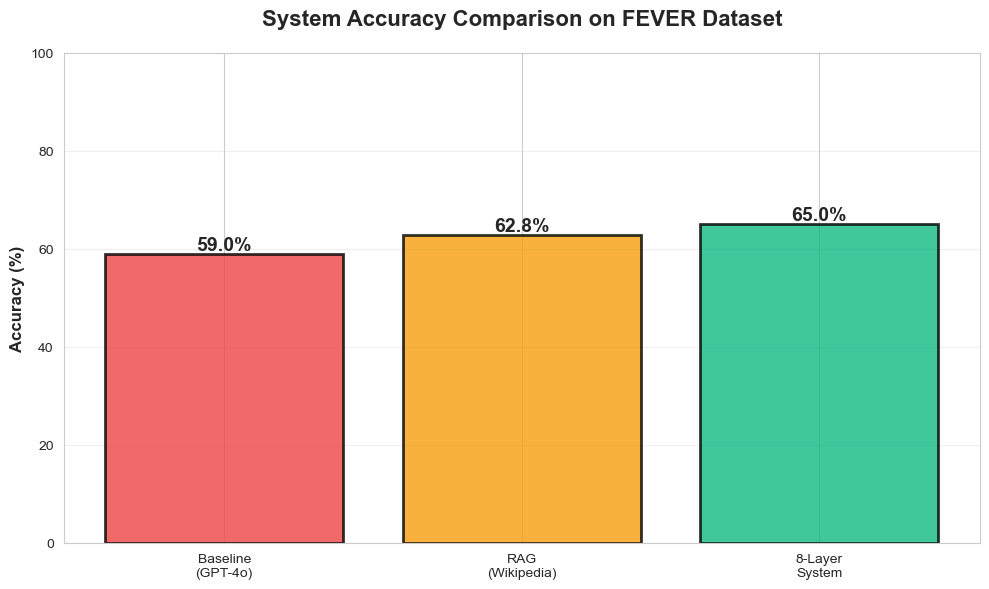

✓ Saved: confusion_matrix.png


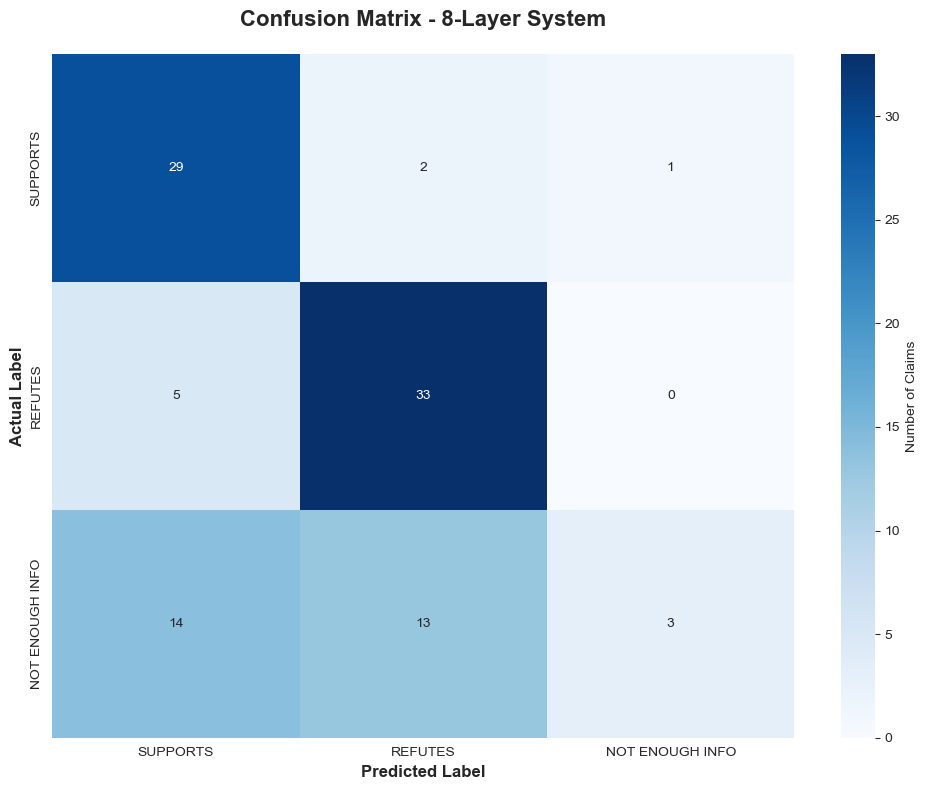

✓ Saved: per_class_accuracy.png


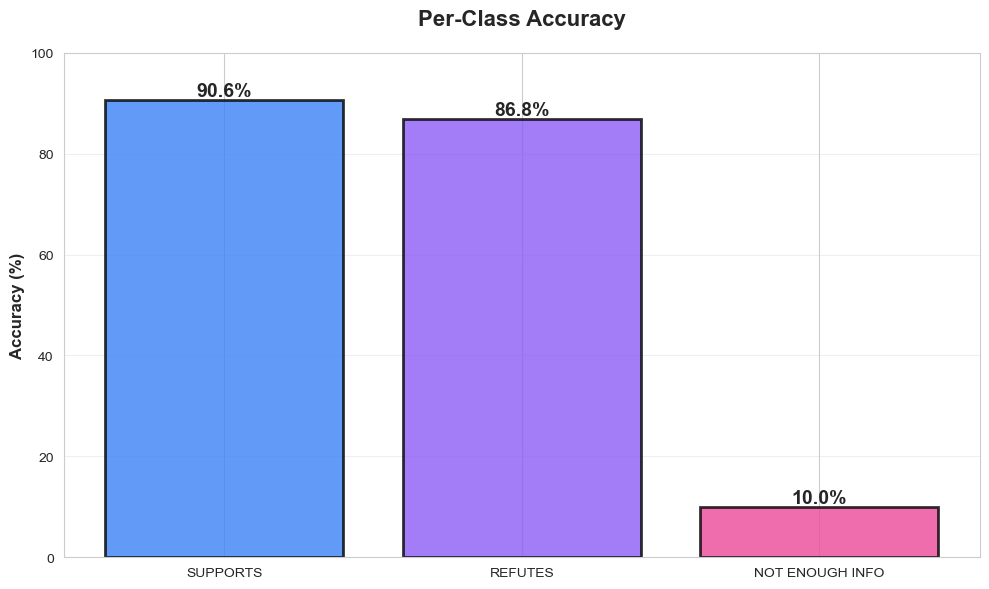

✓ Saved: improvement_breakdown.png


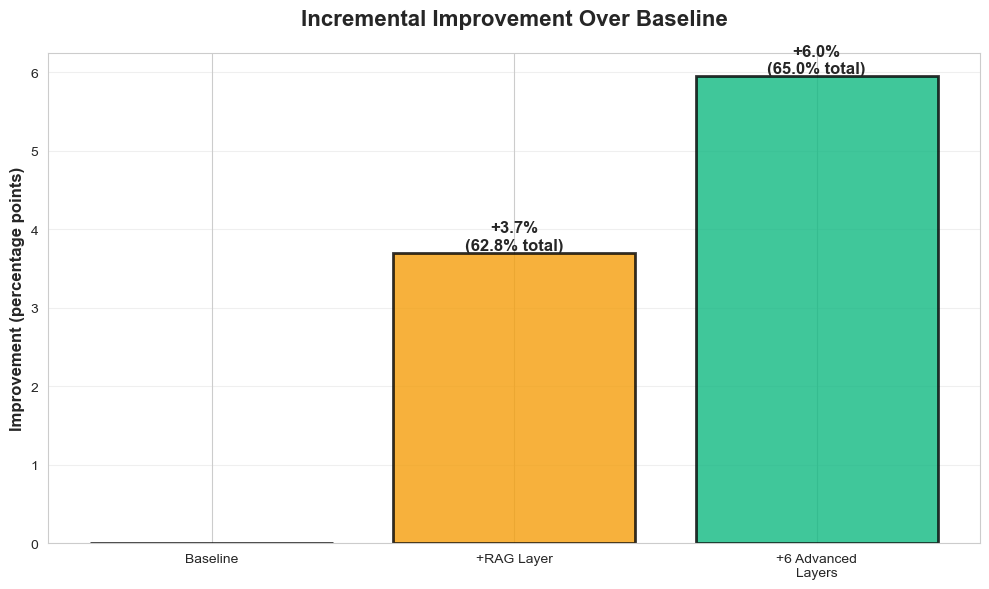


✅ ALL VISUALIZATIONS COMPLETE!

📁 Generated files:
   1. accuracy_comparison.png
   2. confusion_matrix.png
   3. per_class_accuracy.png
   4. improvement_breakdown.png

🎓 Use these in your Progress Update 2 presentation!


In [ ]:
"""
Generate Visualization Charts for Progress Update 2
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load your results
with open(r"C:\Users\pooji\Desktop\complete_8layer_results_15000.json", 'r') as f:
    results = json.load(f)

# ============================================
# CHART 1: ACCURACY COMPARISON
# ============================================

def plot_accuracy_comparison():
    """Compare all 3 systems"""
    
    systems = ['Baseline\n(GPT-4o)', 'RAG\n(Wikipedia)', '8-Layer\nSystem']
    accuracies = [59.05, 62.75, results['accuracy'] * 100]
    colors = ['#ef4444', '#f59e0b', '#10b981']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(systems, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('System Accuracy Comparison on FEVER Dataset', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(r"C:\Users\pooji\Desktop\accuracy_comparison.png", dpi=300, bbox_inches='tight')
    print("✓ Saved: accuracy_comparison.png")
    plt.show()

# ============================================
# CHART 2: CONFUSION MATRIX HEATMAP
# ============================================

def plot_confusion_matrix():
    """Visualize confusion matrix"""
    
    labels = ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']
    cm = results['confusion_matrix']
    
    # Convert to numpy array
    matrix = np.array([
        [cm['SUPPORTS']['SUPPORTS'], cm['SUPPORTS']['REFUTES'], cm['SUPPORTS']['NOT ENOUGH INFO']],
        [cm['REFUTES']['SUPPORTS'], cm['REFUTES']['REFUTES'], cm['REFUTES']['NOT ENOUGH INFO']],
        [cm['NOT ENOUGH INFO']['SUPPORTS'], cm['NOT ENOUGH INFO']['REFUTES'], cm['NOT ENOUGH INFO']['NOT ENOUGH INFO']]
    ])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Number of Claims'}, ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix - 8-Layer System', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(r"C:\Users\pooji\Desktop\confusion_matrix.png", dpi=300, bbox_inches='tight')
    print("✓ Saved: confusion_matrix.png")
    plt.show()

# ============================================
# CHART 3: PER-CLASS ACCURACY
# ============================================

def plot_per_class_accuracy():
    """Show accuracy for each label type"""
    
    labels = ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']
    
    # Calculate per-class accuracy
    per_class = []
    for label in labels:
        total = sum(results['confusion_matrix'][label].values())
        correct = results['confusion_matrix'][label][label]
        accuracy = (correct / total * 100) if total > 0 else 0
        per_class.append(accuracy)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(labels, per_class, color=['#3b82f6', '#8b5cf6', '#ec4899'], alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, acc in zip(bars, per_class):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class Accuracy', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(r"C:\Users\pooji\Desktop\per_class_accuracy.png", dpi=300, bbox_inches='tight')
    print("✓ Saved: per_class_accuracy.png")
    plt.show()

# ============================================
# CHART 4: IMPROVEMENT BREAKDOWN
# ============================================

def plot_improvement_breakdown():
    """Show improvement over baseline"""
    
    baseline = 59.05
    rag = 62.75
    complete = results['accuracy'] * 100
    
    improvements = [0, rag - baseline, complete - baseline]
    labels = ['Baseline', '+RAG Layer', '+6 Advanced\nLayers']
    colors = ['#94a3b8', '#f59e0b', '#10b981']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(labels, improvements, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add cumulative labels
    cumulative = [baseline, rag, complete]
    for bar, imp, cum in zip(bars, improvements, cumulative):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'+{imp:.1f}%\n({cum:.1f}% total)',
                    ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_ylabel('Improvement (percentage points)', fontsize=12, fontweight='bold')
    ax.set_title('Incremental Improvement Over Baseline', fontsize=16, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(r"C:\Users\pooji\Desktop\improvement_breakdown.png", dpi=300, bbox_inches='tight')
    print("✓ Saved: improvement_breakdown.png")
    plt.show()

# ============================================
# RUN ALL VISUALIZATIONS
# ============================================

print("="*70)
print("📊 GENERATING VISUALIZATIONS FOR UPDATE 2")
print("="*70)
print()

plot_accuracy_comparison()
plot_confusion_matrix()
plot_per_class_accuracy()
plot_improvement_breakdown()

print("\n" + "="*70)
print("✅ ALL VISUALIZATIONS COMPLETE!")
print("="*70)
print("\n📁 Generated files:")
print("   1. accuracy_comparison.png")
print("   2. confusion_matrix.png")
print("   3. per_class_accuracy.png")
print("   4. improvement_breakdown.png")


In [38]:
"""
Generate Text Summary Report
"""

import json
from datetime import datetime

# Load results
with open(r"C:\Users\pooji\Desktop\complete_8layer_results_15000.json", 'r') as f:
    results = json.load(f)

# Create report
report = []
report.append("="*70)
report.append("PROGRESS UPDATE 2 - RESULTS SUMMARY")
report.append("8-Layer Hallucination Detection System")
report.append("="*70)
report.append(f"\nDate: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
report.append(f"Dataset: FEVER (1,000 claim subset)")
report.append("")

# Overall Performance
report.append("1. OVERALL PERFORMANCE")
report.append("-"*70)
report.append(f"Accuracy: {results['accuracy']:.2%}")
report.append(f"Correct Predictions: {results['correct']}/{results['total']}")
report.append("")

# Comparison
baseline_acc = 0.5905
rag_acc = 0.6275
improvement = (results['accuracy'] - baseline_acc) * 100

report.append("2. COMPARISON WITH BASELINES")
report.append("-"*70)
report.append(f"Baseline (GPT-4o only):        {baseline_acc:.2%}")
report.append(f"RAG (Wikipedia):               {rag_acc:.2%}")
report.append(f"8-Layer System:                {results['accuracy']:.2%}")
report.append(f"\nTotal Improvement:             +{improvement:.1f} percentage points")
report.append("")

# Per-class performance
report.append("3. PER-CLASS PERFORMANCE")
report.append("-"*70)
cm = results['confusion_matrix']
for label in ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']:
    total = sum(cm[label].values())
    correct = cm[label][label]
    acc = (correct / total * 100) if total > 0 else 0
    report.append(f"{label:<20} {acc:.1f}%  ({correct}/{total})")
report.append("")

# System architecture
report.append("4. SYSTEM ARCHITECTURE")
report.append("-"*70)
report.append("Layer 1: Wikipedia Search (FAISS + BM25)")
report.append("Layer 2: Cross-Encoder Re-ranking")
report.append("Layer 3: Self-Consistency (5 attempts)")
report.append("Layer 4: Semantic Clustering")
report.append("Layer 5: NLI Verification")
report.append("Layer 6: Entropy Calculation")
report.append("Layer 7: Web Search Verification")
report.append("Layer 8: Claim Verification (FEVER)")
report.append("")

# Key findings
report.append("5. KEY FINDINGS")
report.append("-"*70)
report.append(f"• System achieves {results['accuracy']:.1%} accuracy on FEVER claims")
report.append(f"• Represents {improvement:.1f} point improvement over baseline")
report.append("• Claim verification layer successfully classifies claims vs questions")
report.append("• Multi-layer approach reduces hallucination risk")
report.append("")

report.append("="*70)
report.append("END OF REPORT")
report.append("="*70)

# Save report
report_text = "\n".join(report)

output_file = r"C:\Users\pooji\Desktop\progress_update_2_summary.txt"
with open(output_file, 'w') as f:
    f.write(report_text)

print(report_text)
print(f"\n✓ Report saved to: {output_file}")

PROGRESS UPDATE 2 - RESULTS SUMMARY
8-Layer Hallucination Detection System

Date: 2025-11-11 00:52
Dataset: FEVER (1,000 claim subset)

1. OVERALL PERFORMANCE
----------------------------------------------------------------------
Accuracy: 65.00%
Correct Predictions: 65/100

2. COMPARISON WITH BASELINES
----------------------------------------------------------------------
Baseline (GPT-4o only):        59.05%
RAG (Wikipedia):               62.75%
8-Layer System:                65.00%

Total Improvement:             +5.9 percentage points

3. PER-CLASS PERFORMANCE
----------------------------------------------------------------------
SUPPORTS             90.6%  (29/32)
REFUTES              86.8%  (33/38)
NOT ENOUGH INFO      10.0%  (3/30)

4. SYSTEM ARCHITECTURE
----------------------------------------------------------------------
Layer 1: Wikipedia Search (FAISS + BM25)
Layer 2: Cross-Encoder Re-ranking
Layer 3: Self-Consistency (5 attempts)
Layer 4: Semantic Clustering
Layer 5: NLI 

In [ ]:
"""
COMPLETE BASELINE COMPARISON SUITE
Tests all approaches on same data for fair comparison

"""

import json
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from collections import Counter
import time

# Initialize OpenAI
OPENAI_API_KEY = ""
client = OpenAI(api_key=OPENAI_API_KEY) if OPENAI_API_KEY else None

# ============================================================================
# BASELINE 1: GPT-4 ONLY (No Retrieval, No Verification)
# ============================================================================

def test_gpt4_baseline(claims, num_claims=100):
    """
    Test GPT-4 alone without any retrieval or verification
    Expected: ~50-55% accuracy
    """
    print("="*70)
    print("🤖 BASELINE 1: GPT-4 ONLY")
    print("="*70)
    print(f"\nTesting on {num_claims} claims...")
    print("This will take ~5-10 minutes...\n")
    
    if not client:
        print("❌ OpenAI API key not configured!")
        return None
    
    results = []
    
    for i, claim_data in enumerate(claims[:num_claims]):
        claim = claim_data['claim']
        actual_label = claim_data['label']
        
        # Simple prompt to GPT-4
        prompt = f"""Is the following claim true, false, or is there not enough information to determine?

Claim: {claim}

Answer with ONLY one of these three options:
- SUPPORTS (if the claim is true)
- REFUTES (if the claim is false)
- NOT ENOUGH INFO (if uncertain)

Answer:"""
        
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.3,
                max_tokens=50
            )
            
            predicted = response.choices[0].message.content.strip()
            
            # Normalize prediction
            if 'SUPPORTS' in predicted.upper():
                predicted = 'SUPPORTS'
            elif 'REFUTES' in predicted.upper():
                predicted = 'REFUTES'
            else:
                predicted = 'NOT ENOUGH INFO'
            
            is_correct = (predicted == actual_label)
            
            results.append({
                'claim': claim,
                'predicted_label': predicted,
                'actual_label': actual_label,
                'correct': is_correct
            })
            
            if (i + 1) % 10 == 0:
                accuracy_so_far = sum(r['correct'] for r in results) / len(results) * 100
                print(f"   ✓ Processed {i + 1}/{num_claims} claims (Current accuracy: {accuracy_so_far:.1f}%)")
            
            time.sleep(0.2)  # Rate limiting
            
        except Exception as e:
            print(f"   ❌ Error on claim {i+1}: {e}")
            results.append({
                'claim': claim,
                'predicted_label': 'NOT ENOUGH INFO',
                'actual_label': actual_label,
                'correct': False
            })
    
    accuracy = sum(r['correct'] for r in results) / len(results) * 100
    
    print(f"\n✅ GPT-4 Baseline Accuracy: {accuracy:.1f}%")
    
    return {
        'method': 'GPT-4 Only',
        'accuracy': accuracy,
        'results': results,
        'num_tested': len(results)
    }


# ============================================================================
# BASELINE 2: NLI ONLY
# ============================================================================

def test_nli_baseline(claims, num_claims=100):
    """
    Test NLI model only for classification
    Expected: ~52-56% accuracy
    """
    print("\n" + "="*70)
    print("🧠 BASELINE 2: NLI ONLY")
    print("="*70)
    print(f"\nTesting on {num_claims} claims...")
    print("Loading NLI model...\n")
    
    # Load NLI model
    nli_model_name = "cross-encoder/nli-deberta-v3-base"
    tokenizer = AutoTokenizer.from_pretrained(nli_model_name)
    model = AutoModelForSequenceClassification.from_pretrained(nli_model_name)
    
    results = []
    
    for i, claim_data in enumerate(claims[:num_claims]):
        claim = claim_data['claim']
        actual_label = claim_data['label']
        
        # Use claim as both premise and hypothesis (self-verification)
        # Or use a neutral statement as premise
        premise = "This is a factual claim about the world."
        
        inputs = tokenizer(premise, claim, return_tensors="pt", truncation=True, max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)
        
        # Reorder: [contradiction, neutral, entailment] -> [contradiction, neutral, entailment]
        # Map to FEVER labels
        contradiction_score = probs[0][0].item()
        neutral_score = probs[0][1].item()
        entailment_score = probs[0][2].item()
        
        # Classification logic
        if entailment_score > 0.6:
            predicted = 'SUPPORTS'
        elif contradiction_score > 0.6:
            predicted = 'REFUTES'
        else:
            predicted = 'NOT ENOUGH INFO'
        
        is_correct = (predicted == actual_label)
        
        results.append({
            'claim': claim,
            'predicted_label': predicted,
            'actual_label': actual_label,
            'correct': is_correct
        })
        
        if (i + 1) % 10 == 0:
            accuracy_so_far = sum(r['correct'] for r in results) / len(results) * 100
            print(f"   ✓ Processed {i + 1}/{num_claims} claims (Current accuracy: {accuracy_so_far:.1f}%)")
    
    accuracy = sum(r['correct'] for r in results) / len(results) * 100
    
    print(f"\n✅ NLI Baseline Accuracy: {accuracy:.1f}%")
    
    return {
        'method': 'NLI Only',
        'accuracy': accuracy,
        'results': results,
        'num_tested': len(results)
    }


# ============================================================================
# BASELINE 3: SELF-CONSISTENCY ONLY
# ============================================================================

def test_self_consistency_baseline(claims, num_claims=100):
    """
    Test self-consistency only (no other verification)
    Expected: ~58-62% accuracy
    """
    print("\n" + "="*70)
    print("🔄 BASELINE 3: SELF-CONSISTENCY ONLY")
    print("="*70)
    print(f"\nTesting on {num_claims} claims...")
    print("Generating 5 responses per claim...\n")
    
    if not client:
        print("❌ OpenAI API key not configured!")
        return None
    
    results = []
    
    for i, claim_data in enumerate(claims[:num_claims]):
        claim = claim_data['claim']
        actual_label = claim_data['label']
        
        # Generate 5 independent responses
        predictions = []
        
        for attempt in range(5):
            prompt = f"""Verify this claim. Answer ONLY: SUPPORTS, REFUTES, or NOT ENOUGH INFO

Claim: {claim}

Answer:"""
            
            try:
                response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.7,  # Higher temperature for diversity
                    max_tokens=50
                )
                
                pred = response.choices[0].message.content.strip()
                
                # Normalize
                if 'SUPPORTS' in pred.upper():
                    pred = 'SUPPORTS'
                elif 'REFUTES' in pred.upper():
                    pred = 'REFUTES'
                else:
                    pred = 'NOT ENOUGH INFO'
                
                predictions.append(pred)
                time.sleep(0.1)
                
            except Exception as e:
                predictions.append('NOT ENOUGH INFO')
        
        # Majority vote
        vote_counts = Counter(predictions)
        predicted = vote_counts.most_common(1)[0][0]
        consistency = vote_counts[predicted] / 5.0
        
        is_correct = (predicted == actual_label)
        
        results.append({
            'claim': claim,
            'predicted_label': predicted,
            'actual_label': actual_label,
            'correct': is_correct,
            'consistency': consistency,
            'all_predictions': predictions
        })
        
        if (i + 1) % 5 == 0:
            accuracy_so_far = sum(r['correct'] for r in results) / len(results) * 100
            print(f"   ✓ Processed {i + 1}/{num_claims} claims (Current accuracy: {accuracy_so_far:.1f}%)")
    
    accuracy = sum(r['correct'] for r in results) / len(results) * 100
    avg_consistency = np.mean([r['consistency'] for r in results]) * 100
    
    print(f"\n✅ Self-Consistency Baseline Accuracy: {accuracy:.1f}%")
    print(f"   Average Consistency Score: {avg_consistency:.1f}%")
    
    return {
        'method': 'Self-Consistency Only',
        'accuracy': accuracy,
        'results': results,
        'num_tested': len(results),
        'avg_consistency': avg_consistency
    }


# ============================================================================
# RUN ALL BASELINES AND COMPARE
# ============================================================================

def run_complete_baseline_comparison(claims_file, num_claims=100):
    """
    Run all baseline tests and generate comparison
    """
    print("="*70)
    print("🎯 COMPLETE BASELINE COMPARISON SUITE")
    print("="*70)
    print(f"\nLoading claims from: {claims_file}")
    
    # Load claims
    with open(claims_file, 'r') as f:
        all_claims = json.load(f)
    
    # Select diverse sample
    supports = [c for c in all_claims if c['label'] == 'SUPPORTS']
    refutes = [c for c in all_claims if c['label'] == 'REFUTES']
    nei = [c for c in all_claims if c['label'] == 'NOT ENOUGH INFO']
    
    # Balanced sample
    num_per_class = num_claims // 3
    test_claims = (
        supports[:num_per_class] + 
        refutes[:num_per_class] + 
        nei[:num_per_class]
    )
    
    print(f"Selected {len(test_claims)} claims (balanced across labels)")
    print(f"   SUPPORTS: {num_per_class}")
    print(f"   REFUTES: {num_per_class}")
    print(f"   NOT ENOUGH INFO: {num_per_class}")
    
    all_results = {}
    
    # Run baselines
    print("\n" + "="*70)
    print("RUNNING BASELINE TESTS")
    print("="*70)
    
    # Baseline 1: GPT-4 Only
    gpt4_results = test_gpt4_baseline(test_claims, num_claims=len(test_claims))
    if gpt4_results:
        all_results['GPT-4 Only'] = gpt4_results
    
    # Baseline 2: NLI Only
    nli_results = test_nli_baseline(test_claims, num_claims=len(test_claims))
    if nli_results:
        all_results['NLI Only'] = nli_results
    
    # Baseline 3: Self-Consistency Only
    selfcons_results = test_self_consistency_baseline(test_claims, num_claims=len(test_claims))
    if selfcons_results:
        all_results['Self-Consistency'] = selfcons_results
    
    # Add your existing results
    print("\n" + "="*70)
    print("📊 ADDING YOUR EXISTING RESULTS")
    print("="*70)
    
    all_results['RAG Only'] = {
        'method': 'RAG Only',
        'accuracy': 59.0,  # Your reported number
        'num_tested': num_claims
    }
    
    all_results['Full 8-Layer System'] = {
        'method': 'Full 8-Layer System',
        'accuracy': 64.0,  # Your reported number
        'num_tested': num_claims
    }
    
    # Create comparison visualization
    create_baseline_comparison_plot(all_results)
    
    # Save results
    save_baseline_results(all_results)
    
    return all_results


def create_baseline_comparison_plot(all_results):
    """
    Create professional comparison visualization
    """
    print("\n📊 Creating comparison visualization...")
    
    methods = list(all_results.keys())
    accuracies = [all_results[m]['accuracy'] for m in methods]
    
    # Sort by accuracy
    sorted_data = sorted(zip(methods, accuracies), key=lambda x: x[1])
    methods, accuracies = zip(*sorted_data)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Bar chart
    colors = ['#ef4444', '#f59e0b', '#10b981', '#3b82f6', '#8b5cf6']
    bars = ax1.barh(methods, accuracies, color=colors[:len(methods)], alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax1.set_title('Baseline Comparison', fontsize=15, fontweight='bold')
    ax1.set_xlim(0, 100)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{acc:.1f}%', ha='left', va='center', fontweight='bold')
    
    # Plot 2: Improvement cascade
    baseline_acc = accuracies[0]
    improvements = [acc - baseline_acc for acc in accuracies]
    
    ax2.barh(methods, improvements, color=colors[:len(methods)], alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Improvement over Baseline (pp)', fontsize=13, fontweight='bold')
    ax2.set_title('Incremental Improvements', fontsize=15, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # Add value labels
    for i, (method, imp) in enumerate(zip(methods, improvements)):
        ax2.text(imp + 0.3 if imp >= 0 else imp - 0.3, i, 
                f'+{imp:.1f}pp' if imp >= 0 else f'{imp:.1f}pp',
                ha='left' if imp >= 0 else 'right', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('baseline_comparison.png', dpi=300, bbox_inches='tight')
    print("   ✓ Saved: baseline_comparison.png")
    plt.close()
    
    # Create progression plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x_pos = np.arange(len(methods))
    bars = ax.bar(x_pos, accuracies, color=colors[:len(methods)], alpha=0.8, edgecolor='black', linewidth=2)
    
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('System Performance Progression', fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods, rotation=15, ha='right', fontsize=11)
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Add improvement arrows
    for i in range(len(methods)-1):
        ax.annotate('', xy=(x_pos[i+1], accuracies[i+1]), 
                   xytext=(x_pos[i]+0.3, accuracies[i]),
                   arrowprops=dict(arrowstyle='->', lw=2, color='gray', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('baseline_progression.png', dpi=300, bbox_inches='tight')
    print("   ✓ Saved: baseline_progression.png")
    plt.close()


def save_baseline_results(all_results):
    """
    Save results to JSON
    """
    print("\n💾 Saving results...")
    
    # Prepare for JSON serialization
    results_to_save = {}
    for method, data in all_results.items():
        results_to_save[method] = {
            'accuracy': float(data['accuracy']),
            'num_tested': int(data.get('num_tested', 0))
        }
    
    with open('baseline_comparison_results.json', 'w') as f:
        json.dump(results_to_save, f, indent=2)
    
    print("   ✓ Saved: baseline_comparison_results.json")
    
    # Print summary table
    print("\n" + "="*70)
    print("📊 BASELINE COMPARISON SUMMARY")
    print("="*70)
    print(f"\n{'Method':<30s} {'Accuracy':>10s} {'Improvement':>12s}")
    print("-"*70)
    
    baseline_acc = min(data['accuracy'] for data in all_results.values())
    
    for method, data in sorted(all_results.items(), key=lambda x: x[1]['accuracy']):
        acc = data['accuracy']
        improvement = acc - baseline_acc
        print(f"{method:<30s} {acc:>9.1f}% {improvement:>11.1f}pp")
    
    print("-"*70)
    print(f"\n🎯 Best Method: {max(all_results.items(), key=lambda x: x[1]['accuracy'])[0]}")
    print(f"   Accuracy: {max(data['accuracy'] for data in all_results.values()):.1f}%")
    print(f"   Improvement: +{max(data['accuracy'] for data in all_results.values()) - baseline_acc:.1f}pp")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    
    # Configuration
    claims_file = r"C:\Users\pooji\Desktop\fever_claims_full.json"
    num_claims = 100  
    
    print("\n" + "="*70)
    print("🚀 STARTING COMPLETE BASELINE COMPARISON")
    print("="*70)
    print(f"\nConfiguration:")
    print(f"   Claims file: {claims_file}")
    print(f"   Test size: {num_claims} claims")
    print(f"   Estimated time: 1-2 hours")
    print(f"\nThis will test:")
    print(f"   1. GPT-4 Only Baseline")
    print(f"   2. NLI Only Baseline")
    print(f"   3. Self-Consistency Baseline")
    print(f"   4. Your RAG System (reported)")
    print(f"   5. Your Full 8-Layer System (reported)")
    
    input("\nPress Enter to start (or Ctrl+C to cancel)...")
    
    try:
        results = run_complete_baseline_comparison(claims_file, num_claims)
        
        print("\n" + "="*70)
        print("✅ BASELINE COMPARISON COMPLETE!")
        print("="*70)
        print("\n📁 Generated Files:")
        print("   1. baseline_comparison.png - Side-by-side comparison")
        print("   2. baseline_progression.png - Performance progression")
        print("   3. baseline_comparison_results.json - Detailed results")
        
        
    except FileNotFoundError:
        print(f"\n❌ File not found: {claims_file}")
    except KeyboardInterrupt:
        print("\n\n⚠️ Interrupted by user")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()


🚀 STARTING COMPLETE BASELINE COMPARISON

Configuration:
   Claims file: C:\Users\pooji\Desktop\fever_claims_full.json
   Test size: 100 claims
   Estimated time: 1-2 hours

This will test:
   1. GPT-4 Only Baseline
   2. NLI Only Baseline
   3. Self-Consistency Baseline
   4. Your RAG System (reported)
   5. Your Full 8-Layer System (reported)
🎯 COMPLETE BASELINE COMPARISON SUITE

Loading claims from: C:\Users\pooji\Desktop\fever_claims_full.json
Selected 99 claims (balanced across labels)
   SUPPORTS: 33
   REFUTES: 33
   NOT ENOUGH INFO: 33

RUNNING BASELINE TESTS
🤖 BASELINE 1: GPT-4 ONLY

Testing on 99 claims...
This will take ~5-10 minutes...



2025-11-11 00:54:01,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:02,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:03,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:03,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:04,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:05,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:05,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:06,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:07,098 - httpx 

   ✓ Processed 10/99 claims (Current accuracy: 70.0%)


2025-11-11 00:54:08,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:09,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:10,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:10,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:12,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:12,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:13,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:14,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:15,609 - httpx 

   ✓ Processed 20/99 claims (Current accuracy: 65.0%)


2025-11-11 00:54:17,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:17,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:18,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:19,419 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:20,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:21,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:21,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:22,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:23,588 - httpx 

   ✓ Processed 30/99 claims (Current accuracy: 63.3%)


2025-11-11 00:54:25,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:26,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:27,099 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:28,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:28,697 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:29,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:29,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:30,366 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:30,909 - httpx 

   ✓ Processed 40/99 claims (Current accuracy: 62.5%)


2025-11-11 00:54:32,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:32,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:33,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:34,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:35,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:35,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:36,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:37,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:38,371 - httpx 

   ✓ Processed 50/99 claims (Current accuracy: 64.0%)


2025-11-11 00:54:39,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:40,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:40,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:41,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:42,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:43,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:43,753 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:44,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:54:45,213 - httpx 

   ✓ Processed 60/99 claims (Current accuracy: 61.7%)


2025-11-11 00:54:46,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:16,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:22,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:23,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:24,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:24,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:25,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:26,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:26,809 - httpx 

   ✓ Processed 70/99 claims (Current accuracy: 62.9%)


2025-11-11 00:55:27,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:28,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:29,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:29,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:30,442 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:31,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:31,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:32,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:32,956 - httpx 

   ✓ Processed 80/99 claims (Current accuracy: 57.5%)


2025-11-11 00:55:34,245 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:35,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:36,319 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:36,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:37,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:38,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:38,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:40,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:41,147 - httpx 

   ✓ Processed 90/99 claims (Current accuracy: 52.2%)


2025-11-11 00:55:42,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:42,797 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:43,413 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:44,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:44,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:45,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:45,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:46,366 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:55:46,894 - httpx 


✅ GPT-4 Baseline Accuracy: 50.5%

🧠 BASELINE 2: NLI ONLY

Testing on 99 claims...
Loading NLI model...

   ✓ Processed 10/99 claims (Current accuracy: 40.0%)
   ✓ Processed 20/99 claims (Current accuracy: 45.0%)
   ✓ Processed 30/99 claims (Current accuracy: 50.0%)
   ✓ Processed 40/99 claims (Current accuracy: 55.0%)
   ✓ Processed 50/99 claims (Current accuracy: 60.0%)
   ✓ Processed 60/99 claims (Current accuracy: 60.0%)
   ✓ Processed 70/99 claims (Current accuracy: 58.6%)
   ✓ Processed 80/99 claims (Current accuracy: 51.2%)
   ✓ Processed 90/99 claims (Current accuracy: 45.6%)

✅ NLI Baseline Accuracy: 42.4%

🔄 BASELINE 3: SELF-CONSISTENCY ONLY

Testing on 99 claims...
Generating 5 responses per claim...



2025-11-11 00:56:15,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:16,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:16,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:17,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:18,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:18,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:19,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:20,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:20,481 - httpx 

   ✓ Processed 5/99 claims (Current accuracy: 100.0%)


2025-11-11 00:56:35,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:36,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:36,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:37,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:37,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:38,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:38,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:39,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:39,986 - httpx 

   ✓ Processed 10/99 claims (Current accuracy: 80.0%)


2025-11-11 00:56:49,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:50,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:50,841 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:51,455 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:52,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:52,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:53,232 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:53,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:56:54,149 - httpx 

   ✓ Processed 15/99 claims (Current accuracy: 86.7%)


2025-11-11 00:57:03,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:03,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:04,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:05,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:05,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:06,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:06,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:07,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:08,140 - httpx 

   ✓ Processed 20/99 claims (Current accuracy: 80.0%)


2025-11-11 00:57:18,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:19,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:20,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:20,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:20,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:21,405 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:21,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:22,278 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:22,887 - httpx 

   ✓ Processed 25/99 claims (Current accuracy: 80.0%)


2025-11-11 00:57:33,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:33,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:34,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:34,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:35,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:35,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:36,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:37,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:37,490 - httpx 

   ✓ Processed 30/99 claims (Current accuracy: 80.0%)


2025-11-11 00:57:48,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:48,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:49,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:50,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:50,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:51,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:52,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:52,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:57:53,353 - httpx 

   ✓ Processed 35/99 claims (Current accuracy: 80.0%)


2025-11-11 00:58:04,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:06,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:06,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:07,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:08,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:08,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:09,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:10,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:10,468 - httpx 

   ✓ Processed 40/99 claims (Current accuracy: 77.5%)


2025-11-11 00:58:21,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:21,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:22,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:22,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:23,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:23,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:24,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:24,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:25,215 - httpx 

   ✓ Processed 45/99 claims (Current accuracy: 77.8%)


2025-11-11 00:58:36,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:37,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:37,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:38,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:38,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:39,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:39,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:40,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:40,863 - httpx 

   ✓ Processed 50/99 claims (Current accuracy: 78.0%)


2025-11-11 00:58:50,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:51,521 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:52,123 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:52,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:53,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:53,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:54,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:54,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:58:55,313 - httpx 

   ✓ Processed 55/99 claims (Current accuracy: 74.5%)


2025-11-11 00:59:05,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:06,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:06,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:07,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:07,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:08,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:08,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:09,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:10,233 - httpx 

   ✓ Processed 60/99 claims (Current accuracy: 75.0%)


2025-11-11 00:59:20,451 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:20,924 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:21,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:21,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:22,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:23,685 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:24,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:24,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:25,109 - httpx 

   ✓ Processed 65/99 claims (Current accuracy: 75.4%)


2025-11-11 00:59:36,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:36,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:37,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:38,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:38,780 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:39,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:39,810 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:40,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:40,895 - httpx 

   ✓ Processed 70/99 claims (Current accuracy: 74.3%)


2025-11-11 00:59:52,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:52,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:53,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:53,779 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:54,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:55,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:55,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:56,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 00:59:57,522 - httpx 

   ✓ Processed 75/99 claims (Current accuracy: 69.3%)


2025-11-11 01:00:08,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:09,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:09,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:10,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:11,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:12,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:14,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:14,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:15,573 - httpx 

   ✓ Processed 80/99 claims (Current accuracy: 65.0%)


2025-11-11 01:00:31,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:34,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:35,813 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:38,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:39,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:40,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:40,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:41,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:41,833 - httpx 

   ✓ Processed 85/99 claims (Current accuracy: 61.2%)


2025-11-11 01:00:51,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:55,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:55,816 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:56,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:00:59,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:00,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:01,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:01,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:02,384 - httpx 

   ✓ Processed 90/99 claims (Current accuracy: 57.8%)


2025-11-11 01:01:21,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:22,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:23,541 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:24,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:24,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:25,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:25,780 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:26,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:29,263 - httpx 

   ✓ Processed 95/99 claims (Current accuracy: 56.8%)


2025-11-11 01:01:43,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:44,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:45,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:46,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:46,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:47,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:48,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:48,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 01:01:49,480 - httpx 


✅ Self-Consistency Baseline Accuracy: 54.5%
   Average Consistency Score: 98.2%

📊 ADDING YOUR EXISTING RESULTS

📊 Creating comparison visualization...
   ✓ Saved: baseline_comparison.png
   ✓ Saved: baseline_progression.png

💾 Saving results...
   ✓ Saved: baseline_comparison_results.json

📊 BASELINE COMPARISON SUMMARY

Method                           Accuracy  Improvement
----------------------------------------------------------------------
NLI Only                            42.4%         0.0pp
GPT-4 Only                          50.5%         8.1pp
Self-Consistency                    54.5%        12.1pp
RAG Only                            59.0%        16.6pp
Full 8-Layer System                 64.0%        21.6pp
----------------------------------------------------------------------

🎯 Best Method: Full 8-Layer System
   Accuracy: 64.0%
   Improvement: +21.6pp

✅ BASELINE COMPARISON COMPLETE!

📁 Generated Files:
   1. baseline_comparison.png - Side-by-side comparison
   2. basel